# Sentiment Analysis of IMDB move reviews with LSTM

## Set up notebook environment

In [21]:
## To set up working directory
import os
print (os.getcwd())

# To change current working directory
os.chdir('F:\Deep Learning Developer\Wk5 beginning 23 Oct 17')
print (os.getcwd())

F:\Deep Learning Developer\Wk5 beginning 23 Oct 17
F:\Deep Learning Developer\Wk5 beginning 23 Oct 17


In [22]:
## Import libraries
import keras
from keras.models import Model, Sequential
from keras.layers import *      #(Dense, LSTM, Dropout, Input etc)
from keras import optimizers    #(RMSprop, Adam)
import tensorflow as tf

import numpy as np

print(keras.__version__)
print(tf.__version__)

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import random
random.seed(123)


2.0.6
1.3.0


## Download IMDB dataset

ai.stanford.edu/~amaas/data/sentiment/

A dataset for binary sentiment classification. 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats. See the README file for more details. 

ai.stanford.edu/~amaas/data/sentiment/

To organize one string per review. Review label that are negative == "0", positive == "1". 

In [23]:
import os

imdb_dir = 'F:\Deep Learning Developer\Wk5 beginning 23 Oct 17\MovieReview'

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                

## Tokenization

To vectorize the tokens, and prepare training and validation split.  To use pre-trained word embeddings.

(To compare against task-specific embedding later)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500  # We will cut reviews after len(maxlen) words. Number of words to consider as features
max_words = 10000  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

training_samples = 25000  # will set 80/20 training and validation split during model fitting

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
print('Found %s sequences.' % len(sequences))

word_index = tokenizer.word_index  # unique words are indexed
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)  # standardize all sequences to be maxlen long

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

X_train = data[:training_samples]
y_train = labels[:training_samples]


print(len(X_train), ' train sequences in X_train')



Found 25000 sequences.
Found 88582 unique tokens.


Shape of data tensor: (25000, 500)
Shape of label tensor: (25000,)
25000  train sequences in X_train


In [25]:
print("First 2 cases of training inputs :", X_train[0:1])
print("First 2 cases of training labels :", y_train[0:1])


First 2 cases of training inputs : [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   

### Download GloVe pre-trained embedding

https://nlp.stanford.edu/projects/glove/

Download the pre-computed embeddings from 2014 English Wikipedia. glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens). 

Pre-process the embedding to build an index mapping words, as strings, to their vector representation, as number vectors. 

In [26]:
glove_dir = 'F:\Deep Learning Developer\Wk5 beginning 23 Oct 17\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['1']



Found 400000 word vectors.


array([ -3.22189987e-01,   6.46319985e-01,   2.73119994e-02,
         3.65790009e-01,  -2.69660004e-03,   1.72450006e-01,
         1.10920000e+00,   3.54499996e-01,  -3.28800008e-02,
        -3.47869992e-01,   1.07969999e+00,  -2.01069996e-01,
        -6.78110003e-01,   4.92110014e-01,   5.76460004e-01,
        -3.39560002e-01,   8.49919975e-01,   1.37979999e-01,
        -2.40020007e-01,   6.97849989e-01,   5.25049984e-01,
        -1.23520002e-01,   4.46799994e-01,   1.00179994e+00,
         4.15199995e-01,   3.46130013e-01,   7.13140011e-01,
         1.00149997e-01,   3.37170005e-01,  -2.49669999e-01,
        -2.49610007e-01,   8.51100028e-01,  -3.88420001e-02,
        -2.07609996e-01,  -6.69610023e-01,   2.67360002e-01,
        -7.10730022e-03,   9.64380026e-01,  -9.21259969e-02,
         1.14680000e-03,   8.09520006e-01,  -1.57400000e+00,
         2.79089987e-01,  -6.86590016e-01,   5.70550025e-01,
        -5.33959985e-01,  -3.29820007e-01,  -3.26480001e-01,
        -2.43730005e-02,

In [27]:
embedding_dim = 100 # align with max_words in code chunk above

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
embedding_matrix[0:2]
# index 0 is not supposed to stand for any word or token -- it's a placeholder.

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

## Define a LSTM model - with pre-trained word embedding from GloVe




### What are Timesteps and Features?
https://stackoverflow.com/questions/38714959/understanding-keras-lstms

 

### How to stack LSTM layers
https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

expected input data shape: (batch_size, timesteps, data_dim)
<br>
model = Sequential()
<br>
model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
<br>
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
<br>
model.add(LSTM(32))  # return a single vector of dimension 32
<br>
model.add(Dense(10, activation='softmax'))


In [28]:
from keras.layers import LSTM

# stacked LSTM takes too long to train with GPU not working. Switch to single LSTM layer.

model_wGloVE = Sequential()
model_wGloVE.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# LSTM layers have to have input in the size [samples, timesteps, features] ie., 3D array
model_wGloVE.add(LSTM(100))
# model_wGloVE.add(LSTM(100, input_shape=(max_words, embedding_dim, maxlen), return_sequences=True))
# model_wGloVE.add(Dropout(0.2))
# model_wGloVE.add(LSTM(100))
model_wGloVE.add(Dense(1, activation='sigmoid'))  # this last layer returns last output ie., last state, not full state sequence



### Load the GloVe embedding into the model

In [29]:
model_wGloVE.layers[0].set_weights([embedding_matrix])
model_wGloVE.layers[0].trainable = False


### Train and Evaluate

Larger batch size speed up training especially with GPU while small batch size is just moving batch data on and off GPU.

Larger batch size also means doing less gradient updates. Will need to train for more epochs than with smaller batch size.

Expect to have different results for a given number of epochs with different batch sizes.  Final accuracy after convergence should not differ significantly.


In [30]:
model_wGloVE.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history_wGloVe = model_wGloVE.fit(X_train, y_train,
                    epochs=3,
                    batch_size=64,
                    validation_split=0.2)

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_wGloVE.save_weights('model_wGloVE_saved_weights.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/3


   64/20000 [..............................] - ETA: 480s - loss: 0.6960 - acc: 0.5000

  128/20000 [..............................] - ETA: 352s - loss: 0.7480 - acc: 0.4297

  192/20000 [..............................] - ETA: 309s - loss: 0.7409 - acc: 0.4583

  256/20000 [..............................] - ETA: 287s - loss: 0.7339 - acc: 0.4648

  320/20000 [..............................] - ETA: 273s - loss: 0.7235 - acc: 0.4844

  384/20000 [..............................] - ETA: 264s - loss: 0.7192 - acc: 0.4870

  448/20000 [..............................] - ETA: 257s - loss: 0.7141 - acc: 0.5022

  512/20000 [..............................] - ETA: 252s - loss: 0.7147 - acc: 0.4902

  576/20000 [..............................] - ETA: 247s - loss: 0.7098 - acc: 0.5017

  640/20000 [..............................] - ETA: 244s - loss: 0.7064 - acc: 0.5125

  704/20000 [>.............................] - ETA: 240s - loss: 0.7061 - acc: 0.5071

  768/20000 [>.............................] - ETA: 238s - loss: 0.7025 - acc: 0.5195

  832/20000 [>.............................] - ETA: 236s - loss: 0.7004 - acc: 0.5264

  896/20000 [>.............................] - ETA: 233s - loss: 0.6995 - acc: 0.5290

  960/20000 [>.............................] - ETA: 232s - loss: 0.6964 - acc: 0.5375

 1024/20000 [>.............................] - ETA: 230s - loss: 0.6945 - acc: 0.5391

 1088/20000 [>.............................] - ETA: 228s - loss: 0.6931 - acc: 0.5414

 1152/20000 [>.............................] - ETA: 227s - loss: 0.6903 - acc: 0.5460

 1216/20000 [>.............................] - ETA: 225s - loss: 0.6929 - acc: 0.5403

 1280/20000 [>.............................] - ETA: 224s - loss: 0.6909 - acc: 0.5437

 1344/20000 [=>............................] - ETA: 223s - loss: 0.6899 - acc: 0.5439

 1408/20000 [=>............................] - ETA: 222s - loss: 0.6891 - acc: 0.5469

 1472/20000 [=>............................] - ETA: 220s - loss: 0.6890 - acc: 0.5448

 1536/20000 [=>............................] - ETA: 219s - loss: 0.6881 - acc: 0.5456

 1600/20000 [=>............................] - ETA: 218s - loss: 0.6876 - acc: 0.5487

 1664/20000 [=>............................] - ETA: 217s - loss: 0.6875 - acc: 0.5475

 1728/20000 [=>............................] - ETA: 216s - loss: 0.6870 - acc: 0.5451

 1792/20000 [=>............................] - ETA: 215s - loss: 0.6861 - acc: 0.5485

 1856/20000 [=>............................] - ETA: 214s - loss: 0.6854 - acc: 0.5496

 1920/20000 [=>............................] - ETA: 213s - loss: 0.6854 - acc: 0.5495

 1984/20000 [=>............................] - ETA: 212s - loss: 0.6859 - acc: 0.5469

 2048/20000 [==>...........................] - ETA: 211s - loss: 0.6840 - acc: 0.5503

 2112/20000 [==>...........................] - ETA: 210s - loss: 0.6829 - acc: 0.5521

 2176/20000 [==>...........................] - ETA: 209s - loss: 0.6834 - acc: 0.5492

 2240/20000 [==>...........................] - ETA: 208s - loss: 0.6824 - acc: 0.5509

 2304/20000 [==>...........................] - ETA: 207s - loss: 0.6820 - acc: 0.5503

 2368/20000 [==>...........................] - ETA: 206s - loss: 0.6820 - acc: 0.5515

 2432/20000 [==>...........................] - ETA: 205s - loss: 0.6807 - acc: 0.5559

 2496/20000 [==>...........................] - ETA: 204s - loss: 0.6793 - acc: 0.5577

 2560/20000 [==>...........................] - ETA: 203s - loss: 0.6796 - acc: 0.5582

 2624/20000 [==>...........................] - ETA: 202s - loss: 0.6786 - acc: 0.5617

 2688/20000 [===>..........................] - ETA: 202s - loss: 0.6772 - acc: 0.5658

 2752/20000 [===>..........................] - ETA: 201s - loss: 0.6766 - acc: 0.5676

 2816/20000 [===>..........................] - ETA: 200s - loss: 0.6766 - acc: 0.5678

 2880/20000 [===>..........................] - ETA: 199s - loss: 0.6752 - acc: 0.5701

 2944/20000 [===>..........................] - ETA: 198s - loss: 0.6730 - acc: 0.5724

 3008/20000 [===>..........................] - ETA: 197s - loss: 0.6729 - acc: 0.5718

 3072/20000 [===>..........................] - ETA: 196s - loss: 0.6732 - acc: 0.5713

 3136/20000 [===>..........................] - ETA: 195s - loss: 0.6719 - acc: 0.5727

 3200/20000 [===>..........................] - ETA: 195s - loss: 0.6719 - acc: 0.5728

 3264/20000 [===>..........................] - ETA: 194s - loss: 0.6722 - acc: 0.5717

 3328/20000 [===>..........................] - ETA: 193s - loss: 0.6722 - acc: 0.5721

 3392/20000 [====>.........................] - ETA: 192s - loss: 0.6713 - acc: 0.5734

 3456/20000 [====>.........................] - ETA: 191s - loss: 0.6703 - acc: 0.5749

 3520/20000 [====>.........................] - ETA: 191s - loss: 0.6686 - acc: 0.5778

 3584/20000 [====>.........................] - ETA: 190s - loss: 0.6699 - acc: 0.5781

 3648/20000 [====>.........................] - ETA: 189s - loss: 0.6701 - acc: 0.5770

 3712/20000 [====>.........................] - ETA: 188s - loss: 0.6689 - acc: 0.5789

 3776/20000 [====>.........................] - ETA: 187s - loss: 0.6689 - acc: 0.5797

 3840/20000 [====>.........................] - ETA: 187s - loss: 0.6687 - acc: 0.5792

 3904/20000 [====>.........................] - ETA: 186s - loss: 0.6683 - acc: 0.5794

 3968/20000 [====>.........................] - ETA: 185s - loss: 0.6675 - acc: 0.5819

 4032/20000 [=====>........................] - ETA: 184s - loss: 0.6665 - acc: 0.5833

 4096/20000 [=====>........................] - ETA: 183s - loss: 0.6657 - acc: 0.5850

 4160/20000 [=====>........................] - ETA: 183s - loss: 0.6654 - acc: 0.5851

 4224/20000 [=====>........................] - ETA: 182s - loss: 0.6645 - acc: 0.5862

 4288/20000 [=====>........................] - ETA: 181s - loss: 0.6629 - acc: 0.5882

 4352/20000 [=====>........................] - ETA: 180s - loss: 0.6626 - acc: 0.5894

 4416/20000 [=====>........................] - ETA: 180s - loss: 0.6631 - acc: 0.5890

 4480/20000 [=====>........................] - ETA: 179s - loss: 0.6628 - acc: 0.5895

 4544/20000 [=====>........................] - ETA: 178s - loss: 0.6618 - acc: 0.5911

 4608/20000 [=====>........................] - ETA: 177s - loss: 0.6614 - acc: 0.5916

 4672/20000 [======>.......................] - ETA: 177s - loss: 0.6614 - acc: 0.5920

 4736/20000 [======>.......................] - ETA: 176s - loss: 0.6611 - acc: 0.5927

 4800/20000 [======>.......................] - ETA: 175s - loss: 0.6601 - acc: 0.5946

 4864/20000 [======>.......................] - ETA: 174s - loss: 0.6602 - acc: 0.5946

 4928/20000 [======>.......................] - ETA: 174s - loss: 0.6595 - acc: 0.5964

 4992/20000 [======>.......................] - ETA: 173s - loss: 0.6617 - acc: 0.5944

 5056/20000 [======>.......................] - ETA: 172s - loss: 0.6609 - acc: 0.5949

 5120/20000 [======>.......................] - ETA: 171s - loss: 0.6605 - acc: 0.5955

 5184/20000 [======>.......................] - ETA: 171s - loss: 0.6604 - acc: 0.5953

 5248/20000 [======>.......................] - ETA: 170s - loss: 0.6605 - acc: 0.5962

 5312/20000 [======>.......................] - ETA: 169s - loss: 0.6599 - acc: 0.5975

 5376/20000 [=======>......................] - ETA: 168s - loss: 0.6597 - acc: 0.5975

 5440/20000 [=======>......................] - ETA: 168s - loss: 0.6592 - acc: 0.5982

 5504/20000 [=======>......................] - ETA: 167s - loss: 0.6583 - acc: 0.5997

 5568/20000 [=======>......................] - ETA: 166s - loss: 0.6574 - acc: 0.6011

 5632/20000 [=======>......................] - ETA: 165s - loss: 0.6571 - acc: 0.6012

 5696/20000 [=======>......................] - ETA: 165s - loss: 0.6559 - acc: 0.6029

 5760/20000 [=======>......................] - ETA: 164s - loss: 0.6572 - acc: 0.6019

 5824/20000 [=======>......................] - ETA: 163s - loss: 0.6574 - acc: 0.6023

 5888/20000 [=======>......................] - ETA: 162s - loss: 0.6564 - acc: 0.6038

 5952/20000 [=======>......................] - ETA: 162s - loss: 0.6555 - acc: 0.6048

 6016/20000 [========>.....................] - ETA: 161s - loss: 0.6555 - acc: 0.6046

 6080/20000 [========>.....................] - ETA: 160s - loss: 0.6552 - acc: 0.6058

 6144/20000 [========>.....................] - ETA: 159s - loss: 0.6547 - acc: 0.6066

 6208/20000 [========>.....................] - ETA: 159s - loss: 0.6540 - acc: 0.6074

 6272/20000 [========>.....................] - ETA: 158s - loss: 0.6535 - acc: 0.6083

 6336/20000 [========>.....................] - ETA: 157s - loss: 0.6530 - acc: 0.6083

 6400/20000 [========>.....................] - ETA: 156s - loss: 0.6531 - acc: 0.6086

 6464/20000 [========>.....................] - ETA: 156s - loss: 0.6529 - acc: 0.6088

 6528/20000 [========>.....................] - ETA: 155s - loss: 0.6525 - acc: 0.6095

 6592/20000 [========>.....................] - ETA: 154s - loss: 0.6523 - acc: 0.6098

 6656/20000 [========>.....................] - ETA: 153s - loss: 0.6516 - acc: 0.6109

 6720/20000 [=========>....................] - ETA: 153s - loss: 0.6505 - acc: 0.6122

 6784/20000 [=========>....................] - ETA: 152s - loss: 0.6504 - acc: 0.6131

 6848/20000 [=========>....................] - ETA: 151s - loss: 0.6502 - acc: 0.6138

 6912/20000 [=========>....................] - ETA: 151s - loss: 0.6505 - acc: 0.6133

 6976/20000 [=========>....................] - ETA: 150s - loss: 0.6497 - acc: 0.6148

 7040/20000 [=========>....................] - ETA: 149s - loss: 0.6496 - acc: 0.6151

 7104/20000 [=========>....................] - ETA: 148s - loss: 0.6487 - acc: 0.6160

 7168/20000 [=========>....................] - ETA: 148s - loss: 0.6490 - acc: 0.6158

 7232/20000 [=========>....................] - ETA: 147s - loss: 0.6487 - acc: 0.6159

 7296/20000 [=========>....................] - ETA: 146s - loss: 0.6484 - acc: 0.6169

 7360/20000 [==========>...................] - ETA: 145s - loss: 0.6481 - acc: 0.6171

 7424/20000 [==========>...................] - ETA: 145s - loss: 0.6474 - acc: 0.6175

 7488/20000 [==========>...................] - ETA: 144s - loss: 0.6466 - acc: 0.6183

 7552/20000 [==========>...................] - ETA: 143s - loss: 0.6452 - acc: 0.6200

 7616/20000 [==========>...................] - ETA: 142s - loss: 0.6447 - acc: 0.6203

 7680/20000 [==========>...................] - ETA: 142s - loss: 0.6484 - acc: 0.6194

 7744/20000 [==========>...................] - ETA: 141s - loss: 0.6484 - acc: 0.6192

 7808/20000 [==========>...................] - ETA: 140s - loss: 0.6478 - acc: 0.6199

 7872/20000 [==========>...................] - ETA: 139s - loss: 0.6472 - acc: 0.6208

 7936/20000 [==========>...................] - ETA: 139s - loss: 0.6467 - acc: 0.6218

 8000/20000 [===========>..................] - ETA: 138s - loss: 0.6463 - acc: 0.6229

 8064/20000 [===========>..................] - ETA: 137s - loss: 0.6456 - acc: 0.6244

 8128/20000 [===========>..................] - ETA: 136s - loss: 0.6447 - acc: 0.6252

 8192/20000 [===========>..................] - ETA: 136s - loss: 0.6442 - acc: 0.6260

 8256/20000 [===========>..................] - ETA: 135s - loss: 0.6435 - acc: 0.6268

 8320/20000 [===========>..................] - ETA: 134s - loss: 0.6449 - acc: 0.6263

 8384/20000 [===========>..................] - ETA: 133s - loss: 0.6450 - acc: 0.6261

 8448/20000 [===========>..................] - ETA: 133s - loss: 0.6442 - acc: 0.6268

 8512/20000 [===========>..................] - ETA: 132s - loss: 0.6435 - acc: 0.6277

 8576/20000 [===========>..................] - ETA: 131s - loss: 0.6432 - acc: 0.6277

 8640/20000 [===========>..................] - ETA: 130s - loss: 0.6426 - acc: 0.6286

 8704/20000 [============>.................] - ETA: 129s - loss: 0.6419 - acc: 0.6291

 8768/20000 [============>.................] - ETA: 129s - loss: 0.6416 - acc: 0.6296

 8832/20000 [============>.................] - ETA: 128s - loss: 0.6409 - acc: 0.6303

 8896/20000 [============>.................] - ETA: 127s - loss: 0.6416 - acc: 0.6298

 8960/20000 [============>.................] - ETA: 127s - loss: 0.6413 - acc: 0.6298

 9024/20000 [============>.................] - ETA: 126s - loss: 0.6403 - acc: 0.6308

 9088/20000 [============>.................] - ETA: 125s - loss: 0.6390 - acc: 0.6320

 9152/20000 [============>.................] - ETA: 124s - loss: 0.6388 - acc: 0.6322

 9216/20000 [============>.................] - ETA: 124s - loss: 0.6408 - acc: 0.6314

 9280/20000 [============>.................] - ETA: 123s - loss: 0.6406 - acc: 0.6317

 9344/20000 [=============>................] - ETA: 122s - loss: 0.6401 - acc: 0.6322

 9408/20000 [=============>................] - ETA: 122s - loss: 0.6397 - acc: 0.6322

 9472/20000 [=============>................] - ETA: 121s - loss: 0.6393 - acc: 0.6332

 9536/20000 [=============>................] - ETA: 120s - loss: 0.6387 - acc: 0.6338

 9600/20000 [=============>................] - ETA: 119s - loss: 0.6378 - acc: 0.6350

 9664/20000 [=============>................] - ETA: 119s - loss: 0.6365 - acc: 0.6363

 9728/20000 [=============>................] - ETA: 118s - loss: 0.6361 - acc: 0.6366

 9792/20000 [=============>................] - ETA: 117s - loss: 0.6378 - acc: 0.6358

 9856/20000 [=============>................] - ETA: 116s - loss: 0.6371 - acc: 0.6367

 9920/20000 [=============>................] - ETA: 116s - loss: 0.6366 - acc: 0.6370

 9984/20000 [=============>................] - ETA: 115s - loss: 0.6365 - acc: 0.6372

10048/20000 [==============>...............] - ETA: 114s - loss: 0.6359 - acc: 0.6380

10112/20000 [==============>...............] - ETA: 113s - loss: 0.6352 - acc: 0.6388

10176/20000 [==============>...............] - ETA: 113s - loss: 0.6350 - acc: 0.6392

10240/20000 [==============>...............] - ETA: 112s - loss: 0.6349 - acc: 0.6396

10304/20000 [==============>...............] - ETA: 111s - loss: 0.6341 - acc: 0.6402

10368/20000 [==============>...............] - ETA: 110s - loss: 0.6334 - acc: 0.6409

10432/20000 [==============>...............] - ETA: 110s - loss: 0.6326 - acc: 0.6416

10496/20000 [==============>...............] - ETA: 109s - loss: 0.6321 - acc: 0.6422

10560/20000 [==============>...............] - ETA: 108s - loss: 0.6319 - acc: 0.6421

10624/20000 [==============>...............] - ETA: 108s - loss: 0.6328 - acc: 0.6415

10688/20000 [===============>..............] - ETA: 107s - loss: 0.6322 - acc: 0.6422

10752/20000 [===============>..............] - ETA: 106s - loss: 0.6319 - acc: 0.6424

10816/20000 [===============>..............] - ETA: 105s - loss: 0.6313 - acc: 0.6431

10880/20000 [===============>..............] - ETA: 105s - loss: 0.6302 - acc: 0.6439

10944/20000 [===============>..............] - ETA: 104s - loss: 0.6295 - acc: 0.6448

11008/20000 [===============>..............] - ETA: 103s - loss: 0.6303 - acc: 0.6444

11072/20000 [===============>..............] - ETA: 102s - loss: 0.6297 - acc: 0.6449

11136/20000 [===============>..............] - ETA: 102s - loss: 0.6297 - acc: 0.6452

11200/20000 [===============>..............] - ETA: 101s - loss: 0.6293 - acc: 0.6452

11264/20000 [===============>..............] - ETA: 100s - loss: 0.6287 - acc: 0.6460

11328/20000 [===============>..............] - ETA: 99s - loss: 0.6284 - acc: 0.6464 

11392/20000 [================>.............] - ETA: 99s - loss: 0.6279 - acc: 0.6468

11456/20000 [================>.............] - ETA: 98s - loss: 0.6270 - acc: 0.6479

11520/20000 [================>.............] - ETA: 97s - loss: 0.6266 - acc: 0.6484

11584/20000 [================>.............] - ETA: 96s - loss: 0.6271 - acc: 0.6479

11648/20000 [================>.............] - ETA: 96s - loss: 0.6268 - acc: 0.6482

11712/20000 [================>.............] - ETA: 95s - loss: 0.6266 - acc: 0.6484

11776/20000 [================>.............] - ETA: 94s - loss: 0.6264 - acc: 0.6489

11840/20000 [================>.............] - ETA: 94s - loss: 0.6259 - acc: 0.6494

11904/20000 [================>.............] - ETA: 93s - loss: 0.6253 - acc: 0.6499

11968/20000 [================>.............] - ETA: 92s - loss: 0.6254 - acc: 0.6499

12032/20000 [=================>............] - ETA: 91s - loss: 0.6262 - acc: 0.6495

12096/20000 [=================>............] - ETA: 91s - loss: 0.6257 - acc: 0.6500

12160/20000 [=================>............] - ETA: 90s - loss: 0.6261 - acc: 0.6497

12224/20000 [=================>............] - ETA: 89s - loss: 0.6257 - acc: 0.6500

12288/20000 [=================>............] - ETA: 88s - loss: 0.6253 - acc: 0.6503

12352/20000 [=================>............] - ETA: 88s - loss: 0.6251 - acc: 0.6505

12416/20000 [=================>............] - ETA: 87s - loss: 0.6250 - acc: 0.6509

12480/20000 [=================>............] - ETA: 86s - loss: 0.6250 - acc: 0.6510

12544/20000 [=================>............] - ETA: 85s - loss: 0.6245 - acc: 0.6513

12608/20000 [=================>............] - ETA: 85s - loss: 0.6240 - acc: 0.6516

12672/20000 [==================>...........] - ETA: 84s - loss: 0.6236 - acc: 0.6519

12736/20000 [==================>...........] - ETA: 83s - loss: 0.6242 - acc: 0.6515

12800/20000 [==================>...........] - ETA: 82s - loss: 0.6240 - acc: 0.6514

12864/20000 [==================>...........] - ETA: 82s - loss: 0.6240 - acc: 0.6517

12928/20000 [==================>...........] - ETA: 81s - loss: 0.6237 - acc: 0.6520

12992/20000 [==================>...........] - ETA: 80s - loss: 0.6233 - acc: 0.6526

13056/20000 [==================>...........] - ETA: 80s - loss: 0.6229 - acc: 0.6527

13120/20000 [==================>...........] - ETA: 79s - loss: 0.6227 - acc: 0.6533

13184/20000 [==================>...........] - ETA: 78s - loss: 0.6225 - acc: 0.6534

13248/20000 [==================>...........] - ETA: 77s - loss: 0.6221 - acc: 0.6535

13312/20000 [==================>...........] - ETA: 77s - loss: 0.6239 - acc: 0.6523

13376/20000 [===================>..........] - ETA: 76s - loss: 0.6231 - acc: 0.6534

13440/20000 [===================>..........] - ETA: 75s - loss: 0.6232 - acc: 0.6534

13504/20000 [===================>..........] - ETA: 74s - loss: 0.6231 - acc: 0.6534

13568/20000 [===================>..........] - ETA: 74s - loss: 0.6228 - acc: 0.6538

13632/20000 [===================>..........] - ETA: 73s - loss: 0.6226 - acc: 0.6540

13696/20000 [===================>..........] - ETA: 72s - loss: 0.6222 - acc: 0.6543

13760/20000 [===================>..........] - ETA: 71s - loss: 0.6218 - acc: 0.6549

13824/20000 [===================>..........] - ETA: 71s - loss: 0.6212 - acc: 0.6556

13888/20000 [===================>..........] - ETA: 70s - loss: 0.6210 - acc: 0.6560

13952/20000 [===================>..........] - ETA: 69s - loss: 0.6215 - acc: 0.6559

14016/20000 [====================>.........] - ETA: 68s - loss: 0.6215 - acc: 0.6559

14080/20000 [====================>.........] - ETA: 68s - loss: 0.6218 - acc: 0.6553

14144/20000 [====================>.........] - ETA: 67s - loss: 0.6212 - acc: 0.6563

14208/20000 [====================>.........] - ETA: 66s - loss: 0.6210 - acc: 0.6566

14272/20000 [====================>.........] - ETA: 65s - loss: 0.6206 - acc: 0.6567

14336/20000 [====================>.........] - ETA: 65s - loss: 0.6203 - acc: 0.6573

14400/20000 [====================>.........] - ETA: 64s - loss: 0.6198 - acc: 0.6581

14464/20000 [====================>.........] - ETA: 63s - loss: 0.6194 - acc: 0.6585

14528/20000 [====================>.........] - ETA: 63s - loss: 0.6192 - acc: 0.6589

14592/20000 [====================>.........] - ETA: 62s - loss: 0.6191 - acc: 0.6589

14656/20000 [====================>.........] - ETA: 61s - loss: 0.6187 - acc: 0.6593

14720/20000 [=====================>........] - ETA: 60s - loss: 0.6184 - acc: 0.6596

14784/20000 [=====================>........] - ETA: 60s - loss: 0.6178 - acc: 0.6601

14848/20000 [=====================>........] - ETA: 59s - loss: 0.6173 - acc: 0.6605

14912/20000 [=====================>........] - ETA: 58s - loss: 0.6172 - acc: 0.6607

14976/20000 [=====================>........] - ETA: 57s - loss: 0.6168 - acc: 0.6610

15040/20000 [=====================>........] - ETA: 57s - loss: 0.6168 - acc: 0.6609

15104/20000 [=====================>........] - ETA: 56s - loss: 0.6166 - acc: 0.6609

15168/20000 [=====================>........] - ETA: 55s - loss: 0.6164 - acc: 0.6613

15232/20000 [=====================>........] - ETA: 54s - loss: 0.6157 - acc: 0.6618

15296/20000 [=====================>........] - ETA: 54s - loss: 0.6150 - acc: 0.6625

15360/20000 [======================>.......] - ETA: 53s - loss: 0.6143 - acc: 0.6630

15424/20000 [======================>.......] - ETA: 52s - loss: 0.6144 - acc: 0.6630

15488/20000 [======================>.......] - ETA: 51s - loss: 0.6142 - acc: 0.6633

15552/20000 [======================>.......] - ETA: 51s - loss: 0.6138 - acc: 0.6635

15616/20000 [======================>.......] - ETA: 50s - loss: 0.6135 - acc: 0.6639

15680/20000 [======================>.......] - ETA: 49s - loss: 0.6131 - acc: 0.6643

15744/20000 [======================>.......] - ETA: 49s - loss: 0.6125 - acc: 0.6648

15808/20000 [======================>.......] - ETA: 48s - loss: 0.6120 - acc: 0.6651

15872/20000 [======================>.......] - ETA: 47s - loss: 0.6125 - acc: 0.6648

15936/20000 [======================>.......] - ETA: 46s - loss: 0.6122 - acc: 0.6652

16000/20000 [=======================>......] - ETA: 46s - loss: 0.6120 - acc: 0.6654

16064/20000 [=======================>......] - ETA: 45s - loss: 0.6120 - acc: 0.6653

16128/20000 [=======================>......] - ETA: 44s - loss: 0.6119 - acc: 0.6655

16192/20000 [=======================>......] - ETA: 43s - loss: 0.6116 - acc: 0.6659

16256/20000 [=======================>......] - ETA: 43s - loss: 0.6113 - acc: 0.6660

16320/20000 [=======================>......] - ETA: 42s - loss: 0.6112 - acc: 0.6660

16384/20000 [=======================>......] - ETA: 41s - loss: 0.6109 - acc: 0.6664

16448/20000 [=======================>......] - ETA: 40s - loss: 0.6106 - acc: 0.6666

16512/20000 [=======================>......] - ETA: 40s - loss: 0.6103 - acc: 0.6670

16576/20000 [=======================>......] - ETA: 39s - loss: 0.6099 - acc: 0.6672

16640/20000 [=======================>......] - ETA: 38s - loss: 0.6094 - acc: 0.6675

16704/20000 [========================>.....] - ETA: 37s - loss: 0.6094 - acc: 0.6676

16768/20000 [========================>.....] - ETA: 37s - loss: 0.6094 - acc: 0.6676

16832/20000 [========================>.....] - ETA: 36s - loss: 0.6094 - acc: 0.6675

16896/20000 [========================>.....] - ETA: 35s - loss: 0.6091 - acc: 0.6678

16960/20000 [========================>.....] - ETA: 35s - loss: 0.6086 - acc: 0.6684

17024/20000 [========================>.....] - ETA: 34s - loss: 0.6079 - acc: 0.6691

17088/20000 [========================>.....] - ETA: 33s - loss: 0.6073 - acc: 0.6696

17152/20000 [========================>.....] - ETA: 32s - loss: 0.6071 - acc: 0.6697

17216/20000 [========================>.....] - ETA: 32s - loss: 0.6074 - acc: 0.6694

17280/20000 [========================>.....] - ETA: 31s - loss: 0.6080 - acc: 0.6690

17344/20000 [=========================>....] - ETA: 30s - loss: 0.6078 - acc: 0.6693

17408/20000 [=========================>....] - ETA: 29s - loss: 0.6075 - acc: 0.6698

17472/20000 [=========================>....] - ETA: 29s - loss: 0.6067 - acc: 0.6705

17536/20000 [=========================>....] - ETA: 28s - loss: 0.6063 - acc: 0.6709

17600/20000 [=========================>....] - ETA: 27s - loss: 0.6060 - acc: 0.6712

17664/20000 [=========================>....] - ETA: 26s - loss: 0.6059 - acc: 0.6714

17728/20000 [=========================>....] - ETA: 26s - loss: 0.6056 - acc: 0.6718

17792/20000 [=========================>....] - ETA: 25s - loss: 0.6057 - acc: 0.6719

17856/20000 [=========================>....] - ETA: 24s - loss: 0.6052 - acc: 0.6724

17920/20000 [=========================>....] - ETA: 23s - loss: 0.6052 - acc: 0.6725

17984/20000 [=========================>....] - ETA: 23s - loss: 0.6047 - acc: 0.6730

18048/20000 [==========================>...] - ETA: 22s - loss: 0.6041 - acc: 0.6735

18112/20000 [==========================>...] - ETA: 21s - loss: 0.6038 - acc: 0.6739

18176/20000 [==========================>...] - ETA: 21s - loss: 0.6039 - acc: 0.6742

18240/20000 [==========================>...] - ETA: 20s - loss: 0.6042 - acc: 0.6742

18304/20000 [==========================>...] - ETA: 19s - loss: 0.6039 - acc: 0.6744

18368/20000 [==========================>...] - ETA: 18s - loss: 0.6037 - acc: 0.6745

18432/20000 [==========================>...] - ETA: 18s - loss: 0.6036 - acc: 0.6745

18496/20000 [==========================>...] - ETA: 17s - loss: 0.6033 - acc: 0.6747

18560/20000 [==========================>...] - ETA: 16s - loss: 0.6032 - acc: 0.6748

18624/20000 [==========================>...] - ETA: 15s - loss: 0.6029 - acc: 0.6750

18688/20000 [===========================>..] - ETA: 15s - loss: 0.6021 - acc: 0.6757

18752/20000 [===========================>..] - ETA: 14s - loss: 0.6017 - acc: 0.6762

18816/20000 [===========================>..] - ETA: 13s - loss: 0.6011 - acc: 0.6768

18880/20000 [===========================>..] - ETA: 12s - loss: 0.6023 - acc: 0.6763

18944/20000 [===========================>..] - ETA: 12s - loss: 0.6024 - acc: 0.6763

19008/20000 [===========================>..] - ETA: 11s - loss: 0.6023 - acc: 0.6765

19072/20000 [===========================>..] - ETA: 10s - loss: 0.6021 - acc: 0.6767

19136/20000 [===========================>..] - ETA: 9s - loss: 0.6018 - acc: 0.6767 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.6016 - acc: 0.6768

19264/20000 [===========================>..] - ETA: 8s - loss: 0.6013 - acc: 0.6771

19328/20000 [===========================>..] - ETA: 7s - loss: 0.6013 - acc: 0.6772

19392/20000 [============================>.] - ETA: 7s - loss: 0.6009 - acc: 0.6777

19456/20000 [============================>.] - ETA: 6s - loss: 0.6007 - acc: 0.6777

19520/20000 [============================>.] - ETA: 5s - loss: 0.6003 - acc: 0.6783

19584/20000 [============================>.] - ETA: 4s - loss: 0.5999 - acc: 0.6786

19648/20000 [============================>.] - ETA: 4s - loss: 0.5997 - acc: 0.6788

19712/20000 [============================>.] - ETA: 3s - loss: 0.5993 - acc: 0.6792

19776/20000 [============================>.] - ETA: 2s - loss: 0.5989 - acc: 0.6797

19840/20000 [============================>.] - ETA: 1s - loss: 0.5987 - acc: 0.6797

19904/20000 [============================>.] - ETA: 1s - loss: 0.5980 - acc: 0.6804

19968/20000 [============================>.] - ETA: 0s - loss: 0.5979 - acc: 0.6805

20000/20000 [==============================] - 247s - loss: 0.5977 - acc: 0.6807 - val_loss: 0.4849 - val_acc: 0.7720


Epoch 2/3


   64/20000 [..............................] - ETA: 224s - loss: 0.4836 - acc: 0.7969

  128/20000 [..............................] - ETA: 226s - loss: 0.5212 - acc: 0.7812

  192/20000 [..............................] - ETA: 227s - loss: 0.5852 - acc: 0.7188

  256/20000 [..............................] - ETA: 226s - loss: 0.5927 - acc: 0.7070

  320/20000 [..............................] - ETA: 225s - loss: 0.5912 - acc: 0.7031

  384/20000 [..............................] - ETA: 224s - loss: 0.5798 - acc: 0.7031

  448/20000 [..............................] - ETA: 223s - loss: 0.5615 - acc: 0.7188

  512/20000 [..............................] - ETA: 222s - loss: 0.5436 - acc: 0.7305

  576/20000 [..............................] - ETA: 221s - loss: 0.5387 - acc: 0.7361

  640/20000 [..............................] - ETA: 221s - loss: 0.5364 - acc: 0.7344

  704/20000 [>.............................] - ETA: 220s - loss: 0.5243 - acc: 0.7429

  768/20000 [>.............................] - ETA: 219s - loss: 0.5189 - acc: 0.7435

  832/20000 [>.............................] - ETA: 218s - loss: 0.5171 - acc: 0.7464

  896/20000 [>.............................] - ETA: 217s - loss: 0.5164 - acc: 0.7455

  960/20000 [>.............................] - ETA: 216s - loss: 0.5143 - acc: 0.7510

 1024/20000 [>.............................] - ETA: 215s - loss: 0.5173 - acc: 0.7461

 1088/20000 [>.............................] - ETA: 214s - loss: 0.5153 - acc: 0.7482

 1152/20000 [>.............................] - ETA: 214s - loss: 0.5146 - acc: 0.7465

 1216/20000 [>.............................] - ETA: 213s - loss: 0.5077 - acc: 0.7533

 1280/20000 [>.............................] - ETA: 212s - loss: 0.5126 - acc: 0.7477

 1344/20000 [=>............................] - ETA: 211s - loss: 0.5144 - acc: 0.7448

 1408/20000 [=>............................] - ETA: 211s - loss: 0.5110 - acc: 0.7457

 1472/20000 [=>............................] - ETA: 210s - loss: 0.5120 - acc: 0.7432

 1536/20000 [=>............................] - ETA: 209s - loss: 0.5083 - acc: 0.7441

 1600/20000 [=>............................] - ETA: 209s - loss: 0.5125 - acc: 0.7412

 1664/20000 [=>............................] - ETA: 208s - loss: 0.5090 - acc: 0.7440

 1728/20000 [=>............................] - ETA: 207s - loss: 0.5068 - acc: 0.7431

 1792/20000 [=>............................] - ETA: 206s - loss: 0.5058 - acc: 0.7450

 1856/20000 [=>............................] - ETA: 206s - loss: 0.5074 - acc: 0.7435

 1920/20000 [=>............................] - ETA: 205s - loss: 0.5080 - acc: 0.7417

 1984/20000 [=>............................] - ETA: 204s - loss: 0.5079 - acc: 0.7414

 2048/20000 [==>...........................] - ETA: 203s - loss: 0.5077 - acc: 0.7432

 2112/20000 [==>...........................] - ETA: 203s - loss: 0.5082 - acc: 0.7438

 2176/20000 [==>...........................] - ETA: 202s - loss: 0.5081 - acc: 0.7440

 2240/20000 [==>...........................] - ETA: 201s - loss: 0.5089 - acc: 0.7411

 2304/20000 [==>...........................] - ETA: 201s - loss: 0.5093 - acc: 0.7400

 2368/20000 [==>...........................] - ETA: 200s - loss: 0.5110 - acc: 0.7390

 2432/20000 [==>...........................] - ETA: 199s - loss: 0.5124 - acc: 0.7377

 2496/20000 [==>...........................] - ETA: 198s - loss: 0.5126 - acc: 0.7380

 2560/20000 [==>...........................] - ETA: 198s - loss: 0.5117 - acc: 0.7398

 2624/20000 [==>...........................] - ETA: 197s - loss: 0.5137 - acc: 0.7393

 2688/20000 [===>..........................] - ETA: 196s - loss: 0.5155 - acc: 0.7374

 2752/20000 [===>..........................] - ETA: 195s - loss: 0.5136 - acc: 0.7384

 2816/20000 [===>..........................] - ETA: 195s - loss: 0.5129 - acc: 0.7393

 2880/20000 [===>..........................] - ETA: 194s - loss: 0.5098 - acc: 0.7417

 2944/20000 [===>..........................] - ETA: 193s - loss: 0.5146 - acc: 0.7385

 3008/20000 [===>..........................] - ETA: 192s - loss: 0.5174 - acc: 0.7367

 3072/20000 [===>..........................] - ETA: 192s - loss: 0.5176 - acc: 0.7370

 3136/20000 [===>..........................] - ETA: 191s - loss: 0.5177 - acc: 0.7369

 3200/20000 [===>..........................] - ETA: 190s - loss: 0.5181 - acc: 0.7372

 3264/20000 [===>..........................] - ETA: 190s - loss: 0.5173 - acc: 0.7381

 3328/20000 [===>..........................] - ETA: 189s - loss: 0.5182 - acc: 0.7383

 3392/20000 [====>.........................] - ETA: 188s - loss: 0.5213 - acc: 0.7370

 3456/20000 [====>.........................] - ETA: 187s - loss: 0.5204 - acc: 0.7381

 3520/20000 [====>.........................] - ETA: 187s - loss: 0.5194 - acc: 0.7389

 3584/20000 [====>.........................] - ETA: 186s - loss: 0.5173 - acc: 0.7405

 3648/20000 [====>.........................] - ETA: 185s - loss: 0.5170 - acc: 0.7412

 3712/20000 [====>.........................] - ETA: 184s - loss: 0.5183 - acc: 0.7400

 3776/20000 [====>.........................] - ETA: 184s - loss: 0.5172 - acc: 0.7410

 3840/20000 [====>.........................] - ETA: 183s - loss: 0.5171 - acc: 0.7417

 3904/20000 [====>.........................] - ETA: 182s - loss: 0.5168 - acc: 0.7415

 3968/20000 [====>.........................] - ETA: 182s - loss: 0.5171 - acc: 0.7414

 4032/20000 [=====>........................] - ETA: 181s - loss: 0.5174 - acc: 0.7423

 4096/20000 [=====>........................] - ETA: 180s - loss: 0.5174 - acc: 0.7427

 4160/20000 [=====>........................] - ETA: 179s - loss: 0.5165 - acc: 0.7447

 4224/20000 [=====>........................] - ETA: 179s - loss: 0.5171 - acc: 0.7450

 4288/20000 [=====>........................] - ETA: 178s - loss: 0.5174 - acc: 0.7449

 4352/20000 [=====>........................] - ETA: 177s - loss: 0.5163 - acc: 0.7456

 4416/20000 [=====>........................] - ETA: 176s - loss: 0.5164 - acc: 0.7459

 4480/20000 [=====>........................] - ETA: 176s - loss: 0.5156 - acc: 0.7469

 4544/20000 [=====>........................] - ETA: 175s - loss: 0.5137 - acc: 0.7478

 4608/20000 [=====>........................] - ETA: 174s - loss: 0.5140 - acc: 0.7470

 4672/20000 [======>.......................] - ETA: 174s - loss: 0.5144 - acc: 0.7472

 4736/20000 [======>.......................] - ETA: 173s - loss: 0.5141 - acc: 0.7466

 4800/20000 [======>.......................] - ETA: 172s - loss: 0.5147 - acc: 0.7458

 4864/20000 [======>.......................] - ETA: 171s - loss: 0.5142 - acc: 0.7469

 4928/20000 [======>.......................] - ETA: 171s - loss: 0.5136 - acc: 0.7470

 4992/20000 [======>.......................] - ETA: 170s - loss: 0.5142 - acc: 0.7474

 5056/20000 [======>.......................] - ETA: 169s - loss: 0.5139 - acc: 0.7478

 5120/20000 [======>.......................] - ETA: 168s - loss: 0.5137 - acc: 0.7484

 5184/20000 [======>.......................] - ETA: 168s - loss: 0.5136 - acc: 0.7483

 5248/20000 [======>.......................] - ETA: 167s - loss: 0.5156 - acc: 0.7470

 5312/20000 [======>.......................] - ETA: 166s - loss: 0.5158 - acc: 0.7468

 5376/20000 [=======>......................] - ETA: 165s - loss: 0.5155 - acc: 0.7472

 5440/20000 [=======>......................] - ETA: 165s - loss: 0.5161 - acc: 0.7472

 5504/20000 [=======>......................] - ETA: 164s - loss: 0.5162 - acc: 0.7476

 5568/20000 [=======>......................] - ETA: 163s - loss: 0.5164 - acc: 0.7473

 5632/20000 [=======>......................] - ETA: 163s - loss: 0.5177 - acc: 0.7468

 5696/20000 [=======>......................] - ETA: 162s - loss: 0.5172 - acc: 0.7474

 5760/20000 [=======>......................] - ETA: 161s - loss: 0.5160 - acc: 0.7481

 5824/20000 [=======>......................] - ETA: 160s - loss: 0.5167 - acc: 0.7479

 5888/20000 [=======>......................] - ETA: 160s - loss: 0.5181 - acc: 0.7459

 5952/20000 [=======>......................] - ETA: 159s - loss: 0.5184 - acc: 0.7461

 6016/20000 [========>.....................] - ETA: 158s - loss: 0.5184 - acc: 0.7460

 6080/20000 [========>.....................] - ETA: 158s - loss: 0.5184 - acc: 0.7461

 6144/20000 [========>.....................] - ETA: 157s - loss: 0.5184 - acc: 0.7459

 6208/20000 [========>.....................] - ETA: 156s - loss: 0.5184 - acc: 0.7463

 6272/20000 [========>.....................] - ETA: 155s - loss: 0.5185 - acc: 0.7463

 6336/20000 [========>.....................] - ETA: 155s - loss: 0.5183 - acc: 0.7462

 6400/20000 [========>.....................] - ETA: 154s - loss: 0.5180 - acc: 0.7469

 6464/20000 [========>.....................] - ETA: 153s - loss: 0.5175 - acc: 0.7468

 6528/20000 [========>.....................] - ETA: 152s - loss: 0.5175 - acc: 0.7466

 6592/20000 [========>.....................] - ETA: 152s - loss: 0.5175 - acc: 0.7464

 6656/20000 [========>.....................] - ETA: 151s - loss: 0.5180 - acc: 0.7458

 6720/20000 [=========>....................] - ETA: 150s - loss: 0.5177 - acc: 0.7461

 6784/20000 [=========>....................] - ETA: 149s - loss: 0.5166 - acc: 0.7469

 6848/20000 [=========>....................] - ETA: 149s - loss: 0.5166 - acc: 0.7469

 6912/20000 [=========>....................] - ETA: 148s - loss: 0.5163 - acc: 0.7471

 6976/20000 [=========>....................] - ETA: 147s - loss: 0.5157 - acc: 0.7476

 7040/20000 [=========>....................] - ETA: 147s - loss: 0.5148 - acc: 0.7484

 7104/20000 [=========>....................] - ETA: 146s - loss: 0.5149 - acc: 0.7482

 7168/20000 [=========>....................] - ETA: 145s - loss: 0.5162 - acc: 0.7479

 7232/20000 [=========>....................] - ETA: 144s - loss: 0.5150 - acc: 0.7492

 7296/20000 [=========>....................] - ETA: 144s - loss: 0.5146 - acc: 0.7486

 7360/20000 [==========>...................] - ETA: 143s - loss: 0.5141 - acc: 0.7492

 7424/20000 [==========>...................] - ETA: 142s - loss: 0.5141 - acc: 0.7495

 7488/20000 [==========>...................] - ETA: 142s - loss: 0.5134 - acc: 0.7503

 7552/20000 [==========>...................] - ETA: 141s - loss: 0.5131 - acc: 0.7505

 7616/20000 [==========>...................] - ETA: 140s - loss: 0.5124 - acc: 0.7511

 7680/20000 [==========>...................] - ETA: 139s - loss: 0.5117 - acc: 0.7517

 7744/20000 [==========>...................] - ETA: 139s - loss: 0.5119 - acc: 0.7518

 7808/20000 [==========>...................] - ETA: 138s - loss: 0.5112 - acc: 0.7524

 7872/20000 [==========>...................] - ETA: 137s - loss: 0.5122 - acc: 0.7515

 7936/20000 [==========>...................] - ETA: 136s - loss: 0.5123 - acc: 0.7513

 8000/20000 [===========>..................] - ETA: 136s - loss: 0.5120 - acc: 0.7514

 8064/20000 [===========>..................] - ETA: 135s - loss: 0.5121 - acc: 0.7514

 8128/20000 [===========>..................] - ETA: 134s - loss: 0.5124 - acc: 0.7515

 8192/20000 [===========>..................] - ETA: 134s - loss: 0.5123 - acc: 0.7515

 8256/20000 [===========>..................] - ETA: 133s - loss: 0.5119 - acc: 0.7518

 8320/20000 [===========>..................] - ETA: 132s - loss: 0.5117 - acc: 0.7524

 8384/20000 [===========>..................] - ETA: 131s - loss: 0.5108 - acc: 0.7531

 8448/20000 [===========>..................] - ETA: 131s - loss: 0.5122 - acc: 0.7524

 8512/20000 [===========>..................] - ETA: 130s - loss: 0.5127 - acc: 0.7525

 8576/20000 [===========>..................] - ETA: 129s - loss: 0.5119 - acc: 0.7531

 8640/20000 [===========>..................] - ETA: 128s - loss: 0.5121 - acc: 0.7528

 8704/20000 [============>.................] - ETA: 128s - loss: 0.5119 - acc: 0.7531

 8768/20000 [============>.................] - ETA: 127s - loss: 0.5114 - acc: 0.7538

 8832/20000 [============>.................] - ETA: 126s - loss: 0.5102 - acc: 0.7549

 8896/20000 [============>.................] - ETA: 126s - loss: 0.5100 - acc: 0.7554

 8960/20000 [============>.................] - ETA: 125s - loss: 0.5092 - acc: 0.7559

 9024/20000 [============>.................] - ETA: 124s - loss: 0.5080 - acc: 0.7566

 9088/20000 [============>.................] - ETA: 123s - loss: 0.5080 - acc: 0.7566

 9152/20000 [============>.................] - ETA: 123s - loss: 0.5079 - acc: 0.7569

 9216/20000 [============>.................] - ETA: 122s - loss: 0.5072 - acc: 0.7575

 9280/20000 [============>.................] - ETA: 121s - loss: 0.5069 - acc: 0.7575

 9344/20000 [=============>................] - ETA: 120s - loss: 0.5061 - acc: 0.7579

 9408/20000 [=============>................] - ETA: 120s - loss: 0.5051 - acc: 0.7586

 9472/20000 [=============>................] - ETA: 119s - loss: 0.5036 - acc: 0.7595

 9536/20000 [=============>................] - ETA: 118s - loss: 0.5022 - acc: 0.7603

 9600/20000 [=============>................] - ETA: 118s - loss: 0.5021 - acc: 0.7604

 9664/20000 [=============>................] - ETA: 117s - loss: 0.5037 - acc: 0.7599

 9728/20000 [=============>................] - ETA: 116s - loss: 0.5035 - acc: 0.7603

 9792/20000 [=============>................] - ETA: 115s - loss: 0.5031 - acc: 0.7608

 9856/20000 [=============>................] - ETA: 115s - loss: 0.5033 - acc: 0.7607

 9920/20000 [=============>................] - ETA: 114s - loss: 0.5026 - acc: 0.7612

 9984/20000 [=============>................] - ETA: 113s - loss: 0.5016 - acc: 0.7619

10048/20000 [==============>...............] - ETA: 112s - loss: 0.5010 - acc: 0.7621

10112/20000 [==============>...............] - ETA: 112s - loss: 0.5003 - acc: 0.7627

10176/20000 [==============>...............] - ETA: 111s - loss: 0.4997 - acc: 0.7632

10240/20000 [==============>...............] - ETA: 110s - loss: 0.4985 - acc: 0.7640

10304/20000 [==============>...............] - ETA: 110s - loss: 0.4977 - acc: 0.7643

10368/20000 [==============>...............] - ETA: 109s - loss: 0.4998 - acc: 0.7638

10432/20000 [==============>...............] - ETA: 108s - loss: 0.4991 - acc: 0.7644

10496/20000 [==============>...............] - ETA: 107s - loss: 0.4982 - acc: 0.7651

10560/20000 [==============>...............] - ETA: 107s - loss: 0.4967 - acc: 0.7662

10624/20000 [==============>...............] - ETA: 106s - loss: 0.4965 - acc: 0.7667

10688/20000 [===============>..............] - ETA: 105s - loss: 0.4967 - acc: 0.7665

10752/20000 [===============>..............] - ETA: 104s - loss: 0.4982 - acc: 0.7651

10816/20000 [===============>..............] - ETA: 104s - loss: 0.4976 - acc: 0.7657

10880/20000 [===============>..............] - ETA: 103s - loss: 0.4975 - acc: 0.7654

10944/20000 [===============>..............] - ETA: 102s - loss: 0.4971 - acc: 0.7654

11008/20000 [===============>..............] - ETA: 102s - loss: 0.4967 - acc: 0.7656

11072/20000 [===============>..............] - ETA: 101s - loss: 0.4968 - acc: 0.7659

11136/20000 [===============>..............] - ETA: 100s - loss: 0.4964 - acc: 0.7662

11200/20000 [===============>..............] - ETA: 99s - loss: 0.4958 - acc: 0.7664 

11264/20000 [===============>..............] - ETA: 99s - loss: 0.4946 - acc: 0.7671

11328/20000 [===============>..............] - ETA: 98s - loss: 0.4944 - acc: 0.7674

11392/20000 [================>.............] - ETA: 97s - loss: 0.4938 - acc: 0.7675

11456/20000 [================>.............] - ETA: 96s - loss: 0.4928 - acc: 0.7682

11520/20000 [================>.............] - ETA: 96s - loss: 0.4920 - acc: 0.7688

11584/20000 [================>.............] - ETA: 95s - loss: 0.4915 - acc: 0.7693

11648/20000 [================>.............] - ETA: 94s - loss: 0.4915 - acc: 0.7692

11712/20000 [================>.............] - ETA: 94s - loss: 0.4918 - acc: 0.7690

11776/20000 [================>.............] - ETA: 93s - loss: 0.4912 - acc: 0.7694

11840/20000 [================>.............] - ETA: 92s - loss: 0.4905 - acc: 0.7697

11904/20000 [================>.............] - ETA: 91s - loss: 0.4898 - acc: 0.7702

11968/20000 [================>.............] - ETA: 91s - loss: 0.4893 - acc: 0.7704

12032/20000 [=================>............] - ETA: 90s - loss: 0.4893 - acc: 0.7706

12096/20000 [=================>............] - ETA: 89s - loss: 0.4888 - acc: 0.7709

12160/20000 [=================>............] - ETA: 89s - loss: 0.4885 - acc: 0.7710

12224/20000 [=================>............] - ETA: 88s - loss: 0.4893 - acc: 0.7705

12288/20000 [=================>............] - ETA: 87s - loss: 0.4893 - acc: 0.7703

12352/20000 [=================>............] - ETA: 86s - loss: 0.4891 - acc: 0.7706

12416/20000 [=================>............] - ETA: 86s - loss: 0.4887 - acc: 0.7710

12480/20000 [=================>............] - ETA: 85s - loss: 0.4882 - acc: 0.7715

12544/20000 [=================>............] - ETA: 84s - loss: 0.4887 - acc: 0.7714

12608/20000 [=================>............] - ETA: 83s - loss: 0.4887 - acc: 0.7714

12672/20000 [==================>...........] - ETA: 83s - loss: 0.4886 - acc: 0.7716

12736/20000 [==================>...........] - ETA: 82s - loss: 0.4883 - acc: 0.7718

12800/20000 [==================>...........] - ETA: 81s - loss: 0.4885 - acc: 0.7718

12864/20000 [==================>...........] - ETA: 81s - loss: 0.4898 - acc: 0.7711

12928/20000 [==================>...........] - ETA: 80s - loss: 0.4897 - acc: 0.7710

12992/20000 [==================>...........] - ETA: 79s - loss: 0.4893 - acc: 0.7712

13056/20000 [==================>...........] - ETA: 78s - loss: 0.4896 - acc: 0.7709

13120/20000 [==================>...........] - ETA: 78s - loss: 0.4890 - acc: 0.7713

13184/20000 [==================>...........] - ETA: 77s - loss: 0.4885 - acc: 0.7715

13248/20000 [==================>...........] - ETA: 76s - loss: 0.4889 - acc: 0.7714

13312/20000 [==================>...........] - ETA: 75s - loss: 0.4884 - acc: 0.7719

13376/20000 [===================>..........] - ETA: 75s - loss: 0.4881 - acc: 0.7719

13440/20000 [===================>..........] - ETA: 74s - loss: 0.4879 - acc: 0.7720

13504/20000 [===================>..........] - ETA: 73s - loss: 0.4875 - acc: 0.7721

13568/20000 [===================>..........] - ETA: 73s - loss: 0.4871 - acc: 0.7723

13632/20000 [===================>..........] - ETA: 72s - loss: 0.4869 - acc: 0.7726

13696/20000 [===================>..........] - ETA: 71s - loss: 0.4872 - acc: 0.7725

13760/20000 [===================>..........] - ETA: 70s - loss: 0.4872 - acc: 0.7726

13824/20000 [===================>..........] - ETA: 70s - loss: 0.4871 - acc: 0.7726

13888/20000 [===================>..........] - ETA: 69s - loss: 0.4867 - acc: 0.7730

13952/20000 [===================>..........] - ETA: 68s - loss: 0.4865 - acc: 0.7731

14016/20000 [====================>.........] - ETA: 67s - loss: 0.4862 - acc: 0.7731

14080/20000 [====================>.........] - ETA: 67s - loss: 0.4862 - acc: 0.7731

14144/20000 [====================>.........] - ETA: 66s - loss: 0.4862 - acc: 0.7730

14208/20000 [====================>.........] - ETA: 65s - loss: 0.4863 - acc: 0.7727

14272/20000 [====================>.........] - ETA: 65s - loss: 0.4871 - acc: 0.7720

14336/20000 [====================>.........] - ETA: 64s - loss: 0.4865 - acc: 0.7727

14400/20000 [====================>.........] - ETA: 63s - loss: 0.4863 - acc: 0.7728

14464/20000 [====================>.........] - ETA: 62s - loss: 0.4863 - acc: 0.7727

14528/20000 [====================>.........] - ETA: 62s - loss: 0.4861 - acc: 0.7729

14592/20000 [====================>.........] - ETA: 61s - loss: 0.4861 - acc: 0.7729

14656/20000 [====================>.........] - ETA: 60s - loss: 0.4860 - acc: 0.7728

14720/20000 [=====================>........] - ETA: 59s - loss: 0.4854 - acc: 0.7732

14784/20000 [=====================>........] - ETA: 59s - loss: 0.4853 - acc: 0.7730

14848/20000 [=====================>........] - ETA: 58s - loss: 0.4850 - acc: 0.7732

14912/20000 [=====================>........] - ETA: 57s - loss: 0.4847 - acc: 0.7735

14976/20000 [=====================>........] - ETA: 57s - loss: 0.4845 - acc: 0.7734

15040/20000 [=====================>........] - ETA: 56s - loss: 0.4847 - acc: 0.7733

15104/20000 [=====================>........] - ETA: 55s - loss: 0.4847 - acc: 0.7732

15168/20000 [=====================>........] - ETA: 54s - loss: 0.4843 - acc: 0.7734

15232/20000 [=====================>........] - ETA: 54s - loss: 0.4841 - acc: 0.7735

15296/20000 [=====================>........] - ETA: 53s - loss: 0.4833 - acc: 0.7740

15360/20000 [======================>.......] - ETA: 52s - loss: 0.4836 - acc: 0.7738

15424/20000 [======================>.......] - ETA: 51s - loss: 0.4832 - acc: 0.7742

15488/20000 [======================>.......] - ETA: 51s - loss: 0.4830 - acc: 0.7745

15552/20000 [======================>.......] - ETA: 50s - loss: 0.4824 - acc: 0.7749

15616/20000 [======================>.......] - ETA: 49s - loss: 0.4818 - acc: 0.7754

15680/20000 [======================>.......] - ETA: 49s - loss: 0.4812 - acc: 0.7756

15744/20000 [======================>.......] - ETA: 48s - loss: 0.4802 - acc: 0.7760

15808/20000 [======================>.......] - ETA: 47s - loss: 0.4802 - acc: 0.7759

15872/20000 [======================>.......] - ETA: 46s - loss: 0.4800 - acc: 0.7760

15936/20000 [======================>.......] - ETA: 46s - loss: 0.4797 - acc: 0.7764

16000/20000 [=======================>......] - ETA: 45s - loss: 0.4792 - acc: 0.7767

16064/20000 [=======================>......] - ETA: 44s - loss: 0.4786 - acc: 0.7771

16128/20000 [=======================>......] - ETA: 43s - loss: 0.4781 - acc: 0.7773

16192/20000 [=======================>......] - ETA: 43s - loss: 0.4786 - acc: 0.7769

16256/20000 [=======================>......] - ETA: 42s - loss: 0.4790 - acc: 0.7768

16320/20000 [=======================>......] - ETA: 41s - loss: 0.4792 - acc: 0.7766

16384/20000 [=======================>......] - ETA: 41s - loss: 0.4790 - acc: 0.7767

16448/20000 [=======================>......] - ETA: 40s - loss: 0.4787 - acc: 0.7768

16512/20000 [=======================>......] - ETA: 39s - loss: 0.4787 - acc: 0.7766

16576/20000 [=======================>......] - ETA: 38s - loss: 0.4787 - acc: 0.7765

16640/20000 [=======================>......] - ETA: 38s - loss: 0.4783 - acc: 0.7769

16704/20000 [========================>.....] - ETA: 37s - loss: 0.4784 - acc: 0.7768

16768/20000 [========================>.....] - ETA: 36s - loss: 0.4779 - acc: 0.7770

16832/20000 [========================>.....] - ETA: 35s - loss: 0.4794 - acc: 0.7762

16896/20000 [========================>.....] - ETA: 35s - loss: 0.4792 - acc: 0.7763

16960/20000 [========================>.....] - ETA: 34s - loss: 0.4791 - acc: 0.7764

17024/20000 [========================>.....] - ETA: 33s - loss: 0.4791 - acc: 0.7763

17088/20000 [========================>.....] - ETA: 33s - loss: 0.4787 - acc: 0.7767

17152/20000 [========================>.....] - ETA: 32s - loss: 0.4786 - acc: 0.7769

17216/20000 [========================>.....] - ETA: 31s - loss: 0.4780 - acc: 0.7774

17280/20000 [========================>.....] - ETA: 30s - loss: 0.4780 - acc: 0.7774

17344/20000 [=========================>....] - ETA: 30s - loss: 0.4777 - acc: 0.7774

17408/20000 [=========================>....] - ETA: 29s - loss: 0.4774 - acc: 0.7775

17472/20000 [=========================>....] - ETA: 28s - loss: 0.4773 - acc: 0.7776

17536/20000 [=========================>....] - ETA: 27s - loss: 0.4771 - acc: 0.7775

17600/20000 [=========================>....] - ETA: 27s - loss: 0.4768 - acc: 0.7776

17664/20000 [=========================>....] - ETA: 26s - loss: 0.4770 - acc: 0.7775

17728/20000 [=========================>....] - ETA: 25s - loss: 0.4774 - acc: 0.7774

17792/20000 [=========================>....] - ETA: 25s - loss: 0.4772 - acc: 0.7775

17856/20000 [=========================>....] - ETA: 24s - loss: 0.4771 - acc: 0.7774

17920/20000 [=========================>....] - ETA: 23s - loss: 0.4768 - acc: 0.7777

17984/20000 [=========================>....] - ETA: 22s - loss: 0.4763 - acc: 0.7780

18048/20000 [==========================>...] - ETA: 22s - loss: 0.4767 - acc: 0.7781

18112/20000 [==========================>...] - ETA: 21s - loss: 0.4768 - acc: 0.7779

18176/20000 [==========================>...] - ETA: 20s - loss: 0.4765 - acc: 0.7781

18240/20000 [==========================>...] - ETA: 19s - loss: 0.4764 - acc: 0.7782

18304/20000 [==========================>...] - ETA: 19s - loss: 0.4760 - acc: 0.7785

18368/20000 [==========================>...] - ETA: 18s - loss: 0.4758 - acc: 0.7785

18432/20000 [==========================>...] - ETA: 17s - loss: 0.4755 - acc: 0.7788

18496/20000 [==========================>...] - ETA: 17s - loss: 0.4751 - acc: 0.7790

18560/20000 [==========================>...] - ETA: 16s - loss: 0.4749 - acc: 0.7792

18624/20000 [==========================>...] - ETA: 15s - loss: 0.4748 - acc: 0.7793

18688/20000 [===========================>..] - ETA: 14s - loss: 0.4744 - acc: 0.7794

18752/20000 [===========================>..] - ETA: 14s - loss: 0.4746 - acc: 0.7794

18816/20000 [===========================>..] - ETA: 13s - loss: 0.4749 - acc: 0.7791

18880/20000 [===========================>..] - ETA: 12s - loss: 0.4754 - acc: 0.7788

18944/20000 [===========================>..] - ETA: 11s - loss: 0.4754 - acc: 0.7789

19008/20000 [===========================>..] - ETA: 11s - loss: 0.4753 - acc: 0.7787

19072/20000 [===========================>..] - ETA: 10s - loss: 0.4749 - acc: 0.7787

19136/20000 [===========================>..] - ETA: 9s - loss: 0.4749 - acc: 0.7787 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.4750 - acc: 0.7786

19264/20000 [===========================>..] - ETA: 8s - loss: 0.4747 - acc: 0.7788

19328/20000 [===========================>..] - ETA: 7s - loss: 0.4750 - acc: 0.7787

19392/20000 [============================>.] - ETA: 6s - loss: 0.4749 - acc: 0.7787

19456/20000 [============================>.] - ETA: 6s - loss: 0.4751 - acc: 0.7785

19520/20000 [============================>.] - ETA: 5s - loss: 0.4754 - acc: 0.7784

19584/20000 [============================>.] - ETA: 4s - loss: 0.4752 - acc: 0.7787

19648/20000 [============================>.] - ETA: 3s - loss: 0.4751 - acc: 0.7786

19712/20000 [============================>.] - ETA: 3s - loss: 0.4749 - acc: 0.7787

19776/20000 [============================>.] - ETA: 2s - loss: 0.4746 - acc: 0.7789

19840/20000 [============================>.] - ETA: 1s - loss: 0.4745 - acc: 0.7790

19904/20000 [============================>.] - ETA: 1s - loss: 0.4745 - acc: 0.7788

19968/20000 [============================>.] - ETA: 0s - loss: 0.4740 - acc: 0.7793

20000/20000 [==============================] - 243s - loss: 0.4738 - acc: 0.7795 - val_loss: 0.4123 - val_acc: 0.8188


Epoch 3/3


   64/20000 [..............................] - ETA: 224s - loss: 0.3055 - acc: 0.8906

  128/20000 [..............................] - ETA: 223s - loss: 0.3982 - acc: 0.8125

  192/20000 [..............................] - ETA: 222s - loss: 0.3948 - acc: 0.8177

  256/20000 [..............................] - ETA: 222s - loss: 0.4471 - acc: 0.7930

  320/20000 [..............................] - ETA: 221s - loss: 0.4357 - acc: 0.8031

  384/20000 [..............................] - ETA: 220s - loss: 0.4254 - acc: 0.8151

  448/20000 [..............................] - ETA: 220s - loss: 0.4422 - acc: 0.8080

  512/20000 [..............................] - ETA: 219s - loss: 0.4332 - acc: 0.8125

  576/20000 [..............................] - ETA: 218s - loss: 0.4267 - acc: 0.8108

  640/20000 [..............................] - ETA: 217s - loss: 0.4153 - acc: 0.8156

  704/20000 [>.............................] - ETA: 216s - loss: 0.4219 - acc: 0.8139

  768/20000 [>.............................] - ETA: 216s - loss: 0.4287 - acc: 0.8112

  832/20000 [>.............................] - ETA: 215s - loss: 0.4222 - acc: 0.8149

  896/20000 [>.............................] - ETA: 214s - loss: 0.4214 - acc: 0.8170

  960/20000 [>.............................] - ETA: 214s - loss: 0.4263 - acc: 0.8115

 1024/20000 [>.............................] - ETA: 213s - loss: 0.4187 - acc: 0.8174

 1088/20000 [>.............................] - ETA: 212s - loss: 0.4144 - acc: 0.8199

 1152/20000 [>.............................] - ETA: 212s - loss: 0.4108 - acc: 0.8203

 1216/20000 [>.............................] - ETA: 211s - loss: 0.4222 - acc: 0.8174

 1280/20000 [>.............................] - ETA: 210s - loss: 0.4218 - acc: 0.8148

 1344/20000 [=>............................] - ETA: 209s - loss: 0.4201 - acc: 0.8147

 1408/20000 [=>............................] - ETA: 209s - loss: 0.4207 - acc: 0.8139

 1472/20000 [=>............................] - ETA: 208s - loss: 0.4236 - acc: 0.8098

 1536/20000 [=>............................] - ETA: 207s - loss: 0.4275 - acc: 0.8073

 1600/20000 [=>............................] - ETA: 207s - loss: 0.4276 - acc: 0.8050

 1664/20000 [=>............................] - ETA: 206s - loss: 0.4263 - acc: 0.8065

 1728/20000 [=>............................] - ETA: 205s - loss: 0.4247 - acc: 0.8061

 1792/20000 [=>............................] - ETA: 205s - loss: 0.4259 - acc: 0.8058

 1856/20000 [=>............................] - ETA: 204s - loss: 0.4268 - acc: 0.8077

 1920/20000 [=>............................] - ETA: 203s - loss: 0.4235 - acc: 0.8109

 1984/20000 [=>............................] - ETA: 203s - loss: 0.4230 - acc: 0.8095

 2048/20000 [==>...........................] - ETA: 202s - loss: 0.4222 - acc: 0.8105

 2112/20000 [==>...........................] - ETA: 201s - loss: 0.4217 - acc: 0.8097

 2176/20000 [==>...........................] - ETA: 200s - loss: 0.4222 - acc: 0.8088

 2240/20000 [==>...........................] - ETA: 200s - loss: 0.4207 - acc: 0.8112

 2304/20000 [==>...........................] - ETA: 199s - loss: 0.4177 - acc: 0.8121

 2368/20000 [==>...........................] - ETA: 198s - loss: 0.4169 - acc: 0.8125

 2432/20000 [==>...........................] - ETA: 197s - loss: 0.4173 - acc: 0.8129

 2496/20000 [==>...........................] - ETA: 197s - loss: 0.4182 - acc: 0.8121

 2560/20000 [==>...........................] - ETA: 196s - loss: 0.4178 - acc: 0.8121

 2624/20000 [==>...........................] - ETA: 195s - loss: 0.4165 - acc: 0.8125

 2688/20000 [===>..........................] - ETA: 195s - loss: 0.4207 - acc: 0.8103

 2752/20000 [===>..........................] - ETA: 194s - loss: 0.4252 - acc: 0.8078

 2816/20000 [===>..........................] - ETA: 193s - loss: 0.4248 - acc: 0.8079

 2880/20000 [===>..........................] - ETA: 193s - loss: 0.4272 - acc: 0.8059

 2944/20000 [===>..........................] - ETA: 192s - loss: 0.4245 - acc: 0.8081

 3008/20000 [===>..........................] - ETA: 191s - loss: 0.4232 - acc: 0.8088

 3072/20000 [===>..........................] - ETA: 190s - loss: 0.4222 - acc: 0.8092

 3136/20000 [===>..........................] - ETA: 190s - loss: 0.4205 - acc: 0.8106

 3200/20000 [===>..........................] - ETA: 189s - loss: 0.4230 - acc: 0.8087

 3264/20000 [===>..........................] - ETA: 188s - loss: 0.4223 - acc: 0.8088

 3328/20000 [===>..........................] - ETA: 187s - loss: 0.4220 - acc: 0.8089

 3392/20000 [====>.........................] - ETA: 187s - loss: 0.4195 - acc: 0.8107

 3456/20000 [====>.........................] - ETA: 186s - loss: 0.4194 - acc: 0.8102

 3520/20000 [====>.........................] - ETA: 185s - loss: 0.4163 - acc: 0.8122

 3584/20000 [====>.........................] - ETA: 185s - loss: 0.4165 - acc: 0.8122

 3648/20000 [====>.........................] - ETA: 184s - loss: 0.4164 - acc: 0.8122

 3712/20000 [====>.........................] - ETA: 183s - loss: 0.4158 - acc: 0.8130

 3776/20000 [====>.........................] - ETA: 182s - loss: 0.4145 - acc: 0.8136

 3840/20000 [====>.........................] - ETA: 182s - loss: 0.4147 - acc: 0.8138

 3904/20000 [====>.........................] - ETA: 181s - loss: 0.4145 - acc: 0.8135

 3968/20000 [====>.........................] - ETA: 180s - loss: 0.4139 - acc: 0.8138

 4032/20000 [=====>........................] - ETA: 179s - loss: 0.4131 - acc: 0.8140

 4096/20000 [=====>........................] - ETA: 178s - loss: 0.4113 - acc: 0.8145

 4160/20000 [=====>........................] - ETA: 178s - loss: 0.4127 - acc: 0.8137

 4224/20000 [=====>........................] - ETA: 177s - loss: 0.4135 - acc: 0.8130

 4288/20000 [=====>........................] - ETA: 176s - loss: 0.4135 - acc: 0.8134

 4352/20000 [=====>........................] - ETA: 175s - loss: 0.4155 - acc: 0.8125

 4416/20000 [=====>........................] - ETA: 175s - loss: 0.4189 - acc: 0.8111

 4480/20000 [=====>........................] - ETA: 174s - loss: 0.4200 - acc: 0.8107

 4544/20000 [=====>........................] - ETA: 173s - loss: 0.4208 - acc: 0.8101

 4608/20000 [=====>........................] - ETA: 173s - loss: 0.4213 - acc: 0.8099

 4672/20000 [======>.......................] - ETA: 172s - loss: 0.4215 - acc: 0.8099

 4736/20000 [======>.......................] - ETA: 171s - loss: 0.4224 - acc: 0.8087

 4800/20000 [======>.......................] - ETA: 171s - loss: 0.4228 - acc: 0.8092

 4864/20000 [======>.......................] - ETA: 170s - loss: 0.4231 - acc: 0.8088

 4928/20000 [======>.......................] - ETA: 169s - loss: 0.4233 - acc: 0.8080

 4992/20000 [======>.......................] - ETA: 168s - loss: 0.4230 - acc: 0.8077

 5056/20000 [======>.......................] - ETA: 168s - loss: 0.4212 - acc: 0.8087

 5120/20000 [======>.......................] - ETA: 167s - loss: 0.4201 - acc: 0.8094

 5184/20000 [======>.......................] - ETA: 166s - loss: 0.4218 - acc: 0.8092

 5248/20000 [======>.......................] - ETA: 165s - loss: 0.4219 - acc: 0.8095

 5312/20000 [======>.......................] - ETA: 165s - loss: 0.4210 - acc: 0.8095

 5376/20000 [=======>......................] - ETA: 164s - loss: 0.4198 - acc: 0.8101

 5440/20000 [=======>......................] - ETA: 163s - loss: 0.4186 - acc: 0.8103

 5504/20000 [=======>......................] - ETA: 163s - loss: 0.4181 - acc: 0.8109

 5568/20000 [=======>......................] - ETA: 162s - loss: 0.4178 - acc: 0.8112

 5632/20000 [=======>......................] - ETA: 161s - loss: 0.4166 - acc: 0.8120

 5696/20000 [=======>......................] - ETA: 160s - loss: 0.4175 - acc: 0.8114

 5760/20000 [=======>......................] - ETA: 160s - loss: 0.4176 - acc: 0.8113

 5824/20000 [=======>......................] - ETA: 159s - loss: 0.4177 - acc: 0.8113

 5888/20000 [=======>......................] - ETA: 158s - loss: 0.4171 - acc: 0.8118

 5952/20000 [=======>......................] - ETA: 158s - loss: 0.4162 - acc: 0.8128

 6016/20000 [========>.....................] - ETA: 157s - loss: 0.4153 - acc: 0.8132

 6080/20000 [========>.....................] - ETA: 156s - loss: 0.4162 - acc: 0.8127

 6144/20000 [========>.....................] - ETA: 155s - loss: 0.4155 - acc: 0.8132

 6208/20000 [========>.....................] - ETA: 155s - loss: 0.4152 - acc: 0.8128

 6272/20000 [========>.....................] - ETA: 154s - loss: 0.4165 - acc: 0.8120

 6336/20000 [========>.....................] - ETA: 153s - loss: 0.4164 - acc: 0.8122

 6400/20000 [========>.....................] - ETA: 153s - loss: 0.4153 - acc: 0.8133

 6464/20000 [========>.....................] - ETA: 152s - loss: 0.4149 - acc: 0.8134

 6528/20000 [========>.....................] - ETA: 151s - loss: 0.4158 - acc: 0.8134

 6592/20000 [========>.....................] - ETA: 150s - loss: 0.4150 - acc: 0.8139

 6656/20000 [========>.....................] - ETA: 150s - loss: 0.4157 - acc: 0.8136

 6720/20000 [=========>....................] - ETA: 149s - loss: 0.4160 - acc: 0.8135

 6784/20000 [=========>....................] - ETA: 148s - loss: 0.4154 - acc: 0.8141

 6848/20000 [=========>....................] - ETA: 148s - loss: 0.4156 - acc: 0.8140

 6912/20000 [=========>....................] - ETA: 147s - loss: 0.4157 - acc: 0.8137

 6976/20000 [=========>....................] - ETA: 146s - loss: 0.4161 - acc: 0.8135

 7040/20000 [=========>....................] - ETA: 145s - loss: 0.4167 - acc: 0.8131

 7104/20000 [=========>....................] - ETA: 145s - loss: 0.4170 - acc: 0.8125

 7168/20000 [=========>....................] - ETA: 144s - loss: 0.4168 - acc: 0.8125

 7232/20000 [=========>....................] - ETA: 143s - loss: 0.4170 - acc: 0.8119

 7296/20000 [=========>....................] - ETA: 143s - loss: 0.4170 - acc: 0.8115

 7360/20000 [==========>...................] - ETA: 142s - loss: 0.4185 - acc: 0.8103

 7424/20000 [==========>...................] - ETA: 141s - loss: 0.4187 - acc: 0.8099

 7488/20000 [==========>...................] - ETA: 141s - loss: 0.4187 - acc: 0.8097

 7552/20000 [==========>...................] - ETA: 140s - loss: 0.4186 - acc: 0.8097

 7616/20000 [==========>...................] - ETA: 139s - loss: 0.4185 - acc: 0.8097

 7680/20000 [==========>...................] - ETA: 138s - loss: 0.4182 - acc: 0.8099

 7744/20000 [==========>...................] - ETA: 138s - loss: 0.4175 - acc: 0.8102

 7808/20000 [==========>...................] - ETA: 137s - loss: 0.4173 - acc: 0.8101

 7872/20000 [==========>...................] - ETA: 136s - loss: 0.4169 - acc: 0.8101

 7936/20000 [==========>...................] - ETA: 135s - loss: 0.4166 - acc: 0.8100

 8000/20000 [===========>..................] - ETA: 135s - loss: 0.4170 - acc: 0.8097

 8064/20000 [===========>..................] - ETA: 134s - loss: 0.4173 - acc: 0.8095

 8128/20000 [===========>..................] - ETA: 133s - loss: 0.4167 - acc: 0.8099

 8192/20000 [===========>..................] - ETA: 133s - loss: 0.4168 - acc: 0.8098

 8256/20000 [===========>..................] - ETA: 132s - loss: 0.4170 - acc: 0.8096

 8320/20000 [===========>..................] - ETA: 131s - loss: 0.4161 - acc: 0.8100

 8384/20000 [===========>..................] - ETA: 130s - loss: 0.4153 - acc: 0.8105

 8448/20000 [===========>..................] - ETA: 130s - loss: 0.4153 - acc: 0.8106

 8512/20000 [===========>..................] - ETA: 129s - loss: 0.4151 - acc: 0.8107

 8576/20000 [===========>..................] - ETA: 128s - loss: 0.4153 - acc: 0.8108

 8640/20000 [===========>..................] - ETA: 128s - loss: 0.4141 - acc: 0.8115

 8704/20000 [============>.................] - ETA: 127s - loss: 0.4143 - acc: 0.8116

 8768/20000 [============>.................] - ETA: 126s - loss: 0.4138 - acc: 0.8124

 8832/20000 [============>.................] - ETA: 125s - loss: 0.4137 - acc: 0.8125

 8896/20000 [============>.................] - ETA: 125s - loss: 0.4135 - acc: 0.8125

 8960/20000 [============>.................] - ETA: 124s - loss: 0.4154 - acc: 0.8117

 9024/20000 [============>.................] - ETA: 123s - loss: 0.4155 - acc: 0.8118

 9088/20000 [============>.................] - ETA: 122s - loss: 0.4152 - acc: 0.8117

 9152/20000 [============>.................] - ETA: 122s - loss: 0.4149 - acc: 0.8122

 9216/20000 [============>.................] - ETA: 121s - loss: 0.4145 - acc: 0.8123

 9280/20000 [============>.................] - ETA: 120s - loss: 0.4144 - acc: 0.8123

 9344/20000 [=============>................] - ETA: 120s - loss: 0.4143 - acc: 0.8121

 9408/20000 [=============>................] - ETA: 119s - loss: 0.4140 - acc: 0.8124

 9472/20000 [=============>................] - ETA: 118s - loss: 0.4136 - acc: 0.8128

 9536/20000 [=============>................] - ETA: 117s - loss: 0.4131 - acc: 0.8134

 9600/20000 [=============>................] - ETA: 117s - loss: 0.4127 - acc: 0.8134

 9664/20000 [=============>................] - ETA: 116s - loss: 0.4128 - acc: 0.8134

 9728/20000 [=============>................] - ETA: 115s - loss: 0.4125 - acc: 0.8135

 9792/20000 [=============>................] - ETA: 115s - loss: 0.4125 - acc: 0.8136

 9856/20000 [=============>................] - ETA: 114s - loss: 0.4119 - acc: 0.8138

 9920/20000 [=============>................] - ETA: 113s - loss: 0.4131 - acc: 0.8134

 9984/20000 [=============>................] - ETA: 112s - loss: 0.4128 - acc: 0.8135

10048/20000 [==============>...............] - ETA: 112s - loss: 0.4125 - acc: 0.8138

10112/20000 [==============>...............] - ETA: 111s - loss: 0.4118 - acc: 0.8143

10176/20000 [==============>...............] - ETA: 110s - loss: 0.4119 - acc: 0.8145

10240/20000 [==============>...............] - ETA: 110s - loss: 0.4123 - acc: 0.8143

10304/20000 [==============>...............] - ETA: 109s - loss: 0.4124 - acc: 0.8144

10368/20000 [==============>...............] - ETA: 108s - loss: 0.4119 - acc: 0.8146

10432/20000 [==============>...............] - ETA: 107s - loss: 0.4125 - acc: 0.8141

10496/20000 [==============>...............] - ETA: 107s - loss: 0.4129 - acc: 0.8141

10560/20000 [==============>...............] - ETA: 106s - loss: 0.4128 - acc: 0.8141

10624/20000 [==============>...............] - ETA: 105s - loss: 0.4125 - acc: 0.8144

10688/20000 [===============>..............] - ETA: 104s - loss: 0.4127 - acc: 0.8145

10752/20000 [===============>..............] - ETA: 104s - loss: 0.4121 - acc: 0.8148

10816/20000 [===============>..............] - ETA: 103s - loss: 0.4111 - acc: 0.8155

10880/20000 [===============>..............] - ETA: 102s - loss: 0.4109 - acc: 0.8155

10944/20000 [===============>..............] - ETA: 102s - loss: 0.4117 - acc: 0.8151

11008/20000 [===============>..............] - ETA: 101s - loss: 0.4114 - acc: 0.8153

11072/20000 [===============>..............] - ETA: 100s - loss: 0.4107 - acc: 0.8158

11136/20000 [===============>..............] - ETA: 99s - loss: 0.4107 - acc: 0.8157 

11200/20000 [===============>..............] - ETA: 99s - loss: 0.4111 - acc: 0.8154

11264/20000 [===============>..............] - ETA: 98s - loss: 0.4105 - acc: 0.8159

11328/20000 [===============>..............] - ETA: 97s - loss: 0.4101 - acc: 0.8160

11392/20000 [================>.............] - ETA: 97s - loss: 0.4093 - acc: 0.8165

11456/20000 [================>.............] - ETA: 96s - loss: 0.4092 - acc: 0.8163

11520/20000 [================>.............] - ETA: 95s - loss: 0.4090 - acc: 0.8166

11584/20000 [================>.............] - ETA: 94s - loss: 0.4091 - acc: 0.8166

11648/20000 [================>.............] - ETA: 94s - loss: 0.4088 - acc: 0.8167

11712/20000 [================>.............] - ETA: 93s - loss: 0.4085 - acc: 0.8167

11776/20000 [================>.............] - ETA: 92s - loss: 0.4086 - acc: 0.8166

11840/20000 [================>.............] - ETA: 92s - loss: 0.4087 - acc: 0.8165

11904/20000 [================>.............] - ETA: 91s - loss: 0.4082 - acc: 0.8170

11968/20000 [================>.............] - ETA: 90s - loss: 0.4078 - acc: 0.8173

12032/20000 [=================>............] - ETA: 89s - loss: 0.4077 - acc: 0.8172

12096/20000 [=================>............] - ETA: 89s - loss: 0.4070 - acc: 0.8176

12160/20000 [=================>............] - ETA: 88s - loss: 0.4064 - acc: 0.8178

12224/20000 [=================>............] - ETA: 87s - loss: 0.4058 - acc: 0.8181

12288/20000 [=================>............] - ETA: 86s - loss: 0.4053 - acc: 0.8184

12352/20000 [=================>............] - ETA: 86s - loss: 0.4052 - acc: 0.8185

12416/20000 [=================>............] - ETA: 85s - loss: 0.4051 - acc: 0.8185

12480/20000 [=================>............] - ETA: 84s - loss: 0.4044 - acc: 0.8190

12544/20000 [=================>............] - ETA: 84s - loss: 0.4046 - acc: 0.8190

12608/20000 [=================>............] - ETA: 83s - loss: 0.4043 - acc: 0.8191

12672/20000 [==================>...........] - ETA: 82s - loss: 0.4039 - acc: 0.8192

12736/20000 [==================>...........] - ETA: 81s - loss: 0.4032 - acc: 0.8195

12800/20000 [==================>...........] - ETA: 81s - loss: 0.4025 - acc: 0.8199

12864/20000 [==================>...........] - ETA: 80s - loss: 0.4029 - acc: 0.8197

12928/20000 [==================>...........] - ETA: 79s - loss: 0.4023 - acc: 0.8200

12992/20000 [==================>...........] - ETA: 79s - loss: 0.4019 - acc: 0.8204

13056/20000 [==================>...........] - ETA: 78s - loss: 0.4019 - acc: 0.8204

13120/20000 [==================>...........] - ETA: 77s - loss: 0.4021 - acc: 0.8203

13184/20000 [==================>...........] - ETA: 76s - loss: 0.4020 - acc: 0.8205

13248/20000 [==================>...........] - ETA: 76s - loss: 0.4024 - acc: 0.8202

13312/20000 [==================>...........] - ETA: 75s - loss: 0.4020 - acc: 0.8203

13376/20000 [===================>..........] - ETA: 74s - loss: 0.4013 - acc: 0.8207

13440/20000 [===================>..........] - ETA: 73s - loss: 0.4014 - acc: 0.8208

13504/20000 [===================>..........] - ETA: 73s - loss: 0.4014 - acc: 0.8209

13568/20000 [===================>..........] - ETA: 72s - loss: 0.4007 - acc: 0.8213

13632/20000 [===================>..........] - ETA: 71s - loss: 0.4005 - acc: 0.8213

13696/20000 [===================>..........] - ETA: 71s - loss: 0.4010 - acc: 0.8212

13760/20000 [===================>..........] - ETA: 70s - loss: 0.4005 - acc: 0.8216

13824/20000 [===================>..........] - ETA: 69s - loss: 0.3999 - acc: 0.8220

13888/20000 [===================>..........] - ETA: 68s - loss: 0.3994 - acc: 0.8224

13952/20000 [===================>..........] - ETA: 68s - loss: 0.4001 - acc: 0.8224

14016/20000 [====================>.........] - ETA: 67s - loss: 0.4008 - acc: 0.8217

14080/20000 [====================>.........] - ETA: 66s - loss: 0.4012 - acc: 0.8212

14144/20000 [====================>.........] - ETA: 66s - loss: 0.4012 - acc: 0.8214

14208/20000 [====================>.........] - ETA: 65s - loss: 0.4013 - acc: 0.8214

14272/20000 [====================>.........] - ETA: 64s - loss: 0.4010 - acc: 0.8217

14336/20000 [====================>.........] - ETA: 63s - loss: 0.4012 - acc: 0.8215

14400/20000 [====================>.........] - ETA: 63s - loss: 0.4015 - acc: 0.8213

14464/20000 [====================>.........] - ETA: 62s - loss: 0.4018 - acc: 0.8212

14528/20000 [====================>.........] - ETA: 61s - loss: 0.4017 - acc: 0.8215

14592/20000 [====================>.........] - ETA: 61s - loss: 0.4017 - acc: 0.8215

14656/20000 [====================>.........] - ETA: 60s - loss: 0.4012 - acc: 0.8216

14720/20000 [=====================>........] - ETA: 59s - loss: 0.4012 - acc: 0.8217

14784/20000 [=====================>........] - ETA: 58s - loss: 0.4013 - acc: 0.8218

14848/20000 [=====================>........] - ETA: 58s - loss: 0.4010 - acc: 0.8219

14912/20000 [=====================>........] - ETA: 57s - loss: 0.4007 - acc: 0.8220

14976/20000 [=====================>........] - ETA: 56s - loss: 0.4006 - acc: 0.8219

15040/20000 [=====================>........] - ETA: 55s - loss: 0.4001 - acc: 0.8219

15104/20000 [=====================>........] - ETA: 55s - loss: 0.3996 - acc: 0.8223

15168/20000 [=====================>........] - ETA: 54s - loss: 0.3993 - acc: 0.8223

15232/20000 [=====================>........] - ETA: 53s - loss: 0.3993 - acc: 0.8223

15296/20000 [=====================>........] - ETA: 53s - loss: 0.3991 - acc: 0.8222

15360/20000 [======================>.......] - ETA: 52s - loss: 0.3993 - acc: 0.8221

15424/20000 [======================>.......] - ETA: 51s - loss: 0.3989 - acc: 0.8224

15488/20000 [======================>.......] - ETA: 50s - loss: 0.3983 - acc: 0.8227

15552/20000 [======================>.......] - ETA: 50s - loss: 0.3977 - acc: 0.8231

15616/20000 [======================>.......] - ETA: 49s - loss: 0.3981 - acc: 0.8229

15680/20000 [======================>.......] - ETA: 48s - loss: 0.3980 - acc: 0.8230

15744/20000 [======================>.......] - ETA: 48s - loss: 0.3984 - acc: 0.8227

15808/20000 [======================>.......] - ETA: 47s - loss: 0.3980 - acc: 0.8229

15872/20000 [======================>.......] - ETA: 46s - loss: 0.3977 - acc: 0.8231

15936/20000 [======================>.......] - ETA: 45s - loss: 0.3976 - acc: 0.8231

16000/20000 [=======================>......] - ETA: 45s - loss: 0.3971 - acc: 0.8236

16064/20000 [=======================>......] - ETA: 44s - loss: 0.3973 - acc: 0.8236

16128/20000 [=======================>......] - ETA: 43s - loss: 0.3977 - acc: 0.8230

16192/20000 [=======================>......] - ETA: 42s - loss: 0.3975 - acc: 0.8231

16256/20000 [=======================>......] - ETA: 42s - loss: 0.3972 - acc: 0.8234

16320/20000 [=======================>......] - ETA: 41s - loss: 0.3970 - acc: 0.8234

16384/20000 [=======================>......] - ETA: 40s - loss: 0.3973 - acc: 0.8232

16448/20000 [=======================>......] - ETA: 40s - loss: 0.3976 - acc: 0.8233

16512/20000 [=======================>......] - ETA: 39s - loss: 0.3979 - acc: 0.8231

16576/20000 [=======================>......] - ETA: 38s - loss: 0.3976 - acc: 0.8233

16640/20000 [=======================>......] - ETA: 37s - loss: 0.3974 - acc: 0.8233

16704/20000 [========================>.....] - ETA: 37s - loss: 0.3976 - acc: 0.8233

16768/20000 [========================>.....] - ETA: 36s - loss: 0.3975 - acc: 0.8232

16832/20000 [========================>.....] - ETA: 35s - loss: 0.3973 - acc: 0.8233

16896/20000 [========================>.....] - ETA: 35s - loss: 0.3969 - acc: 0.8236

16960/20000 [========================>.....] - ETA: 34s - loss: 0.3968 - acc: 0.8238

17024/20000 [========================>.....] - ETA: 33s - loss: 0.3965 - acc: 0.8240

17088/20000 [========================>.....] - ETA: 32s - loss: 0.3972 - acc: 0.8236

17152/20000 [========================>.....] - ETA: 32s - loss: 0.3967 - acc: 0.8240

17216/20000 [========================>.....] - ETA: 31s - loss: 0.3968 - acc: 0.8239

17280/20000 [========================>.....] - ETA: 30s - loss: 0.3971 - acc: 0.8237

17344/20000 [=========================>....] - ETA: 29s - loss: 0.3970 - acc: 0.8235

17408/20000 [=========================>....] - ETA: 29s - loss: 0.3972 - acc: 0.8235

17472/20000 [=========================>....] - ETA: 28s - loss: 0.3967 - acc: 0.8238

17536/20000 [=========================>....] - ETA: 27s - loss: 0.3967 - acc: 0.8238

17600/20000 [=========================>....] - ETA: 27s - loss: 0.3968 - acc: 0.8239

17664/20000 [=========================>....] - ETA: 26s - loss: 0.3970 - acc: 0.8239

17728/20000 [=========================>....] - ETA: 25s - loss: 0.3969 - acc: 0.8240

17792/20000 [=========================>....] - ETA: 24s - loss: 0.3967 - acc: 0.8242

17856/20000 [=========================>....] - ETA: 24s - loss: 0.3966 - acc: 0.8244

17920/20000 [=========================>....] - ETA: 23s - loss: 0.3967 - acc: 0.8243

17984/20000 [=========================>....] - ETA: 22s - loss: 0.3966 - acc: 0.8243

18048/20000 [==========================>...] - ETA: 22s - loss: 0.3963 - acc: 0.8246

18112/20000 [==========================>...] - ETA: 21s - loss: 0.3959 - acc: 0.8249

18176/20000 [==========================>...] - ETA: 20s - loss: 0.3958 - acc: 0.8249

18240/20000 [==========================>...] - ETA: 19s - loss: 0.3959 - acc: 0.8247

18304/20000 [==========================>...] - ETA: 19s - loss: 0.3956 - acc: 0.8249

18368/20000 [==========================>...] - ETA: 18s - loss: 0.3953 - acc: 0.8253

18432/20000 [==========================>...] - ETA: 17s - loss: 0.3950 - acc: 0.8254

18496/20000 [==========================>...] - ETA: 16s - loss: 0.3950 - acc: 0.8253

18560/20000 [==========================>...] - ETA: 16s - loss: 0.3951 - acc: 0.8253

18624/20000 [==========================>...] - ETA: 15s - loss: 0.3954 - acc: 0.8250

18688/20000 [===========================>..] - ETA: 14s - loss: 0.3957 - acc: 0.8248

18752/20000 [===========================>..] - ETA: 14s - loss: 0.3954 - acc: 0.8250

18816/20000 [===========================>..] - ETA: 13s - loss: 0.3954 - acc: 0.8249

18880/20000 [===========================>..] - ETA: 12s - loss: 0.3953 - acc: 0.8249

18944/20000 [===========================>..] - ETA: 11s - loss: 0.3955 - acc: 0.8248

19008/20000 [===========================>..] - ETA: 11s - loss: 0.3950 - acc: 0.8251

19072/20000 [===========================>..] - ETA: 10s - loss: 0.3946 - acc: 0.8252

19136/20000 [===========================>..] - ETA: 9s - loss: 0.3950 - acc: 0.8250 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.3950 - acc: 0.8251

19264/20000 [===========================>..] - ETA: 8s - loss: 0.3948 - acc: 0.8251

19328/20000 [===========================>..] - ETA: 7s - loss: 0.3944 - acc: 0.8253

19392/20000 [============================>.] - ETA: 6s - loss: 0.3943 - acc: 0.8253

19456/20000 [============================>.] - ETA: 6s - loss: 0.3946 - acc: 0.8252

19520/20000 [============================>.] - ETA: 5s - loss: 0.3944 - acc: 0.8254

19584/20000 [============================>.] - ETA: 4s - loss: 0.3940 - acc: 0.8257

19648/20000 [============================>.] - ETA: 3s - loss: 0.3945 - acc: 0.8253

19712/20000 [============================>.] - ETA: 3s - loss: 0.3946 - acc: 0.8253

19776/20000 [============================>.] - ETA: 2s - loss: 0.3945 - acc: 0.8254

19840/20000 [============================>.] - ETA: 1s - loss: 0.3943 - acc: 0.8254

19904/20000 [============================>.] - ETA: 1s - loss: 0.3943 - acc: 0.8254

19968/20000 [============================>.] - ETA: 0s - loss: 0.3939 - acc: 0.8255

20000/20000 [==============================] - 242s - loss: 0.3940 - acc: 0.8255 - val_loss: 0.4299 - val_acc: 0.8138

## To visualize model performance with GloVe embedding

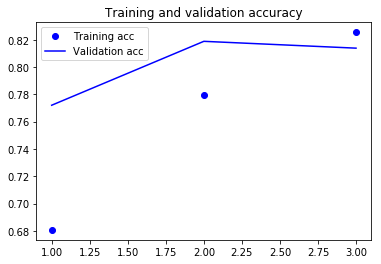

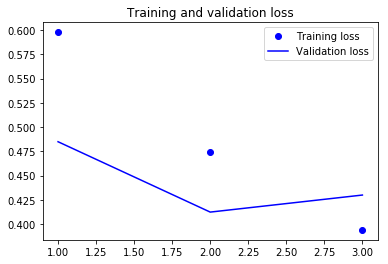

In [31]:
# Visualize model performance without GloVe pre-trained embedding

acc = history_wGloVe.history['acc']
val_acc = history_wGloVe.history['val_acc']
loss = history_wGloVe.history['loss']
val_loss = history_wGloVe.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

GloVe embedding did not perform well with the model. Start overfitting immediately.  

Next, validate a LSTM without using a pre-trained off-the-shelf word embedding.

In [32]:
from keras.layers import LSTM

model = Sequential()
# model.add(Embedding(maxlen, 32))
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(100))
# model.add(LSTM(100, input_shape=(max_words, embedding_dim, maxlen), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=64,
                    validation_split=0.2)


Train on 20000 samples, validate on 5000 samples
Epoch 1/3


   64/20000 [..............................] - ETA: 563s - loss: 0.6927 - acc: 0.4688

  128/20000 [..............................] - ETA: 391s - loss: 0.6949 - acc: 0.4375

  192/20000 [..............................] - ETA: 334s - loss: 0.6944 - acc: 0.4896

  256/20000 [..............................] - ETA: 305s - loss: 0.6937 - acc: 0.4961

  320/20000 [..............................] - ETA: 288s - loss: 0.6939 - acc: 0.4813

  384/20000 [..............................] - ETA: 276s - loss: 0.6936 - acc: 0.4896

  448/20000 [..............................] - ETA: 268s - loss: 0.6932 - acc: 0.5089

  512/20000 [..............................] - ETA: 261s - loss: 0.6932 - acc: 0.5078

  576/20000 [..............................] - ETA: 255s - loss: 0.6929 - acc: 0.5156

  640/20000 [..............................] - ETA: 250s - loss: 0.6925 - acc: 0.5156

  704/20000 [>.............................] - ETA: 247s - loss: 0.6921 - acc: 0.5227

  768/20000 [>.............................] - ETA: 244s - loss: 0.6914 - acc: 0.5286

  832/20000 [>.............................] - ETA: 241s - loss: 0.6907 - acc: 0.5361

  896/20000 [>.............................] - ETA: 238s - loss: 0.6893 - acc: 0.5379

  960/20000 [>.............................] - ETA: 236s - loss: 0.6894 - acc: 0.5375

 1024/20000 [>.............................] - ETA: 234s - loss: 0.6888 - acc: 0.5449

 1088/20000 [>.............................] - ETA: 232s - loss: 0.6880 - acc: 0.5487

 1152/20000 [>.............................] - ETA: 230s - loss: 0.6869 - acc: 0.5608

 1216/20000 [>.............................] - ETA: 228s - loss: 0.6865 - acc: 0.5609

 1280/20000 [>.............................] - ETA: 227s - loss: 0.6859 - acc: 0.5617

 1344/20000 [=>............................] - ETA: 225s - loss: 0.6850 - acc: 0.5670

 1408/20000 [=>............................] - ETA: 224s - loss: 0.6845 - acc: 0.5710

 1472/20000 [=>............................] - ETA: 222s - loss: 0.6831 - acc: 0.5734

 1536/20000 [=>............................] - ETA: 221s - loss: 0.6814 - acc: 0.5781

 1600/20000 [=>............................] - ETA: 220s - loss: 0.6790 - acc: 0.5819

 1664/20000 [=>............................] - ETA: 219s - loss: 0.6824 - acc: 0.5829

 1728/20000 [=>............................] - ETA: 217s - loss: 0.6824 - acc: 0.5816

 1792/20000 [=>............................] - ETA: 216s - loss: 0.6818 - acc: 0.5809

 1856/20000 [=>............................] - ETA: 215s - loss: 0.6807 - acc: 0.5846

 1920/20000 [=>............................] - ETA: 214s - loss: 0.6802 - acc: 0.5839

 1984/20000 [=>............................] - ETA: 213s - loss: 0.6797 - acc: 0.5827

 2048/20000 [==>...........................] - ETA: 212s - loss: 0.6781 - acc: 0.5854

 2112/20000 [==>...........................] - ETA: 211s - loss: 0.6771 - acc: 0.5866

 2176/20000 [==>...........................] - ETA: 210s - loss: 0.6764 - acc: 0.5882

 2240/20000 [==>...........................] - ETA: 209s - loss: 0.6753 - acc: 0.5906

 2304/20000 [==>...........................] - ETA: 208s - loss: 0.6740 - acc: 0.5938

 2368/20000 [==>...........................] - ETA: 207s - loss: 0.6718 - acc: 0.5988

 2432/20000 [==>...........................] - ETA: 206s - loss: 0.6704 - acc: 0.6003

 2496/20000 [==>...........................] - ETA: 205s - loss: 0.6678 - acc: 0.6042

 2560/20000 [==>...........................] - ETA: 204s - loss: 0.6667 - acc: 0.6055

 2624/20000 [==>...........................] - ETA: 203s - loss: 0.6640 - acc: 0.6120

 2688/20000 [===>..........................] - ETA: 202s - loss: 0.6629 - acc: 0.6142

 2752/20000 [===>..........................] - ETA: 201s - loss: 0.6606 - acc: 0.6174

 2816/20000 [===>..........................] - ETA: 200s - loss: 0.6556 - acc: 0.6232

 2880/20000 [===>..........................] - ETA: 199s - loss: 0.6516 - acc: 0.6267

 2944/20000 [===>..........................] - ETA: 198s - loss: 0.6485 - acc: 0.6291

 3008/20000 [===>..........................] - ETA: 198s - loss: 0.6450 - acc: 0.6320

 3072/20000 [===>..........................] - ETA: 197s - loss: 0.6434 - acc: 0.6341

 3136/20000 [===>..........................] - ETA: 196s - loss: 0.6461 - acc: 0.6368

 3200/20000 [===>..........................] - ETA: 195s - loss: 0.6428 - acc: 0.6400

 3264/20000 [===>..........................] - ETA: 194s - loss: 0.6435 - acc: 0.6400

 3328/20000 [===>..........................] - ETA: 193s - loss: 0.6425 - acc: 0.6421

 3392/20000 [====>.........................] - ETA: 192s - loss: 0.6416 - acc: 0.6439

 3456/20000 [====>.........................] - ETA: 191s - loss: 0.6395 - acc: 0.6470

 3520/20000 [====>.........................] - ETA: 191s - loss: 0.6367 - acc: 0.6497

 3584/20000 [====>.........................] - ETA: 190s - loss: 0.6345 - acc: 0.6512

 3648/20000 [====>.........................] - ETA: 189s - loss: 0.6329 - acc: 0.6535

 3712/20000 [====>.........................] - ETA: 188s - loss: 0.6304 - acc: 0.6552

 3776/20000 [====>.........................] - ETA: 187s - loss: 0.6288 - acc: 0.6573

 3840/20000 [====>.........................] - ETA: 187s - loss: 0.6289 - acc: 0.6573

 3904/20000 [====>.........................] - ETA: 186s - loss: 0.6274 - acc: 0.6593

 3968/20000 [====>.........................] - ETA: 185s - loss: 0.6260 - acc: 0.6610

 4032/20000 [=====>........................] - ETA: 184s - loss: 0.6240 - acc: 0.6634

 4096/20000 [=====>........................] - ETA: 183s - loss: 0.6231 - acc: 0.6643

 4160/20000 [=====>........................] - ETA: 183s - loss: 0.6217 - acc: 0.6654

 4224/20000 [=====>........................] - ETA: 182s - loss: 0.6197 - acc: 0.6676

 4288/20000 [=====>........................] - ETA: 181s - loss: 0.6181 - acc: 0.6686

 4352/20000 [=====>........................] - ETA: 180s - loss: 0.6172 - acc: 0.6693

 4416/20000 [=====>........................] - ETA: 179s - loss: 0.6158 - acc: 0.6703

 4480/20000 [=====>........................] - ETA: 179s - loss: 0.6134 - acc: 0.6721

 4544/20000 [=====>........................] - ETA: 178s - loss: 0.6116 - acc: 0.6741

 4608/20000 [=====>........................] - ETA: 177s - loss: 0.6119 - acc: 0.6745

 4672/20000 [======>.......................] - ETA: 176s - loss: 0.6119 - acc: 0.6747

 4736/20000 [======>.......................] - ETA: 175s - loss: 0.6107 - acc: 0.6761

 4800/20000 [======>.......................] - ETA: 175s - loss: 0.6103 - acc: 0.6767

 4864/20000 [======>.......................] - ETA: 174s - loss: 0.6086 - acc: 0.6791

 4928/20000 [======>.......................] - ETA: 173s - loss: 0.6069 - acc: 0.6806

 4992/20000 [======>.......................] - ETA: 172s - loss: 0.6055 - acc: 0.6813

 5056/20000 [======>.......................] - ETA: 171s - loss: 0.6034 - acc: 0.6828

 5120/20000 [======>.......................] - ETA: 171s - loss: 0.6021 - acc: 0.6832

 5184/20000 [======>.......................] - ETA: 170s - loss: 0.6003 - acc: 0.6850

 5248/20000 [======>.......................] - ETA: 169s - loss: 0.5986 - acc: 0.6864

 5312/20000 [======>.......................] - ETA: 168s - loss: 0.5966 - acc: 0.6883

 5376/20000 [=======>......................] - ETA: 168s - loss: 0.5945 - acc: 0.6895

 5440/20000 [=======>......................] - ETA: 167s - loss: 0.5935 - acc: 0.6901

 5504/20000 [=======>......................] - ETA: 166s - loss: 0.5916 - acc: 0.6910

 5568/20000 [=======>......................] - ETA: 165s - loss: 0.5910 - acc: 0.6916

 5632/20000 [=======>......................] - ETA: 164s - loss: 0.5899 - acc: 0.6926

 5696/20000 [=======>......................] - ETA: 164s - loss: 0.5894 - acc: 0.6929

 5760/20000 [=======>......................] - ETA: 163s - loss: 0.5874 - acc: 0.6939

 5824/20000 [=======>......................] - ETA: 162s - loss: 0.5850 - acc: 0.6961

 5888/20000 [=======>......................] - ETA: 161s - loss: 0.5831 - acc: 0.6974

 5952/20000 [=======>......................] - ETA: 161s - loss: 0.5801 - acc: 0.6998

 6016/20000 [========>.....................] - ETA: 160s - loss: 0.5821 - acc: 0.6988

 6080/20000 [========>.....................] - ETA: 159s - loss: 0.5806 - acc: 0.7007

 6144/20000 [========>.....................] - ETA: 158s - loss: 0.5794 - acc: 0.7017

 6208/20000 [========>.....................] - ETA: 158s - loss: 0.5779 - acc: 0.7022

 6272/20000 [========>.....................] - ETA: 157s - loss: 0.5763 - acc: 0.7033

 6336/20000 [========>.....................] - ETA: 156s - loss: 0.5745 - acc: 0.7045

 6400/20000 [========>.....................] - ETA: 155s - loss: 0.5724 - acc: 0.7063

 6464/20000 [========>.....................] - ETA: 155s - loss: 0.5702 - acc: 0.7076

 6528/20000 [========>.....................] - ETA: 154s - loss: 0.5695 - acc: 0.7082

 6592/20000 [========>.....................] - ETA: 153s - loss: 0.5686 - acc: 0.7093

 6656/20000 [========>.....................] - ETA: 152s - loss: 0.5674 - acc: 0.7100

 6720/20000 [=========>....................] - ETA: 152s - loss: 0.5668 - acc: 0.7104

 6784/20000 [=========>....................] - ETA: 151s - loss: 0.5657 - acc: 0.7108

 6848/20000 [=========>....................] - ETA: 150s - loss: 0.5643 - acc: 0.7116

 6912/20000 [=========>....................] - ETA: 149s - loss: 0.5628 - acc: 0.7127

 6976/20000 [=========>....................] - ETA: 149s - loss: 0.5617 - acc: 0.7134

 7040/20000 [=========>....................] - ETA: 148s - loss: 0.5596 - acc: 0.7149

 7104/20000 [=========>....................] - ETA: 147s - loss: 0.5583 - acc: 0.7162

 7168/20000 [=========>....................] - ETA: 146s - loss: 0.5560 - acc: 0.7178

 7232/20000 [=========>....................] - ETA: 146s - loss: 0.5663 - acc: 0.7154

 7296/20000 [=========>....................] - ETA: 145s - loss: 0.5657 - acc: 0.7160

 7360/20000 [==========>...................] - ETA: 144s - loss: 0.5645 - acc: 0.7170

 7424/20000 [==========>...................] - ETA: 143s - loss: 0.5633 - acc: 0.7177

 7488/20000 [==========>...................] - ETA: 143s - loss: 0.5612 - acc: 0.7192

 7552/20000 [==========>...................] - ETA: 142s - loss: 0.5596 - acc: 0.7199

 7616/20000 [==========>...................] - ETA: 141s - loss: 0.5587 - acc: 0.7205

 7680/20000 [==========>...................] - ETA: 140s - loss: 0.5574 - acc: 0.7215

 7744/20000 [==========>...................] - ETA: 140s - loss: 0.5560 - acc: 0.7222

 7808/20000 [==========>...................] - ETA: 139s - loss: 0.5538 - acc: 0.7239

 7872/20000 [==========>...................] - ETA: 138s - loss: 0.5524 - acc: 0.7250

 7936/20000 [==========>...................] - ETA: 137s - loss: 0.5523 - acc: 0.7258

 8000/20000 [===========>..................] - ETA: 137s - loss: 0.5521 - acc: 0.7259

 8064/20000 [===========>..................] - ETA: 136s - loss: 0.5510 - acc: 0.7266

 8128/20000 [===========>..................] - ETA: 135s - loss: 0.5501 - acc: 0.7269

 8192/20000 [===========>..................] - ETA: 134s - loss: 0.5496 - acc: 0.7272

 8256/20000 [===========>..................] - ETA: 134s - loss: 0.5490 - acc: 0.7276

 8320/20000 [===========>..................] - ETA: 133s - loss: 0.5481 - acc: 0.7284

 8384/20000 [===========>..................] - ETA: 132s - loss: 0.5470 - acc: 0.7292

 8448/20000 [===========>..................] - ETA: 131s - loss: 0.5457 - acc: 0.7301

 8512/20000 [===========>..................] - ETA: 131s - loss: 0.5444 - acc: 0.7311

 8576/20000 [===========>..................] - ETA: 130s - loss: 0.5425 - acc: 0.7324

 8640/20000 [===========>..................] - ETA: 129s - loss: 0.5413 - acc: 0.7332

 8704/20000 [============>.................] - ETA: 128s - loss: 0.5402 - acc: 0.7339

 8768/20000 [============>.................] - ETA: 128s - loss: 0.5388 - acc: 0.7351

 8832/20000 [============>.................] - ETA: 127s - loss: 0.5366 - acc: 0.7363

 8896/20000 [============>.................] - ETA: 126s - loss: 0.5370 - acc: 0.7362

 8960/20000 [============>.................] - ETA: 125s - loss: 0.5373 - acc: 0.7359

 9024/20000 [============>.................] - ETA: 125s - loss: 0.5367 - acc: 0.7361

 9088/20000 [============>.................] - ETA: 124s - loss: 0.5358 - acc: 0.7369

 9152/20000 [============>.................] - ETA: 123s - loss: 0.5360 - acc: 0.7367

 9216/20000 [============>.................] - ETA: 122s - loss: 0.5354 - acc: 0.7372

 9280/20000 [============>.................] - ETA: 122s - loss: 0.5346 - acc: 0.7377

 9344/20000 [=============>................] - ETA: 121s - loss: 0.5339 - acc: 0.7385

 9408/20000 [=============>................] - ETA: 120s - loss: 0.5329 - acc: 0.7395

 9472/20000 [=============>................] - ETA: 119s - loss: 0.5334 - acc: 0.7397

 9536/20000 [=============>................] - ETA: 119s - loss: 0.5325 - acc: 0.7404

 9600/20000 [=============>................] - ETA: 118s - loss: 0.5319 - acc: 0.7406

 9664/20000 [=============>................] - ETA: 117s - loss: 0.5315 - acc: 0.7408

 9728/20000 [=============>................] - ETA: 116s - loss: 0.5310 - acc: 0.7412

 9792/20000 [=============>................] - ETA: 116s - loss: 0.5299 - acc: 0.7419

 9856/20000 [=============>................] - ETA: 115s - loss: 0.5299 - acc: 0.7423

 9920/20000 [=============>................] - ETA: 114s - loss: 0.5292 - acc: 0.7426

 9984/20000 [=============>................] - ETA: 114s - loss: 0.5274 - acc: 0.7439

10048/20000 [==============>...............] - ETA: 113s - loss: 0.5264 - acc: 0.7446

10112/20000 [==============>...............] - ETA: 112s - loss: 0.5252 - acc: 0.7454

10176/20000 [==============>...............] - ETA: 111s - loss: 0.5235 - acc: 0.7464

10240/20000 [==============>...............] - ETA: 111s - loss: 0.5219 - acc: 0.7473

10304/20000 [==============>...............] - ETA: 110s - loss: 0.5217 - acc: 0.7471

10368/20000 [==============>...............] - ETA: 109s - loss: 0.5207 - acc: 0.7480

10432/20000 [==============>...............] - ETA: 108s - loss: 0.5192 - acc: 0.7488

10496/20000 [==============>...............] - ETA: 108s - loss: 0.5181 - acc: 0.7495

10560/20000 [==============>...............] - ETA: 107s - loss: 0.5167 - acc: 0.7505

10624/20000 [==============>...............] - ETA: 106s - loss: 0.5158 - acc: 0.7509

10688/20000 [===============>..............] - ETA: 105s - loss: 0.5152 - acc: 0.7515

10752/20000 [===============>..............] - ETA: 105s - loss: 0.5138 - acc: 0.7523

10816/20000 [===============>..............] - ETA: 104s - loss: 0.5135 - acc: 0.7526

10880/20000 [===============>..............] - ETA: 103s - loss: 0.5133 - acc: 0.7528

10944/20000 [===============>..............] - ETA: 102s - loss: 0.5122 - acc: 0.7536

11008/20000 [===============>..............] - ETA: 102s - loss: 0.5115 - acc: 0.7538

11072/20000 [===============>..............] - ETA: 101s - loss: 0.5108 - acc: 0.7542

11136/20000 [===============>..............] - ETA: 100s - loss: 0.5100 - acc: 0.7545

11200/20000 [===============>..............] - ETA: 100s - loss: 0.5087 - acc: 0.7554

11264/20000 [===============>..............] - ETA: 99s - loss: 0.5074 - acc: 0.7562 

11328/20000 [===============>..............] - ETA: 98s - loss: 0.5154 - acc: 0.7546

11392/20000 [================>.............] - ETA: 97s - loss: 0.5149 - acc: 0.7549

11456/20000 [================>.............] - ETA: 97s - loss: 0.5140 - acc: 0.7552

11520/20000 [================>.............] - ETA: 96s - loss: 0.5130 - acc: 0.7560

11584/20000 [================>.............] - ETA: 95s - loss: 0.5121 - acc: 0.7564

11648/20000 [================>.............] - ETA: 94s - loss: 0.5110 - acc: 0.7571

11712/20000 [================>.............] - ETA: 94s - loss: 0.5100 - acc: 0.7578

11776/20000 [================>.............] - ETA: 93s - loss: 0.5095 - acc: 0.7582

11840/20000 [================>.............] - ETA: 92s - loss: 0.5092 - acc: 0.7586

11904/20000 [================>.............] - ETA: 92s - loss: 0.5081 - acc: 0.7592

11968/20000 [================>.............] - ETA: 91s - loss: 0.5073 - acc: 0.7597

12032/20000 [=================>............] - ETA: 90s - loss: 0.5064 - acc: 0.7601

12096/20000 [=================>............] - ETA: 89s - loss: 0.5063 - acc: 0.7604

12160/20000 [=================>............] - ETA: 89s - loss: 0.5051 - acc: 0.7613

12224/20000 [=================>............] - ETA: 88s - loss: 0.5042 - acc: 0.7620

12288/20000 [=================>............] - ETA: 87s - loss: 0.5032 - acc: 0.7625

12352/20000 [=================>............] - ETA: 86s - loss: 0.5025 - acc: 0.7628

12416/20000 [=================>............] - ETA: 86s - loss: 0.5014 - acc: 0.7634

12480/20000 [=================>............] - ETA: 85s - loss: 0.5004 - acc: 0.7639

12544/20000 [=================>............] - ETA: 84s - loss: 0.4995 - acc: 0.7645

12608/20000 [=================>............] - ETA: 83s - loss: 0.4985 - acc: 0.7652

12672/20000 [==================>...........] - ETA: 83s - loss: 0.4987 - acc: 0.7652

12736/20000 [==================>...........] - ETA: 82s - loss: 0.4979 - acc: 0.7661

12800/20000 [==================>...........] - ETA: 81s - loss: 0.4968 - acc: 0.7668

12864/20000 [==================>...........] - ETA: 81s - loss: 0.4961 - acc: 0.7670

12928/20000 [==================>...........] - ETA: 80s - loss: 0.4957 - acc: 0.7674

12992/20000 [==================>...........] - ETA: 79s - loss: 0.4953 - acc: 0.7675

13056/20000 [==================>...........] - ETA: 78s - loss: 0.4945 - acc: 0.7679

13120/20000 [==================>...........] - ETA: 78s - loss: 0.4937 - acc: 0.7683

13184/20000 [==================>...........] - ETA: 77s - loss: 0.4933 - acc: 0.7685

13248/20000 [==================>...........] - ETA: 76s - loss: 0.4928 - acc: 0.7689

13312/20000 [==================>...........] - ETA: 75s - loss: 0.4930 - acc: 0.7689

13376/20000 [===================>..........] - ETA: 75s - loss: 0.4920 - acc: 0.7695

13440/20000 [===================>..........] - ETA: 74s - loss: 0.4913 - acc: 0.7698

13504/20000 [===================>..........] - ETA: 73s - loss: 0.4905 - acc: 0.7702

13568/20000 [===================>..........] - ETA: 73s - loss: 0.4898 - acc: 0.7707

13632/20000 [===================>..........] - ETA: 72s - loss: 0.4892 - acc: 0.7711

13696/20000 [===================>..........] - ETA: 71s - loss: 0.4884 - acc: 0.7715

13760/20000 [===================>..........] - ETA: 70s - loss: 0.4877 - acc: 0.7719

13824/20000 [===================>..........] - ETA: 70s - loss: 0.4874 - acc: 0.7721

13888/20000 [===================>..........] - ETA: 69s - loss: 0.4874 - acc: 0.7721

13952/20000 [===================>..........] - ETA: 68s - loss: 0.4869 - acc: 0.7725

14016/20000 [====================>.........] - ETA: 67s - loss: 0.4871 - acc: 0.7724

14080/20000 [====================>.........] - ETA: 67s - loss: 0.4868 - acc: 0.7726

14144/20000 [====================>.........] - ETA: 66s - loss: 0.4859 - acc: 0.7732

14208/20000 [====================>.........] - ETA: 65s - loss: 0.4853 - acc: 0.7736

14272/20000 [====================>.........] - ETA: 64s - loss: 0.4846 - acc: 0.7738

14336/20000 [====================>.........] - ETA: 64s - loss: 0.4849 - acc: 0.7737

14400/20000 [====================>.........] - ETA: 63s - loss: 0.4845 - acc: 0.7741

14464/20000 [====================>.........] - ETA: 62s - loss: 0.4844 - acc: 0.7743

14528/20000 [====================>.........] - ETA: 62s - loss: 0.4840 - acc: 0.7744

14592/20000 [====================>.........] - ETA: 61s - loss: 0.4835 - acc: 0.7748

14656/20000 [====================>.........] - ETA: 60s - loss: 0.4832 - acc: 0.7751

14720/20000 [=====================>........] - ETA: 59s - loss: 0.4827 - acc: 0.7753

14784/20000 [=====================>........] - ETA: 59s - loss: 0.4816 - acc: 0.7758

14848/20000 [=====================>........] - ETA: 58s - loss: 0.4810 - acc: 0.7761

14912/20000 [=====================>........] - ETA: 57s - loss: 0.4804 - acc: 0.7767

14976/20000 [=====================>........] - ETA: 56s - loss: 0.4796 - acc: 0.7771

15040/20000 [=====================>........] - ETA: 56s - loss: 0.4793 - acc: 0.7773

15104/20000 [=====================>........] - ETA: 55s - loss: 0.4781 - acc: 0.7780

15168/20000 [=====================>........] - ETA: 54s - loss: 0.4777 - acc: 0.7784

15232/20000 [=====================>........] - ETA: 54s - loss: 0.4774 - acc: 0.7788

15296/20000 [=====================>........] - ETA: 53s - loss: 0.4813 - acc: 0.7781

15360/20000 [======================>.......] - ETA: 52s - loss: 0.4835 - acc: 0.7775

15424/20000 [======================>.......] - ETA: 51s - loss: 0.4831 - acc: 0.7777

15488/20000 [======================>.......] - ETA: 51s - loss: 0.4830 - acc: 0.7778

15552/20000 [======================>.......] - ETA: 50s - loss: 0.4832 - acc: 0.7776

15616/20000 [======================>.......] - ETA: 49s - loss: 0.4831 - acc: 0.7774

15680/20000 [======================>.......] - ETA: 48s - loss: 0.4825 - acc: 0.7778

15744/20000 [======================>.......] - ETA: 48s - loss: 0.4820 - acc: 0.7782

15808/20000 [======================>.......] - ETA: 47s - loss: 0.4813 - acc: 0.7787

15872/20000 [======================>.......] - ETA: 46s - loss: 0.4807 - acc: 0.7789

15936/20000 [======================>.......] - ETA: 46s - loss: 0.4805 - acc: 0.7790

16000/20000 [=======================>......] - ETA: 45s - loss: 0.4799 - acc: 0.7794

16064/20000 [=======================>......] - ETA: 44s - loss: 0.4791 - acc: 0.7798

16128/20000 [=======================>......] - ETA: 43s - loss: 0.4786 - acc: 0.7799

16192/20000 [=======================>......] - ETA: 43s - loss: 0.4783 - acc: 0.7801

16256/20000 [=======================>......] - ETA: 42s - loss: 0.4779 - acc: 0.7803

16320/20000 [=======================>......] - ETA: 41s - loss: 0.4776 - acc: 0.7806

16384/20000 [=======================>......] - ETA: 40s - loss: 0.4766 - acc: 0.7812

16448/20000 [=======================>......] - ETA: 40s - loss: 0.4767 - acc: 0.7812

16512/20000 [=======================>......] - ETA: 39s - loss: 0.4761 - acc: 0.7816

16576/20000 [=======================>......] - ETA: 38s - loss: 0.4756 - acc: 0.7819

16640/20000 [=======================>......] - ETA: 38s - loss: 0.4751 - acc: 0.7825

16704/20000 [========================>.....] - ETA: 37s - loss: 0.4747 - acc: 0.7827

16768/20000 [========================>.....] - ETA: 36s - loss: 0.4739 - acc: 0.7832

16832/20000 [========================>.....] - ETA: 35s - loss: 0.4735 - acc: 0.7834

16896/20000 [========================>.....] - ETA: 35s - loss: 0.4728 - acc: 0.7839

16960/20000 [========================>.....] - ETA: 34s - loss: 0.4725 - acc: 0.7842

17024/20000 [========================>.....] - ETA: 33s - loss: 0.4719 - acc: 0.7846

17088/20000 [========================>.....] - ETA: 32s - loss: 0.4713 - acc: 0.7852

17152/20000 [========================>.....] - ETA: 32s - loss: 0.4708 - acc: 0.7854

17216/20000 [========================>.....] - ETA: 31s - loss: 0.4712 - acc: 0.7853

17280/20000 [========================>.....] - ETA: 30s - loss: 0.4710 - acc: 0.7856

17344/20000 [=========================>....] - ETA: 30s - loss: 0.4703 - acc: 0.7861

17408/20000 [=========================>....] - ETA: 29s - loss: 0.4698 - acc: 0.7863

17472/20000 [=========================>....] - ETA: 28s - loss: 0.4692 - acc: 0.7867

17536/20000 [=========================>....] - ETA: 27s - loss: 0.4685 - acc: 0.7872

17600/20000 [=========================>....] - ETA: 27s - loss: 0.4678 - acc: 0.7877

17664/20000 [=========================>....] - ETA: 26s - loss: 0.4670 - acc: 0.7882

17728/20000 [=========================>....] - ETA: 25s - loss: 0.4669 - acc: 0.7883

17792/20000 [=========================>....] - ETA: 25s - loss: 0.4660 - acc: 0.7888

17856/20000 [=========================>....] - ETA: 24s - loss: 0.4655 - acc: 0.7891

17920/20000 [=========================>....] - ETA: 23s - loss: 0.4650 - acc: 0.7894

17984/20000 [=========================>....] - ETA: 22s - loss: 0.4645 - acc: 0.7896

18048/20000 [==========================>...] - ETA: 22s - loss: 0.4641 - acc: 0.7898

18112/20000 [==========================>...] - ETA: 21s - loss: 0.4636 - acc: 0.7901

18176/20000 [==========================>...] - ETA: 20s - loss: 0.4658 - acc: 0.7897

18240/20000 [==========================>...] - ETA: 19s - loss: 0.4653 - acc: 0.7899

18304/20000 [==========================>...] - ETA: 19s - loss: 0.4651 - acc: 0.7900

18368/20000 [==========================>...] - ETA: 18s - loss: 0.4645 - acc: 0.7905

18432/20000 [==========================>...] - ETA: 17s - loss: 0.4636 - acc: 0.7909

18496/20000 [==========================>...] - ETA: 17s - loss: 0.4631 - acc: 0.7910

18560/20000 [==========================>...] - ETA: 16s - loss: 0.4622 - acc: 0.7915

18624/20000 [==========================>...] - ETA: 15s - loss: 0.4621 - acc: 0.7916

18688/20000 [===========================>..] - ETA: 14s - loss: 0.4616 - acc: 0.7919

18752/20000 [===========================>..] - ETA: 14s - loss: 0.4613 - acc: 0.7921

18816/20000 [===========================>..] - ETA: 13s - loss: 0.4610 - acc: 0.7923

18880/20000 [===========================>..] - ETA: 12s - loss: 0.4606 - acc: 0.7923

18944/20000 [===========================>..] - ETA: 11s - loss: 0.4603 - acc: 0.7925

19008/20000 [===========================>..] - ETA: 11s - loss: 0.4600 - acc: 0.7927

19072/20000 [===========================>..] - ETA: 10s - loss: 0.4597 - acc: 0.7928

19136/20000 [===========================>..] - ETA: 9s - loss: 0.4591 - acc: 0.7931 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.4588 - acc: 0.7932

19264/20000 [===========================>..] - ETA: 8s - loss: 0.4586 - acc: 0.7933

19328/20000 [===========================>..] - ETA: 7s - loss: 0.4584 - acc: 0.7935

19392/20000 [============================>.] - ETA: 6s - loss: 0.4579 - acc: 0.7938

19456/20000 [============================>.] - ETA: 6s - loss: 0.4577 - acc: 0.7939

19520/20000 [============================>.] - ETA: 5s - loss: 0.4572 - acc: 0.7942

19584/20000 [============================>.] - ETA: 4s - loss: 0.4570 - acc: 0.7943

19648/20000 [============================>.] - ETA: 3s - loss: 0.4567 - acc: 0.7944

19712/20000 [============================>.] - ETA: 3s - loss: 0.4563 - acc: 0.7947

19776/20000 [============================>.] - ETA: 2s - loss: 0.4557 - acc: 0.7950

19840/20000 [============================>.] - ETA: 1s - loss: 0.4553 - acc: 0.7954

19904/20000 [============================>.] - ETA: 1s - loss: 0.4545 - acc: 0.7957

19968/20000 [============================>.] - ETA: 0s - loss: 0.4583 - acc: 0.7949

20000/20000 [==============================] - 243s - loss: 0.4579 - acc: 0.7951 - val_loss: 0.3602 - val_acc: 0.8522


Epoch 2/3


   64/20000 [..............................] - ETA: 226s - loss: 0.3548 - acc: 0.8594

  128/20000 [..............................] - ETA: 224s - loss: 0.3517 - acc: 0.8438

  192/20000 [..............................] - ETA: 224s - loss: 0.3241 - acc: 0.8594

  256/20000 [..............................] - ETA: 224s - loss: 0.3203 - acc: 0.8594

  320/20000 [..............................] - ETA: 223s - loss: 0.3060 - acc: 0.8719

  384/20000 [..............................] - ETA: 223s - loss: 0.2955 - acc: 0.8802

  448/20000 [..............................] - ETA: 222s - loss: 0.2870 - acc: 0.8817

  512/20000 [..............................] - ETA: 221s - loss: 0.2893 - acc: 0.8789

  576/20000 [..............................] - ETA: 220s - loss: 0.2989 - acc: 0.8785

  640/20000 [..............................] - ETA: 220s - loss: 0.3000 - acc: 0.8766

  704/20000 [>.............................] - ETA: 219s - loss: 0.2945 - acc: 0.8821

  768/20000 [>.............................] - ETA: 219s - loss: 0.2920 - acc: 0.8841

  832/20000 [>.............................] - ETA: 218s - loss: 0.2896 - acc: 0.8834

  896/20000 [>.............................] - ETA: 217s - loss: 0.2883 - acc: 0.8850

  960/20000 [>.............................] - ETA: 217s - loss: 0.2791 - acc: 0.8896

 1024/20000 [>.............................] - ETA: 216s - loss: 0.2676 - acc: 0.8945

 1088/20000 [>.............................] - ETA: 215s - loss: 0.3421 - acc: 0.8750

 1152/20000 [>.............................] - ETA: 215s - loss: 0.3421 - acc: 0.8724

 1216/20000 [>.............................] - ETA: 214s - loss: 0.3426 - acc: 0.8701

 1280/20000 [>.............................] - ETA: 213s - loss: 0.3423 - acc: 0.8688

 1344/20000 [=>............................] - ETA: 212s - loss: 0.3444 - acc: 0.8661

 1408/20000 [=>............................] - ETA: 212s - loss: 0.3400 - acc: 0.8686

 1472/20000 [=>............................] - ETA: 211s - loss: 0.3389 - acc: 0.8689

 1536/20000 [=>............................] - ETA: 210s - loss: 0.3416 - acc: 0.8678

 1600/20000 [=>............................] - ETA: 210s - loss: 0.3371 - acc: 0.8694

 1664/20000 [=>............................] - ETA: 209s - loss: 0.3341 - acc: 0.8708

 1728/20000 [=>............................] - ETA: 209s - loss: 0.3298 - acc: 0.8721

 1792/20000 [=>............................] - ETA: 208s - loss: 0.3303 - acc: 0.8694

 1856/20000 [=>............................] - ETA: 207s - loss: 0.3231 - acc: 0.8734

 1920/20000 [=>............................] - ETA: 206s - loss: 0.3179 - acc: 0.8755

 1984/20000 [=>............................] - ETA: 206s - loss: 0.3125 - acc: 0.8785

 2048/20000 [==>...........................] - ETA: 205s - loss: 0.3068 - acc: 0.8813

 2112/20000 [==>...........................] - ETA: 204s - loss: 0.3088 - acc: 0.8797

 2176/20000 [==>...........................] - ETA: 203s - loss: 0.3111 - acc: 0.8791

 2240/20000 [==>...........................] - ETA: 203s - loss: 0.3255 - acc: 0.8750

 2304/20000 [==>...........................] - ETA: 202s - loss: 0.3234 - acc: 0.8767

 2368/20000 [==>...........................] - ETA: 201s - loss: 0.3225 - acc: 0.8775

 2432/20000 [==>...........................] - ETA: 200s - loss: 0.3185 - acc: 0.8795

 2496/20000 [==>...........................] - ETA: 200s - loss: 0.3166 - acc: 0.8802

 2560/20000 [==>...........................] - ETA: 199s - loss: 0.3154 - acc: 0.8805

 2624/20000 [==>...........................] - ETA: 198s - loss: 0.3138 - acc: 0.8811

 2688/20000 [===>..........................] - ETA: 197s - loss: 0.3132 - acc: 0.8810

 2752/20000 [===>..........................] - ETA: 197s - loss: 0.3132 - acc: 0.8808

 2816/20000 [===>..........................] - ETA: 196s - loss: 0.3117 - acc: 0.8814

 2880/20000 [===>..........................] - ETA: 195s - loss: 0.3110 - acc: 0.8816

 2944/20000 [===>..........................] - ETA: 194s - loss: 0.3086 - acc: 0.8828

 3008/20000 [===>..........................] - ETA: 194s - loss: 0.3070 - acc: 0.8833

 3072/20000 [===>..........................] - ETA: 193s - loss: 0.3050 - acc: 0.8835

 3136/20000 [===>..........................] - ETA: 192s - loss: 0.3040 - acc: 0.8839

 3200/20000 [===>..........................] - ETA: 191s - loss: 0.3025 - acc: 0.8844

 3264/20000 [===>..........................] - ETA: 191s - loss: 0.3004 - acc: 0.8848

 3328/20000 [===>..........................] - ETA: 190s - loss: 0.3003 - acc: 0.8843

 3392/20000 [====>.........................] - ETA: 189s - loss: 0.2998 - acc: 0.8844

 3456/20000 [====>.........................] - ETA: 188s - loss: 0.2971 - acc: 0.8857

 3520/20000 [====>.........................] - ETA: 188s - loss: 0.2956 - acc: 0.8864

 3584/20000 [====>.........................] - ETA: 187s - loss: 0.2959 - acc: 0.8867

 3648/20000 [====>.........................] - ETA: 186s - loss: 0.2974 - acc: 0.8857

 3712/20000 [====>.........................] - ETA: 186s - loss: 0.2967 - acc: 0.8863

 3776/20000 [====>.........................] - ETA: 185s - loss: 0.2944 - acc: 0.8874

 3840/20000 [====>.........................] - ETA: 184s - loss: 0.2948 - acc: 0.8875

 3904/20000 [====>.........................] - ETA: 183s - loss: 0.2936 - acc: 0.8881

 3968/20000 [====>.........................] - ETA: 183s - loss: 0.2933 - acc: 0.8884

 4032/20000 [=====>........................] - ETA: 182s - loss: 0.2924 - acc: 0.8889

 4096/20000 [=====>........................] - ETA: 181s - loss: 0.2905 - acc: 0.8901

 4160/20000 [=====>........................] - ETA: 180s - loss: 0.2893 - acc: 0.8906

 4224/20000 [=====>........................] - ETA: 180s - loss: 0.2882 - acc: 0.8911

 4288/20000 [=====>........................] - ETA: 179s - loss: 0.2869 - acc: 0.8918

 4352/20000 [=====>........................] - ETA: 178s - loss: 0.2862 - acc: 0.8920

 4416/20000 [=====>........................] - ETA: 177s - loss: 0.2879 - acc: 0.8913

 4480/20000 [=====>........................] - ETA: 177s - loss: 0.2855 - acc: 0.8920

 4544/20000 [=====>........................] - ETA: 176s - loss: 0.2856 - acc: 0.8919

 4608/20000 [=====>........................] - ETA: 175s - loss: 0.2846 - acc: 0.8926

 4672/20000 [======>.......................] - ETA: 175s - loss: 0.2846 - acc: 0.8928

 4736/20000 [======>.......................] - ETA: 174s - loss: 0.2845 - acc: 0.8929

 4800/20000 [======>.......................] - ETA: 173s - loss: 0.2829 - acc: 0.8938

 4864/20000 [======>.......................] - ETA: 172s - loss: 0.2827 - acc: 0.8939

 4928/20000 [======>.......................] - ETA: 172s - loss: 0.2896 - acc: 0.8922

 4992/20000 [======>.......................] - ETA: 171s - loss: 0.2903 - acc: 0.8918

 5056/20000 [======>.......................] - ETA: 170s - loss: 0.2909 - acc: 0.8910

 5120/20000 [======>.......................] - ETA: 169s - loss: 0.2905 - acc: 0.8914

 5184/20000 [======>.......................] - ETA: 169s - loss: 0.2912 - acc: 0.8912

 5248/20000 [======>.......................] - ETA: 168s - loss: 0.2927 - acc: 0.8904

 5312/20000 [======>.......................] - ETA: 167s - loss: 0.2920 - acc: 0.8906

 5376/20000 [=======>......................] - ETA: 166s - loss: 0.2916 - acc: 0.8906

 5440/20000 [=======>......................] - ETA: 166s - loss: 0.2915 - acc: 0.8908

 5504/20000 [=======>......................] - ETA: 165s - loss: 0.2900 - acc: 0.8914

 5568/20000 [=======>......................] - ETA: 164s - loss: 0.2901 - acc: 0.8912

 5632/20000 [=======>......................] - ETA: 163s - loss: 0.2902 - acc: 0.8912

 5696/20000 [=======>......................] - ETA: 163s - loss: 0.2908 - acc: 0.8904

 5760/20000 [=======>......................] - ETA: 162s - loss: 0.2921 - acc: 0.8892

 5824/20000 [=======>......................] - ETA: 161s - loss: 0.2932 - acc: 0.8884

 5888/20000 [=======>......................] - ETA: 160s - loss: 0.2943 - acc: 0.8876

 5952/20000 [=======>......................] - ETA: 160s - loss: 0.2953 - acc: 0.8873

 6016/20000 [========>.....................] - ETA: 159s - loss: 0.2961 - acc: 0.8865

 6080/20000 [========>.....................] - ETA: 158s - loss: 0.2960 - acc: 0.8868

 6144/20000 [========>.....................] - ETA: 157s - loss: 0.2968 - acc: 0.8862

 6208/20000 [========>.....................] - ETA: 157s - loss: 0.2971 - acc: 0.8863

 6272/20000 [========>.....................] - ETA: 156s - loss: 0.2968 - acc: 0.8860

 6336/20000 [========>.....................] - ETA: 155s - loss: 0.2964 - acc: 0.8862

 6400/20000 [========>.....................] - ETA: 155s - loss: 0.2961 - acc: 0.8866

 6464/20000 [========>.....................] - ETA: 154s - loss: 0.2947 - acc: 0.8872

 6528/20000 [========>.....................] - ETA: 153s - loss: 0.2932 - acc: 0.8879

 6592/20000 [========>.....................] - ETA: 152s - loss: 0.2926 - acc: 0.8880

 6656/20000 [========>.....................] - ETA: 152s - loss: 0.2914 - acc: 0.8884

 6720/20000 [=========>....................] - ETA: 151s - loss: 0.2942 - acc: 0.8876

 6784/20000 [=========>....................] - ETA: 150s - loss: 0.2945 - acc: 0.8877

 6848/20000 [=========>....................] - ETA: 149s - loss: 0.2934 - acc: 0.8881

 6912/20000 [=========>....................] - ETA: 149s - loss: 0.2926 - acc: 0.8885

 6976/20000 [=========>....................] - ETA: 148s - loss: 0.2932 - acc: 0.8883

 7040/20000 [=========>....................] - ETA: 147s - loss: 0.2943 - acc: 0.8878

 7104/20000 [=========>....................] - ETA: 146s - loss: 0.2934 - acc: 0.8882

 7168/20000 [=========>....................] - ETA: 146s - loss: 0.2930 - acc: 0.8884

 7232/20000 [=========>....................] - ETA: 145s - loss: 0.2920 - acc: 0.8887

 7296/20000 [=========>....................] - ETA: 144s - loss: 0.2914 - acc: 0.8893

 7360/20000 [==========>...................] - ETA: 144s - loss: 0.2934 - acc: 0.8887

 7424/20000 [==========>...................] - ETA: 143s - loss: 0.2927 - acc: 0.8893

 7488/20000 [==========>...................] - ETA: 142s - loss: 0.2924 - acc: 0.8893

 7552/20000 [==========>...................] - ETA: 141s - loss: 0.2921 - acc: 0.8893

 7616/20000 [==========>...................] - ETA: 141s - loss: 0.2911 - acc: 0.8897

 7680/20000 [==========>...................] - ETA: 140s - loss: 0.2909 - acc: 0.8897

 7744/20000 [==========>...................] - ETA: 139s - loss: 0.2911 - acc: 0.8897

 7808/20000 [==========>...................] - ETA: 138s - loss: 0.2916 - acc: 0.8893

 7872/20000 [==========>...................] - ETA: 138s - loss: 0.2917 - acc: 0.8892

 7936/20000 [==========>...................] - ETA: 137s - loss: 0.2904 - acc: 0.8896

 8000/20000 [===========>..................] - ETA: 136s - loss: 0.2908 - acc: 0.8895

 8064/20000 [===========>..................] - ETA: 135s - loss: 0.2904 - acc: 0.8898

 8128/20000 [===========>..................] - ETA: 135s - loss: 0.2912 - acc: 0.8895

 8192/20000 [===========>..................] - ETA: 134s - loss: 0.2913 - acc: 0.8892

 8256/20000 [===========>..................] - ETA: 133s - loss: 0.2907 - acc: 0.8893

 8320/20000 [===========>..................] - ETA: 133s - loss: 0.2899 - acc: 0.8897

 8384/20000 [===========>..................] - ETA: 132s - loss: 0.2892 - acc: 0.8899

 8448/20000 [===========>..................] - ETA: 131s - loss: 0.2884 - acc: 0.8902

 8512/20000 [===========>..................] - ETA: 130s - loss: 0.2883 - acc: 0.8902

 8576/20000 [===========>..................] - ETA: 130s - loss: 0.2881 - acc: 0.8903

 8640/20000 [===========>..................] - ETA: 129s - loss: 0.2878 - acc: 0.8902

 8704/20000 [============>.................] - ETA: 128s - loss: 0.2878 - acc: 0.8903

 8768/20000 [============>.................] - ETA: 127s - loss: 0.2867 - acc: 0.8910

 8832/20000 [============>.................] - ETA: 127s - loss: 0.2869 - acc: 0.8909

 8896/20000 [============>.................] - ETA: 126s - loss: 0.2863 - acc: 0.8911

 8960/20000 [============>.................] - ETA: 125s - loss: 0.2890 - acc: 0.8900

 9024/20000 [============>.................] - ETA: 124s - loss: 0.2898 - acc: 0.8895

 9088/20000 [============>.................] - ETA: 124s - loss: 0.2908 - acc: 0.8889

 9152/20000 [============>.................] - ETA: 123s - loss: 0.2912 - acc: 0.8887

 9216/20000 [============>.................] - ETA: 122s - loss: 0.2902 - acc: 0.8891

 9280/20000 [============>.................] - ETA: 122s - loss: 0.2912 - acc: 0.8888

 9344/20000 [=============>................] - ETA: 121s - loss: 0.2921 - acc: 0.8881

 9408/20000 [=============>................] - ETA: 120s - loss: 0.2929 - acc: 0.8878

 9472/20000 [=============>................] - ETA: 119s - loss: 0.2934 - acc: 0.8874

 9536/20000 [=============>................] - ETA: 119s - loss: 0.2935 - acc: 0.8871

 9600/20000 [=============>................] - ETA: 118s - loss: 0.2940 - acc: 0.8867

 9664/20000 [=============>................] - ETA: 117s - loss: 0.2938 - acc: 0.8866

 9728/20000 [=============>................] - ETA: 116s - loss: 0.2929 - acc: 0.8870

 9792/20000 [=============>................] - ETA: 116s - loss: 0.2919 - acc: 0.8875

 9856/20000 [=============>................] - ETA: 115s - loss: 0.2914 - acc: 0.8877

 9920/20000 [=============>................] - ETA: 114s - loss: 0.2928 - acc: 0.8872

 9984/20000 [=============>................] - ETA: 114s - loss: 0.2924 - acc: 0.8874

10048/20000 [==============>...............] - ETA: 113s - loss: 0.2922 - acc: 0.8871

10112/20000 [==============>...............] - ETA: 112s - loss: 0.2930 - acc: 0.8867

10176/20000 [==============>...............] - ETA: 111s - loss: 0.2933 - acc: 0.8863

10240/20000 [==============>...............] - ETA: 111s - loss: 0.2935 - acc: 0.8859

10304/20000 [==============>...............] - ETA: 110s - loss: 0.2934 - acc: 0.8862

10368/20000 [==============>...............] - ETA: 109s - loss: 0.2931 - acc: 0.8864

10432/20000 [==============>...............] - ETA: 108s - loss: 0.2922 - acc: 0.8870

10496/20000 [==============>...............] - ETA: 108s - loss: 0.2919 - acc: 0.8872

10560/20000 [==============>...............] - ETA: 107s - loss: 0.2924 - acc: 0.8871

10624/20000 [==============>...............] - ETA: 106s - loss: 0.2920 - acc: 0.8872

10688/20000 [===============>..............] - ETA: 105s - loss: 0.2917 - acc: 0.8874

10752/20000 [===============>..............] - ETA: 105s - loss: 0.2923 - acc: 0.8870

10816/20000 [===============>..............] - ETA: 104s - loss: 0.2933 - acc: 0.8865

10880/20000 [===============>..............] - ETA: 103s - loss: 0.2937 - acc: 0.8862

10944/20000 [===============>..............] - ETA: 103s - loss: 0.2936 - acc: 0.8861

11008/20000 [===============>..............] - ETA: 102s - loss: 0.2942 - acc: 0.8859

11072/20000 [===============>..............] - ETA: 101s - loss: 0.2944 - acc: 0.8859

11136/20000 [===============>..............] - ETA: 100s - loss: 0.2937 - acc: 0.8861

11200/20000 [===============>..............] - ETA: 100s - loss: 0.2943 - acc: 0.8859

11264/20000 [===============>..............] - ETA: 99s - loss: 0.2944 - acc: 0.8857 

11328/20000 [===============>..............] - ETA: 98s - loss: 0.2950 - acc: 0.8853

11392/20000 [================>.............] - ETA: 97s - loss: 0.2953 - acc: 0.8854

11456/20000 [================>.............] - ETA: 97s - loss: 0.2950 - acc: 0.8856

11520/20000 [================>.............] - ETA: 96s - loss: 0.2949 - acc: 0.8857

11584/20000 [================>.............] - ETA: 95s - loss: 0.2950 - acc: 0.8857

11648/20000 [================>.............] - ETA: 95s - loss: 0.2947 - acc: 0.8857

11712/20000 [================>.............] - ETA: 94s - loss: 0.2948 - acc: 0.8858

11776/20000 [================>.............] - ETA: 93s - loss: 0.2939 - acc: 0.8861

11840/20000 [================>.............] - ETA: 92s - loss: 0.2937 - acc: 0.8862

11904/20000 [================>.............] - ETA: 92s - loss: 0.2938 - acc: 0.8862

11968/20000 [================>.............] - ETA: 91s - loss: 0.2937 - acc: 0.8865

12032/20000 [=================>............] - ETA: 90s - loss: 0.2930 - acc: 0.8869

12096/20000 [=================>............] - ETA: 89s - loss: 0.2928 - acc: 0.8871

12160/20000 [=================>............] - ETA: 89s - loss: 0.2924 - acc: 0.8873

12224/20000 [=================>............] - ETA: 88s - loss: 0.2920 - acc: 0.8874

12288/20000 [=================>............] - ETA: 87s - loss: 0.2922 - acc: 0.8875

12352/20000 [=================>............] - ETA: 86s - loss: 0.2918 - acc: 0.8876

12416/20000 [=================>............] - ETA: 86s - loss: 0.2917 - acc: 0.8875

12480/20000 [=================>............] - ETA: 85s - loss: 0.2917 - acc: 0.8873

12544/20000 [=================>............] - ETA: 84s - loss: 0.2918 - acc: 0.8874

12608/20000 [=================>............] - ETA: 84s - loss: 0.2916 - acc: 0.8875

12672/20000 [==================>...........] - ETA: 83s - loss: 0.2914 - acc: 0.8875

12736/20000 [==================>...........] - ETA: 82s - loss: 0.2916 - acc: 0.8872

12800/20000 [==================>...........] - ETA: 81s - loss: 0.2910 - acc: 0.8876

12864/20000 [==================>...........] - ETA: 81s - loss: 0.2903 - acc: 0.8878

12928/20000 [==================>...........] - ETA: 80s - loss: 0.2898 - acc: 0.8878

12992/20000 [==================>...........] - ETA: 79s - loss: 0.2892 - acc: 0.8881

13056/20000 [==================>...........] - ETA: 78s - loss: 0.2891 - acc: 0.8881

13120/20000 [==================>...........] - ETA: 78s - loss: 0.2887 - acc: 0.8882

13184/20000 [==================>...........] - ETA: 77s - loss: 0.2885 - acc: 0.8882

13248/20000 [==================>...........] - ETA: 76s - loss: 0.2887 - acc: 0.8880

13312/20000 [==================>...........] - ETA: 76s - loss: 0.2890 - acc: 0.8877

13376/20000 [===================>..........] - ETA: 75s - loss: 0.2887 - acc: 0.8878

13440/20000 [===================>..........] - ETA: 74s - loss: 0.2887 - acc: 0.8877

13504/20000 [===================>..........] - ETA: 73s - loss: 0.2888 - acc: 0.8876

13568/20000 [===================>..........] - ETA: 73s - loss: 0.2895 - acc: 0.8874

13632/20000 [===================>..........] - ETA: 72s - loss: 0.2899 - acc: 0.8873

13696/20000 [===================>..........] - ETA: 71s - loss: 0.2899 - acc: 0.8873

13760/20000 [===================>..........] - ETA: 70s - loss: 0.2909 - acc: 0.8868

13824/20000 [===================>..........] - ETA: 70s - loss: 0.2918 - acc: 0.8861

13888/20000 [===================>..........] - ETA: 69s - loss: 0.2916 - acc: 0.8861

13952/20000 [===================>..........] - ETA: 68s - loss: 0.2918 - acc: 0.8859

14016/20000 [====================>.........] - ETA: 67s - loss: 0.2911 - acc: 0.8863

14080/20000 [====================>.........] - ETA: 67s - loss: 0.2916 - acc: 0.8862

14144/20000 [====================>.........] - ETA: 66s - loss: 0.2923 - acc: 0.8858

14208/20000 [====================>.........] - ETA: 65s - loss: 0.2923 - acc: 0.8859

14272/20000 [====================>.........] - ETA: 65s - loss: 0.2923 - acc: 0.8858

14336/20000 [====================>.........] - ETA: 64s - loss: 0.2922 - acc: 0.8859

14400/20000 [====================>.........] - ETA: 63s - loss: 0.2919 - acc: 0.8860

14464/20000 [====================>.........] - ETA: 62s - loss: 0.2926 - acc: 0.8858

14528/20000 [====================>.........] - ETA: 62s - loss: 0.2927 - acc: 0.8858

14592/20000 [====================>.........] - ETA: 61s - loss: 0.2924 - acc: 0.8860

14656/20000 [====================>.........] - ETA: 60s - loss: 0.2927 - acc: 0.8857

14720/20000 [=====================>........] - ETA: 59s - loss: 0.2934 - acc: 0.8853

14784/20000 [=====================>........] - ETA: 59s - loss: 0.2933 - acc: 0.8853

14848/20000 [=====================>........] - ETA: 58s - loss: 0.2936 - acc: 0.8852

14912/20000 [=====================>........] - ETA: 57s - loss: 0.2940 - acc: 0.8851

14976/20000 [=====================>........] - ETA: 57s - loss: 0.2940 - acc: 0.8850

15040/20000 [=====================>........] - ETA: 56s - loss: 0.2935 - acc: 0.8852

15104/20000 [=====================>........] - ETA: 55s - loss: 0.2931 - acc: 0.8855

15168/20000 [=====================>........] - ETA: 54s - loss: 0.2929 - acc: 0.8856

15232/20000 [=====================>........] - ETA: 54s - loss: 0.2922 - acc: 0.8860

15296/20000 [=====================>........] - ETA: 53s - loss: 0.2917 - acc: 0.8864

15360/20000 [======================>.......] - ETA: 52s - loss: 0.2918 - acc: 0.8865

15424/20000 [======================>.......] - ETA: 51s - loss: 0.2922 - acc: 0.8863

15488/20000 [======================>.......] - ETA: 51s - loss: 0.2921 - acc: 0.8865

15552/20000 [======================>.......] - ETA: 50s - loss: 0.2917 - acc: 0.8867

15616/20000 [======================>.......] - ETA: 49s - loss: 0.2918 - acc: 0.8867

15680/20000 [======================>.......] - ETA: 49s - loss: 0.2914 - acc: 0.8869

15744/20000 [======================>.......] - ETA: 48s - loss: 0.2912 - acc: 0.8869

15808/20000 [======================>.......] - ETA: 47s - loss: 0.2908 - acc: 0.8870

15872/20000 [======================>.......] - ETA: 46s - loss: 0.2905 - acc: 0.8872

15936/20000 [======================>.......] - ETA: 46s - loss: 0.2906 - acc: 0.8870

16000/20000 [=======================>......] - ETA: 45s - loss: 0.2902 - acc: 0.8872

16064/20000 [=======================>......] - ETA: 44s - loss: 0.2901 - acc: 0.8874

16128/20000 [=======================>......] - ETA: 43s - loss: 0.2904 - acc: 0.8873

16192/20000 [=======================>......] - ETA: 43s - loss: 0.2903 - acc: 0.8874

16256/20000 [=======================>......] - ETA: 42s - loss: 0.2904 - acc: 0.8874

16320/20000 [=======================>......] - ETA: 41s - loss: 0.2906 - acc: 0.8873

16384/20000 [=======================>......] - ETA: 41s - loss: 0.2902 - acc: 0.8874

16448/20000 [=======================>......] - ETA: 40s - loss: 0.2906 - acc: 0.8872

16512/20000 [=======================>......] - ETA: 39s - loss: 0.2910 - acc: 0.8869

16576/20000 [=======================>......] - ETA: 38s - loss: 0.2914 - acc: 0.8865

16640/20000 [=======================>......] - ETA: 38s - loss: 0.2909 - acc: 0.8869

16704/20000 [========================>.....] - ETA: 37s - loss: 0.2909 - acc: 0.8869

16768/20000 [========================>.....] - ETA: 36s - loss: 0.2904 - acc: 0.8870

16832/20000 [========================>.....] - ETA: 35s - loss: 0.2920 - acc: 0.8868

16896/20000 [========================>.....] - ETA: 35s - loss: 0.2923 - acc: 0.8866

16960/20000 [========================>.....] - ETA: 34s - loss: 0.2922 - acc: 0.8867

17024/20000 [========================>.....] - ETA: 33s - loss: 0.2918 - acc: 0.8870

17088/20000 [========================>.....] - ETA: 33s - loss: 0.2924 - acc: 0.8867

17152/20000 [========================>.....] - ETA: 32s - loss: 0.2921 - acc: 0.8868

17216/20000 [========================>.....] - ETA: 31s - loss: 0.2923 - acc: 0.8868

17280/20000 [========================>.....] - ETA: 30s - loss: 0.2925 - acc: 0.8866

17344/20000 [=========================>....] - ETA: 30s - loss: 0.2927 - acc: 0.8865

17408/20000 [=========================>....] - ETA: 29s - loss: 0.2923 - acc: 0.8866

17472/20000 [=========================>....] - ETA: 28s - loss: 0.2934 - acc: 0.8862

17536/20000 [=========================>....] - ETA: 27s - loss: 0.2938 - acc: 0.8858

17600/20000 [=========================>....] - ETA: 27s - loss: 0.2939 - acc: 0.8859

17664/20000 [=========================>....] - ETA: 26s - loss: 0.2936 - acc: 0.8860

17728/20000 [=========================>....] - ETA: 25s - loss: 0.2934 - acc: 0.8861

17792/20000 [=========================>....] - ETA: 25s - loss: 0.2933 - acc: 0.8861

17856/20000 [=========================>....] - ETA: 24s - loss: 0.2933 - acc: 0.8859

17920/20000 [=========================>....] - ETA: 23s - loss: 0.2931 - acc: 0.8861

17984/20000 [=========================>....] - ETA: 22s - loss: 0.2929 - acc: 0.8862

18048/20000 [==========================>...] - ETA: 22s - loss: 0.2926 - acc: 0.8862

18112/20000 [==========================>...] - ETA: 21s - loss: 0.2926 - acc: 0.8860

18176/20000 [==========================>...] - ETA: 20s - loss: 0.2925 - acc: 0.8861

18240/20000 [==========================>...] - ETA: 19s - loss: 0.2921 - acc: 0.8862

18304/20000 [==========================>...] - ETA: 19s - loss: 0.2920 - acc: 0.8861

18368/20000 [==========================>...] - ETA: 18s - loss: 0.2919 - acc: 0.8863

18432/20000 [==========================>...] - ETA: 17s - loss: 0.2919 - acc: 0.8862

18496/20000 [==========================>...] - ETA: 17s - loss: 0.2915 - acc: 0.8864

18560/20000 [==========================>...] - ETA: 16s - loss: 0.2915 - acc: 0.8864

18624/20000 [==========================>...] - ETA: 15s - loss: 0.2913 - acc: 0.8864

18688/20000 [===========================>..] - ETA: 14s - loss: 0.2915 - acc: 0.8862

18752/20000 [===========================>..] - ETA: 14s - loss: 0.2922 - acc: 0.8859

18816/20000 [===========================>..] - ETA: 13s - loss: 0.2924 - acc: 0.8856

18880/20000 [===========================>..] - ETA: 12s - loss: 0.2924 - acc: 0.8858

18944/20000 [===========================>..] - ETA: 11s - loss: 0.2922 - acc: 0.8858

19008/20000 [===========================>..] - ETA: 11s - loss: 0.2918 - acc: 0.8860

19072/20000 [===========================>..] - ETA: 10s - loss: 0.2917 - acc: 0.8860

19136/20000 [===========================>..] - ETA: 9s - loss: 0.2917 - acc: 0.8861 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.2916 - acc: 0.8861

19264/20000 [===========================>..] - ETA: 8s - loss: 0.2915 - acc: 0.8862

19328/20000 [===========================>..] - ETA: 7s - loss: 0.2912 - acc: 0.8863

19392/20000 [============================>.] - ETA: 6s - loss: 0.2912 - acc: 0.8864

19456/20000 [============================>.] - ETA: 6s - loss: 0.2909 - acc: 0.8866

19520/20000 [============================>.] - ETA: 5s - loss: 0.2912 - acc: 0.8865

19584/20000 [============================>.] - ETA: 4s - loss: 0.2914 - acc: 0.8863

19648/20000 [============================>.] - ETA: 3s - loss: 0.2916 - acc: 0.8862

19712/20000 [============================>.] - ETA: 3s - loss: 0.2913 - acc: 0.8864

19776/20000 [============================>.] - ETA: 2s - loss: 0.2914 - acc: 0.8863

19840/20000 [============================>.] - ETA: 1s - loss: 0.2910 - acc: 0.8864

19904/20000 [============================>.] - ETA: 1s - loss: 0.2912 - acc: 0.8863

19968/20000 [============================>.] - ETA: 0s - loss: 0.2926 - acc: 0.8858

20000/20000 [==============================] - 244s - loss: 0.2926 - acc: 0.8859 - val_loss: 0.2870 - val_acc: 0.8856


Epoch 3/3


   64/20000 [..............................] - ETA: 220s - loss: 0.2530 - acc: 0.9062

  128/20000 [..............................] - ETA: 222s - loss: 0.2526 - acc: 0.8984

  192/20000 [..............................] - ETA: 223s - loss: 0.2212 - acc: 0.9219

  256/20000 [..............................] - ETA: 222s - loss: 0.2118 - acc: 0.9297

  320/20000 [..............................] - ETA: 221s - loss: 0.2780 - acc: 0.9062

  384/20000 [..............................] - ETA: 221s - loss: 0.2762 - acc: 0.9036

  448/20000 [..............................] - ETA: 220s - loss: 0.2659 - acc: 0.9062

  512/20000 [..............................] - ETA: 220s - loss: 0.2582 - acc: 0.9082

  576/20000 [..............................] - ETA: 219s - loss: 0.2605 - acc: 0.9062

  640/20000 [..............................] - ETA: 218s - loss: 0.2522 - acc: 0.9094

  704/20000 [>.............................] - ETA: 218s - loss: 0.2437 - acc: 0.9148

  768/20000 [>.............................] - ETA: 217s - loss: 0.2423 - acc: 0.9167

  832/20000 [>.............................] - ETA: 217s - loss: 0.2407 - acc: 0.9159

  896/20000 [>.............................] - ETA: 216s - loss: 0.2434 - acc: 0.9141

  960/20000 [>.............................] - ETA: 215s - loss: 0.2486 - acc: 0.9094

 1024/20000 [>.............................] - ETA: 215s - loss: 0.2459 - acc: 0.9111

 1088/20000 [>.............................] - ETA: 214s - loss: 0.2437 - acc: 0.9127

 1152/20000 [>.............................] - ETA: 213s - loss: 0.2398 - acc: 0.9158

 1216/20000 [>.............................] - ETA: 212s - loss: 0.2402 - acc: 0.9161

 1280/20000 [>.............................] - ETA: 212s - loss: 0.2375 - acc: 0.9172

 1344/20000 [=>............................] - ETA: 211s - loss: 0.2334 - acc: 0.9189

 1408/20000 [=>............................] - ETA: 210s - loss: 0.2287 - acc: 0.9212

 1472/20000 [=>............................] - ETA: 210s - loss: 0.2333 - acc: 0.9185

 1536/20000 [=>............................] - ETA: 209s - loss: 0.2319 - acc: 0.9193

 1600/20000 [=>............................] - ETA: 208s - loss: 0.2282 - acc: 0.9213

 1664/20000 [=>............................] - ETA: 208s - loss: 0.2270 - acc: 0.9213

 1728/20000 [=>............................] - ETA: 207s - loss: 0.2263 - acc: 0.9201

 1792/20000 [=>............................] - ETA: 206s - loss: 0.2274 - acc: 0.9202

 1856/20000 [=>............................] - ETA: 205s - loss: 0.2271 - acc: 0.9208

 1920/20000 [=>............................] - ETA: 205s - loss: 0.2229 - acc: 0.9229

 1984/20000 [=>............................] - ETA: 204s - loss: 0.2226 - acc: 0.9239

 2048/20000 [==>...........................] - ETA: 203s - loss: 0.2232 - acc: 0.9233

 2112/20000 [==>...........................] - ETA: 203s - loss: 0.2275 - acc: 0.9223

 2176/20000 [==>...........................] - ETA: 202s - loss: 0.2285 - acc: 0.9210

 2240/20000 [==>...........................] - ETA: 201s - loss: 0.2297 - acc: 0.9201

 2304/20000 [==>...........................] - ETA: 200s - loss: 0.2292 - acc: 0.9197

 2368/20000 [==>...........................] - ETA: 200s - loss: 0.2287 - acc: 0.9198

 2432/20000 [==>...........................] - ETA: 199s - loss: 0.2320 - acc: 0.9182

 2496/20000 [==>...........................] - ETA: 198s - loss: 0.2338 - acc: 0.9171

 2560/20000 [==>...........................] - ETA: 198s - loss: 0.2321 - acc: 0.9176

 2624/20000 [==>...........................] - ETA: 197s - loss: 0.2326 - acc: 0.9165

 2688/20000 [===>..........................] - ETA: 196s - loss: 0.2368 - acc: 0.9152

 2752/20000 [===>..........................] - ETA: 196s - loss: 0.2397 - acc: 0.9132

 2816/20000 [===>..........................] - ETA: 195s - loss: 0.2375 - acc: 0.9141

 2880/20000 [===>..........................] - ETA: 194s - loss: 0.2394 - acc: 0.9132

 2944/20000 [===>..........................] - ETA: 193s - loss: 0.2368 - acc: 0.9141

 3008/20000 [===>..........................] - ETA: 193s - loss: 0.2351 - acc: 0.9149

 3072/20000 [===>..........................] - ETA: 192s - loss: 0.2359 - acc: 0.9141

 3136/20000 [===>..........................] - ETA: 191s - loss: 0.2405 - acc: 0.9120

 3200/20000 [===>..........................] - ETA: 190s - loss: 0.2393 - acc: 0.9128

 3264/20000 [===>..........................] - ETA: 190s - loss: 0.2407 - acc: 0.9121

 3328/20000 [===>..........................] - ETA: 189s - loss: 0.2383 - acc: 0.9135

 3392/20000 [====>.........................] - ETA: 188s - loss: 0.2361 - acc: 0.9148

 3456/20000 [====>.........................] - ETA: 188s - loss: 0.2352 - acc: 0.9152

 3520/20000 [====>.........................] - ETA: 187s - loss: 0.2400 - acc: 0.9128

 3584/20000 [====>.........................] - ETA: 186s - loss: 0.2401 - acc: 0.9129

 3648/20000 [====>.........................] - ETA: 185s - loss: 0.2418 - acc: 0.9117

 3712/20000 [====>.........................] - ETA: 185s - loss: 0.2415 - acc: 0.9119

 3776/20000 [====>.........................] - ETA: 184s - loss: 0.2414 - acc: 0.9118

 3840/20000 [====>.........................] - ETA: 183s - loss: 0.2403 - acc: 0.9122

 3904/20000 [====>.........................] - ETA: 183s - loss: 0.2408 - acc: 0.9119

 3968/20000 [====>.........................] - ETA: 182s - loss: 0.2392 - acc: 0.9123

 4032/20000 [=====>........................] - ETA: 181s - loss: 0.2386 - acc: 0.9120

 4096/20000 [=====>........................] - ETA: 180s - loss: 0.2378 - acc: 0.9121

 4160/20000 [=====>........................] - ETA: 180s - loss: 0.2378 - acc: 0.9120

 4224/20000 [=====>........................] - ETA: 179s - loss: 0.2404 - acc: 0.9115

 4288/20000 [=====>........................] - ETA: 178s - loss: 0.2418 - acc: 0.9107

 4352/20000 [=====>........................] - ETA: 177s - loss: 0.2407 - acc: 0.9111

 4416/20000 [=====>........................] - ETA: 177s - loss: 0.2384 - acc: 0.9121

 4480/20000 [=====>........................] - ETA: 176s - loss: 0.2398 - acc: 0.9116

 4544/20000 [=====>........................] - ETA: 175s - loss: 0.2401 - acc: 0.9109

 4608/20000 [=====>........................] - ETA: 175s - loss: 0.2401 - acc: 0.9106

 4672/20000 [======>.......................] - ETA: 174s - loss: 0.2398 - acc: 0.9107

 4736/20000 [======>.......................] - ETA: 173s - loss: 0.2411 - acc: 0.9098

 4800/20000 [======>.......................] - ETA: 172s - loss: 0.2411 - acc: 0.9098

 4864/20000 [======>.......................] - ETA: 172s - loss: 0.2411 - acc: 0.9097

 4928/20000 [======>.......................] - ETA: 171s - loss: 0.2410 - acc: 0.9095

 4992/20000 [======>.......................] - ETA: 170s - loss: 0.2417 - acc: 0.9083

 5056/20000 [======>.......................] - ETA: 170s - loss: 0.2426 - acc: 0.9080

 5120/20000 [======>.......................] - ETA: 169s - loss: 0.2437 - acc: 0.9076

 5184/20000 [======>.......................] - ETA: 168s - loss: 0.2426 - acc: 0.9084

 5248/20000 [======>.......................] - ETA: 167s - loss: 0.2425 - acc: 0.9083

 5312/20000 [======>.......................] - ETA: 167s - loss: 0.2427 - acc: 0.9083

 5376/20000 [=======>......................] - ETA: 166s - loss: 0.2414 - acc: 0.9089

 5440/20000 [=======>......................] - ETA: 165s - loss: 0.2405 - acc: 0.9092

 5504/20000 [=======>......................] - ETA: 164s - loss: 0.2406 - acc: 0.9093

 5568/20000 [=======>......................] - ETA: 164s - loss: 0.2400 - acc: 0.9097

 5632/20000 [=======>......................] - ETA: 163s - loss: 0.2391 - acc: 0.9100

 5696/20000 [=======>......................] - ETA: 162s - loss: 0.2388 - acc: 0.9103

 5760/20000 [=======>......................] - ETA: 161s - loss: 0.2395 - acc: 0.9097

 5824/20000 [=======>......................] - ETA: 161s - loss: 0.2391 - acc: 0.9097

 5888/20000 [=======>......................] - ETA: 160s - loss: 0.2409 - acc: 0.9095

 5952/20000 [=======>......................] - ETA: 159s - loss: 0.2409 - acc: 0.9094

 6016/20000 [========>.....................] - ETA: 159s - loss: 0.2402 - acc: 0.9099

 6080/20000 [========>.....................] - ETA: 158s - loss: 0.2399 - acc: 0.9102

 6144/20000 [========>.....................] - ETA: 157s - loss: 0.2413 - acc: 0.9098

 6208/20000 [========>.....................] - ETA: 156s - loss: 0.2407 - acc: 0.9103

 6272/20000 [========>.....................] - ETA: 156s - loss: 0.2395 - acc: 0.9109

 6336/20000 [========>.....................] - ETA: 155s - loss: 0.2382 - acc: 0.9115

 6400/20000 [========>.....................] - ETA: 154s - loss: 0.2371 - acc: 0.9119

 6464/20000 [========>.....................] - ETA: 153s - loss: 0.2366 - acc: 0.9118

 6528/20000 [========>.....................] - ETA: 153s - loss: 0.2360 - acc: 0.9118

 6592/20000 [========>.....................] - ETA: 152s - loss: 0.2367 - acc: 0.9117

 6656/20000 [========>.....................] - ETA: 151s - loss: 0.2370 - acc: 0.9114

 6720/20000 [=========>....................] - ETA: 151s - loss: 0.2371 - acc: 0.9110

 6784/20000 [=========>....................] - ETA: 150s - loss: 0.2371 - acc: 0.9110

 6848/20000 [=========>....................] - ETA: 149s - loss: 0.2371 - acc: 0.9111

 6912/20000 [=========>....................] - ETA: 148s - loss: 0.2371 - acc: 0.9110

 6976/20000 [=========>....................] - ETA: 148s - loss: 0.2361 - acc: 0.9114

 7040/20000 [=========>....................] - ETA: 147s - loss: 0.2349 - acc: 0.9119

 7104/20000 [=========>....................] - ETA: 146s - loss: 0.2333 - acc: 0.9127

 7168/20000 [=========>....................] - ETA: 146s - loss: 0.2321 - acc: 0.9131

 7232/20000 [=========>....................] - ETA: 145s - loss: 0.2321 - acc: 0.9132

 7296/20000 [=========>....................] - ETA: 144s - loss: 0.2319 - acc: 0.9132

 7360/20000 [==========>...................] - ETA: 143s - loss: 0.2317 - acc: 0.9135

 7424/20000 [==========>...................] - ETA: 143s - loss: 0.2311 - acc: 0.9138

 7488/20000 [==========>...................] - ETA: 142s - loss: 0.2318 - acc: 0.9139

 7552/20000 [==========>...................] - ETA: 141s - loss: 0.2318 - acc: 0.9137

 7616/20000 [==========>...................] - ETA: 140s - loss: 0.2328 - acc: 0.9126

 7680/20000 [==========>...................] - ETA: 140s - loss: 0.2332 - acc: 0.9124

 7744/20000 [==========>...................] - ETA: 139s - loss: 0.2330 - acc: 0.9124

 7808/20000 [==========>...................] - ETA: 138s - loss: 0.2332 - acc: 0.9125

 7872/20000 [==========>...................] - ETA: 137s - loss: 0.2362 - acc: 0.9110

 7936/20000 [==========>...................] - ETA: 137s - loss: 0.2372 - acc: 0.9104

 8000/20000 [===========>..................] - ETA: 136s - loss: 0.2375 - acc: 0.9103

 8064/20000 [===========>..................] - ETA: 135s - loss: 0.2381 - acc: 0.9102

 8128/20000 [===========>..................] - ETA: 134s - loss: 0.2376 - acc: 0.9104

 8192/20000 [===========>..................] - ETA: 134s - loss: 0.2371 - acc: 0.9104

 8256/20000 [===========>..................] - ETA: 133s - loss: 0.2374 - acc: 0.9105

 8320/20000 [===========>..................] - ETA: 132s - loss: 0.2378 - acc: 0.9102

 8384/20000 [===========>..................] - ETA: 131s - loss: 0.2377 - acc: 0.9103

 8448/20000 [===========>..................] - ETA: 131s - loss: 0.2376 - acc: 0.9103

 8512/20000 [===========>..................] - ETA: 130s - loss: 0.2378 - acc: 0.9101

 8576/20000 [===========>..................] - ETA: 129s - loss: 0.2386 - acc: 0.9095

 8640/20000 [===========>..................] - ETA: 129s - loss: 0.2386 - acc: 0.9096

 8704/20000 [============>.................] - ETA: 128s - loss: 0.2389 - acc: 0.9095

 8768/20000 [============>.................] - ETA: 127s - loss: 0.2392 - acc: 0.9093

 8832/20000 [============>.................] - ETA: 126s - loss: 0.2392 - acc: 0.9093

 8896/20000 [============>.................] - ETA: 126s - loss: 0.2391 - acc: 0.9094

 8960/20000 [============>.................] - ETA: 125s - loss: 0.2383 - acc: 0.9097

 9024/20000 [============>.................] - ETA: 124s - loss: 0.2392 - acc: 0.9092

 9088/20000 [============>.................] - ETA: 123s - loss: 0.2400 - acc: 0.9088

 9152/20000 [============>.................] - ETA: 123s - loss: 0.2396 - acc: 0.9089

 9216/20000 [============>.................] - ETA: 122s - loss: 0.2403 - acc: 0.9084

 9280/20000 [============>.................] - ETA: 121s - loss: 0.2397 - acc: 0.9086

 9344/20000 [=============>................] - ETA: 121s - loss: 0.2393 - acc: 0.9087

 9408/20000 [=============>................] - ETA: 120s - loss: 0.2390 - acc: 0.9086

 9472/20000 [=============>................] - ETA: 119s - loss: 0.2394 - acc: 0.9083

 9536/20000 [=============>................] - ETA: 118s - loss: 0.2390 - acc: 0.9085

 9600/20000 [=============>................] - ETA: 118s - loss: 0.2389 - acc: 0.9085

 9664/20000 [=============>................] - ETA: 117s - loss: 0.2392 - acc: 0.9084

 9728/20000 [=============>................] - ETA: 116s - loss: 0.2390 - acc: 0.9087

 9792/20000 [=============>................] - ETA: 116s - loss: 0.2389 - acc: 0.9088

 9856/20000 [=============>................] - ETA: 115s - loss: 0.2386 - acc: 0.9090

 9920/20000 [=============>................] - ETA: 114s - loss: 0.2381 - acc: 0.9094

 9984/20000 [=============>................] - ETA: 113s - loss: 0.2375 - acc: 0.9096

10048/20000 [==============>...............] - ETA: 113s - loss: 0.2372 - acc: 0.9098

10112/20000 [==============>...............] - ETA: 112s - loss: 0.2373 - acc: 0.9099

10176/20000 [==============>...............] - ETA: 111s - loss: 0.2377 - acc: 0.9094

10240/20000 [==============>...............] - ETA: 110s - loss: 0.2378 - acc: 0.9095

10304/20000 [==============>...............] - ETA: 110s - loss: 0.2375 - acc: 0.9098

10368/20000 [==============>...............] - ETA: 109s - loss: 0.2366 - acc: 0.9102

10432/20000 [==============>...............] - ETA: 108s - loss: 0.2363 - acc: 0.9104

10496/20000 [==============>...............] - ETA: 108s - loss: 0.2370 - acc: 0.9102

10560/20000 [==============>...............] - ETA: 107s - loss: 0.2369 - acc: 0.9101

10624/20000 [==============>...............] - ETA: 106s - loss: 0.2374 - acc: 0.9097

10688/20000 [===============>..............] - ETA: 105s - loss: 0.2373 - acc: 0.9098

10752/20000 [===============>..............] - ETA: 105s - loss: 0.2367 - acc: 0.9102

10816/20000 [===============>..............] - ETA: 104s - loss: 0.2371 - acc: 0.9099

10880/20000 [===============>..............] - ETA: 103s - loss: 0.2371 - acc: 0.9098

10944/20000 [===============>..............] - ETA: 102s - loss: 0.2376 - acc: 0.9096

11008/20000 [===============>..............] - ETA: 102s - loss: 0.2374 - acc: 0.9097

11072/20000 [===============>..............] - ETA: 101s - loss: 0.2378 - acc: 0.9096

11136/20000 [===============>..............] - ETA: 100s - loss: 0.2382 - acc: 0.9095

11200/20000 [===============>..............] - ETA: 100s - loss: 0.2378 - acc: 0.9098

11264/20000 [===============>..............] - ETA: 99s - loss: 0.2374 - acc: 0.9100 

11328/20000 [===============>..............] - ETA: 98s - loss: 0.2384 - acc: 0.9095

11392/20000 [================>.............] - ETA: 97s - loss: 0.2388 - acc: 0.9093

11456/20000 [================>.............] - ETA: 97s - loss: 0.2386 - acc: 0.9091

11520/20000 [================>.............] - ETA: 96s - loss: 0.2381 - acc: 0.9095

11584/20000 [================>.............] - ETA: 95s - loss: 0.2380 - acc: 0.9095

11648/20000 [================>.............] - ETA: 94s - loss: 0.2380 - acc: 0.9096

11712/20000 [================>.............] - ETA: 94s - loss: 0.2379 - acc: 0.9094

11776/20000 [================>.............] - ETA: 93s - loss: 0.2386 - acc: 0.9093

11840/20000 [================>.............] - ETA: 92s - loss: 0.2384 - acc: 0.9095

11904/20000 [================>.............] - ETA: 92s - loss: 0.2392 - acc: 0.9089

11968/20000 [================>.............] - ETA: 91s - loss: 0.2406 - acc: 0.9085

12032/20000 [=================>............] - ETA: 90s - loss: 0.2406 - acc: 0.9084

12096/20000 [=================>............] - ETA: 89s - loss: 0.2405 - acc: 0.9085

12160/20000 [=================>............] - ETA: 89s - loss: 0.2405 - acc: 0.9084

12224/20000 [=================>............] - ETA: 88s - loss: 0.2403 - acc: 0.9085

12288/20000 [=================>............] - ETA: 87s - loss: 0.2402 - acc: 0.9085

12352/20000 [=================>............] - ETA: 86s - loss: 0.2399 - acc: 0.9086

12416/20000 [=================>............] - ETA: 86s - loss: 0.2404 - acc: 0.9085

12480/20000 [=================>............] - ETA: 85s - loss: 0.2406 - acc: 0.9086

12544/20000 [=================>............] - ETA: 84s - loss: 0.2408 - acc: 0.9084

12608/20000 [=================>............] - ETA: 84s - loss: 0.2414 - acc: 0.9082

12672/20000 [==================>...........] - ETA: 83s - loss: 0.2414 - acc: 0.9081

12736/20000 [==================>...........] - ETA: 82s - loss: 0.2415 - acc: 0.9080

12800/20000 [==================>...........] - ETA: 81s - loss: 0.2408 - acc: 0.9083

12864/20000 [==================>...........] - ETA: 81s - loss: 0.2403 - acc: 0.9086

12928/20000 [==================>...........] - ETA: 80s - loss: 0.2400 - acc: 0.9088

12992/20000 [==================>...........] - ETA: 79s - loss: 0.2392 - acc: 0.9091

13056/20000 [==================>...........] - ETA: 78s - loss: 0.2391 - acc: 0.9093

13120/20000 [==================>...........] - ETA: 78s - loss: 0.2398 - acc: 0.9090

13184/20000 [==================>...........] - ETA: 77s - loss: 0.2401 - acc: 0.9090

13248/20000 [==================>...........] - ETA: 76s - loss: 0.2401 - acc: 0.9087

13312/20000 [==================>...........] - ETA: 76s - loss: 0.2397 - acc: 0.9088

13376/20000 [===================>..........] - ETA: 75s - loss: 0.2397 - acc: 0.9089

13440/20000 [===================>..........] - ETA: 74s - loss: 0.2391 - acc: 0.9093

13504/20000 [===================>..........] - ETA: 73s - loss: 0.2400 - acc: 0.9090

13568/20000 [===================>..........] - ETA: 73s - loss: 0.2399 - acc: 0.9091

13632/20000 [===================>..........] - ETA: 72s - loss: 0.2399 - acc: 0.9090

13696/20000 [===================>..........] - ETA: 71s - loss: 0.2401 - acc: 0.9087

13760/20000 [===================>..........] - ETA: 70s - loss: 0.2399 - acc: 0.9088

13824/20000 [===================>..........] - ETA: 70s - loss: 0.2399 - acc: 0.9086

13888/20000 [===================>..........] - ETA: 69s - loss: 0.2391 - acc: 0.9090

13952/20000 [===================>..........] - ETA: 68s - loss: 0.2388 - acc: 0.9091

14016/20000 [====================>.........] - ETA: 68s - loss: 0.2387 - acc: 0.9091

14080/20000 [====================>.........] - ETA: 67s - loss: 0.2390 - acc: 0.9090

14144/20000 [====================>.........] - ETA: 66s - loss: 0.2385 - acc: 0.9093

14208/20000 [====================>.........] - ETA: 65s - loss: 0.2380 - acc: 0.9095

14272/20000 [====================>.........] - ETA: 65s - loss: 0.2383 - acc: 0.9093

14336/20000 [====================>.........] - ETA: 64s - loss: 0.2381 - acc: 0.9094

14400/20000 [====================>.........] - ETA: 63s - loss: 0.2381 - acc: 0.9092

14464/20000 [====================>.........] - ETA: 62s - loss: 0.2381 - acc: 0.9091

14528/20000 [====================>.........] - ETA: 62s - loss: 0.2381 - acc: 0.9091

14592/20000 [====================>.........] - ETA: 61s - loss: 0.2382 - acc: 0.9091

14656/20000 [====================>.........] - ETA: 60s - loss: 0.2377 - acc: 0.9093

14720/20000 [=====================>........] - ETA: 60s - loss: 0.2382 - acc: 0.9092

14784/20000 [=====================>........] - ETA: 59s - loss: 0.2382 - acc: 0.9092

14848/20000 [=====================>........] - ETA: 58s - loss: 0.2380 - acc: 0.9093

14912/20000 [=====================>........] - ETA: 57s - loss: 0.2376 - acc: 0.9095

14976/20000 [=====================>........] - ETA: 57s - loss: 0.2376 - acc: 0.9095

15040/20000 [=====================>........] - ETA: 56s - loss: 0.2381 - acc: 0.9094

15104/20000 [=====================>........] - ETA: 55s - loss: 0.2382 - acc: 0.9093

15168/20000 [=====================>........] - ETA: 54s - loss: 0.2381 - acc: 0.9093

15232/20000 [=====================>........] - ETA: 54s - loss: 0.2377 - acc: 0.9095

15296/20000 [=====================>........] - ETA: 53s - loss: 0.2376 - acc: 0.9094

15360/20000 [======================>.......] - ETA: 52s - loss: 0.2375 - acc: 0.9094

15424/20000 [======================>.......] - ETA: 52s - loss: 0.2371 - acc: 0.9096

15488/20000 [======================>.......] - ETA: 51s - loss: 0.2372 - acc: 0.9095

15552/20000 [======================>.......] - ETA: 50s - loss: 0.2371 - acc: 0.9095

15616/20000 [======================>.......] - ETA: 49s - loss: 0.2372 - acc: 0.9096

15680/20000 [======================>.......] - ETA: 49s - loss: 0.2370 - acc: 0.9098

15744/20000 [======================>.......] - ETA: 48s - loss: 0.2374 - acc: 0.9097

15808/20000 [======================>.......] - ETA: 47s - loss: 0.2373 - acc: 0.9097

15872/20000 [======================>.......] - ETA: 46s - loss: 0.2373 - acc: 0.9098

15936/20000 [======================>.......] - ETA: 46s - loss: 0.2371 - acc: 0.9098

16000/20000 [=======================>......] - ETA: 45s - loss: 0.2371 - acc: 0.9098

16064/20000 [=======================>......] - ETA: 44s - loss: 0.2375 - acc: 0.9097

16128/20000 [=======================>......] - ETA: 44s - loss: 0.2373 - acc: 0.9098

16192/20000 [=======================>......] - ETA: 43s - loss: 0.2370 - acc: 0.9100

16256/20000 [=======================>......] - ETA: 42s - loss: 0.2366 - acc: 0.9102

16320/20000 [=======================>......] - ETA: 41s - loss: 0.2369 - acc: 0.9100

16384/20000 [=======================>......] - ETA: 41s - loss: 0.2373 - acc: 0.9097

16448/20000 [=======================>......] - ETA: 40s - loss: 0.2374 - acc: 0.9096

16512/20000 [=======================>......] - ETA: 39s - loss: 0.2374 - acc: 0.9096

16576/20000 [=======================>......] - ETA: 38s - loss: 0.2375 - acc: 0.9096

16640/20000 [=======================>......] - ETA: 38s - loss: 0.2377 - acc: 0.9093

16704/20000 [========================>.....] - ETA: 37s - loss: 0.2377 - acc: 0.9094

16768/20000 [========================>.....] - ETA: 36s - loss: 0.2378 - acc: 0.9094

16832/20000 [========================>.....] - ETA: 36s - loss: 0.2376 - acc: 0.9095

16896/20000 [========================>.....] - ETA: 35s - loss: 0.2373 - acc: 0.9098

16960/20000 [========================>.....] - ETA: 34s - loss: 0.2369 - acc: 0.9098

17024/20000 [========================>.....] - ETA: 33s - loss: 0.2369 - acc: 0.9098

17088/20000 [========================>.....] - ETA: 33s - loss: 0.2376 - acc: 0.9096

17152/20000 [========================>.....] - ETA: 32s - loss: 0.2376 - acc: 0.9095

17216/20000 [========================>.....] - ETA: 31s - loss: 0.2372 - acc: 0.9097

17280/20000 [========================>.....] - ETA: 30s - loss: 0.2371 - acc: 0.9097

17344/20000 [=========================>....] - ETA: 30s - loss: 0.2371 - acc: 0.9097

17408/20000 [=========================>....] - ETA: 29s - loss: 0.2369 - acc: 0.9097

17472/20000 [=========================>....] - ETA: 28s - loss: 0.2368 - acc: 0.9097

17536/20000 [=========================>....] - ETA: 28s - loss: 0.2372 - acc: 0.9095

17600/20000 [=========================>....] - ETA: 27s - loss: 0.2374 - acc: 0.9095

17664/20000 [=========================>....] - ETA: 26s - loss: 0.2375 - acc: 0.9095

17728/20000 [=========================>....] - ETA: 25s - loss: 0.2373 - acc: 0.9096

17792/20000 [=========================>....] - ETA: 25s - loss: 0.2375 - acc: 0.9095

17856/20000 [=========================>....] - ETA: 24s - loss: 0.2373 - acc: 0.9096

17920/20000 [=========================>....] - ETA: 23s - loss: 0.2372 - acc: 0.9097

17984/20000 [=========================>....] - ETA: 22s - loss: 0.2371 - acc: 0.9096

18048/20000 [==========================>...] - ETA: 22s - loss: 0.2377 - acc: 0.9092

18112/20000 [==========================>...] - ETA: 21s - loss: 0.2375 - acc: 0.9093

18176/20000 [==========================>...] - ETA: 20s - loss: 0.2371 - acc: 0.9095

18240/20000 [==========================>...] - ETA: 20s - loss: 0.2370 - acc: 0.9095

18304/20000 [==========================>...] - ETA: 19s - loss: 0.2369 - acc: 0.9095

18368/20000 [==========================>...] - ETA: 18s - loss: 0.2368 - acc: 0.9095

18432/20000 [==========================>...] - ETA: 17s - loss: 0.2367 - acc: 0.9097

18496/20000 [==========================>...] - ETA: 17s - loss: 0.2366 - acc: 0.9095

18560/20000 [==========================>...] - ETA: 16s - loss: 0.2365 - acc: 0.9094

18624/20000 [==========================>...] - ETA: 15s - loss: 0.2363 - acc: 0.9095

18688/20000 [===========================>..] - ETA: 14s - loss: 0.2362 - acc: 0.9095

18752/20000 [===========================>..] - ETA: 14s - loss: 0.2359 - acc: 0.9096

18816/20000 [===========================>..] - ETA: 13s - loss: 0.2356 - acc: 0.9099

18880/20000 [===========================>..] - ETA: 12s - loss: 0.2361 - acc: 0.9096

18944/20000 [===========================>..] - ETA: 12s - loss: 0.2362 - acc: 0.9096

19008/20000 [===========================>..] - ETA: 11s - loss: 0.2362 - acc: 0.9096

19072/20000 [===========================>..] - ETA: 10s - loss: 0.2363 - acc: 0.9097

19136/20000 [===========================>..] - ETA: 9s - loss: 0.2361 - acc: 0.9098 

19200/20000 [===========================>..] - ETA: 9s - loss: 0.2361 - acc: 0.9097

19264/20000 [===========================>..] - ETA: 8s - loss: 0.2362 - acc: 0.9097

19328/20000 [===========================>..] - ETA: 7s - loss: 0.2360 - acc: 0.9099

19392/20000 [============================>.] - ETA: 6s - loss: 0.2360 - acc: 0.9098

19456/20000 [============================>.] - ETA: 6s - loss: 0.2359 - acc: 0.9097

19520/20000 [============================>.] - ETA: 5s - loss: 0.2358 - acc: 0.9097

19584/20000 [============================>.] - ETA: 4s - loss: 0.2357 - acc: 0.9097

19648/20000 [============================>.] - ETA: 4s - loss: 0.2355 - acc: 0.9097

19712/20000 [============================>.] - ETA: 3s - loss: 0.2356 - acc: 0.9096

19776/20000 [============================>.] - ETA: 2s - loss: 0.2359 - acc: 0.9096

19840/20000 [============================>.] - ETA: 1s - loss: 0.2356 - acc: 0.9098

19904/20000 [============================>.] - ETA: 1s - loss: 0.2354 - acc: 0.9099

19968/20000 [============================>.] - ETA: 0s - loss: 0.2354 - acc: 0.9097

20000/20000 [==============================] - 245s - loss: 0.2354 - acc: 0.9098 - val_loss: 0.2841 - val_acc: 0.8862

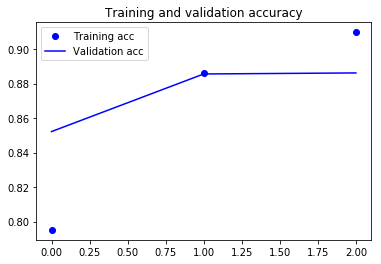

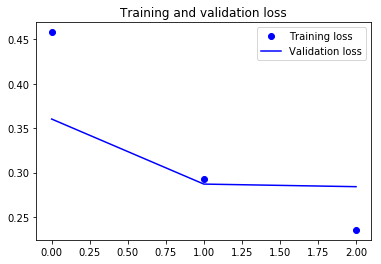

In [33]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## To evaluate both models with the test dataset

In [34]:
# to tokenize the test data

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
X_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


### with GloVe word embedding

In [35]:
# To evaluate against trained first model above

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model.load_weights('model_wGloVE_saved_weights.h5')
score_wGloVe = model_wGloVE.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score_wGloVe[1]*100))


   32/25000 [..............................] - ETA: 100s

   64/25000 [..............................] - ETA: 97s 

   96/25000 [..............................] - ETA: 96s

  128/25000 [..............................] - ETA: 94s

  160/25000 [..............................] - ETA: 96s

  192/25000 [..............................] - ETA: 97s

  224/25000 [..............................] - ETA: 99s

  256/25000 [..............................] - ETA: 99s

  288/25000 [..............................] - ETA: 99s

  320/25000 [..............................] - ETA: 98s

  352/25000 [..............................] - ETA: 98s

  384/25000 [..............................] - ETA: 97s

  416/25000 [..............................] - ETA: 97s

  448/25000 [..............................] - ETA: 97s

  480/25000 [..............................] - ETA: 96s

  512/25000 [..............................] - ETA: 96s

  544/25000 [..............................] - ETA: 95s

  576/25000 [..............................] - ETA: 95s

  608/25000 [..............................] - ETA: 94s

  640/25000 [..............................] - ETA: 94s

  672/25000 [..............................] - ETA: 94s

  704/25000 [..............................] - ETA: 94s

  736/25000 [..............................] - ETA: 93s

  768/25000 [..............................] - ETA: 93s

  800/25000 [..............................] - ETA: 93s

  832/25000 [..............................] - ETA: 92s

  864/25000 [>.............................] - ETA: 92s

  896/25000 [>.............................] - ETA: 92s

  928/25000 [>.............................] - ETA: 92s

  960/25000 [>.............................] - ETA: 91s

  992/25000 [>.............................] - ETA: 91s

 1024/25000 [>.............................] - ETA: 91s

 1056/25000 [>.............................] - ETA: 91s

 1088/25000 [>.............................] - ETA: 91s

 1120/25000 [>.............................] - ETA: 90s

 1152/25000 [>.............................] - ETA: 90s

 1184/25000 [>.............................] - ETA: 90s

 1216/25000 [>.............................] - ETA: 90s

 1248/25000 [>.............................] - ETA: 90s

 1280/25000 [>.............................] - ETA: 90s

 1312/25000 [>.............................] - ETA: 89s

 1344/25000 [>.............................] - ETA: 89s

 1376/25000 [>.............................] - ETA: 89s

 1408/25000 [>.............................] - ETA: 89s

 1440/25000 [>.............................] - ETA: 89s

 1472/25000 [>.............................] - ETA: 88s

 1504/25000 [>.............................] - ETA: 88s

 1536/25000 [>.............................] - ETA: 88s

 1568/25000 [>.............................] - ETA: 88s

 1600/25000 [>.............................] - ETA: 88s

 1632/25000 [>.............................] - ETA: 88s

 1664/25000 [>.............................] - ETA: 88s

 1696/25000 [=>............................] - ETA: 88s

 1728/25000 [=>............................] - ETA: 88s

 1760/25000 [=>............................] - ETA: 87s

 1792/25000 [=>............................] - ETA: 87s

 1824/25000 [=>............................] - ETA: 87s

 1856/25000 [=>............................] - ETA: 87s

 1888/25000 [=>............................] - ETA: 87s

 1920/25000 [=>............................] - ETA: 87s

 1952/25000 [=>............................] - ETA: 87s

 1984/25000 [=>............................] - ETA: 86s

 2016/25000 [=>............................] - ETA: 86s

 2048/25000 [=>............................] - ETA: 86s

 2080/25000 [=>............................] - ETA: 86s

 2112/25000 [=>............................] - ETA: 86s

 2144/25000 [=>............................] - ETA: 86s

 2176/25000 [=>............................] - ETA: 86s

 2208/25000 [=>............................] - ETA: 85s

 2240/25000 [=>............................] - ETA: 85s

 2272/25000 [=>............................] - ETA: 85s

 2304/25000 [=>............................] - ETA: 85s

 2336/25000 [=>............................] - ETA: 85s

 2368/25000 [=>............................] - ETA: 85s

 2400/25000 [=>............................] - ETA: 85s

 2432/25000 [=>............................] - ETA: 84s

 2464/25000 [=>............................] - ETA: 84s

 2496/25000 [=>............................] - ETA: 84s

 2528/25000 [==>...........................] - ETA: 84s

 2560/25000 [==>...........................] - ETA: 84s

 2592/25000 [==>...........................] - ETA: 84s

 2624/25000 [==>...........................] - ETA: 84s

 2656/25000 [==>...........................] - ETA: 84s

 2688/25000 [==>...........................] - ETA: 84s

 2720/25000 [==>...........................] - ETA: 84s

 2752/25000 [==>...........................] - ETA: 83s

 2784/25000 [==>...........................] - ETA: 83s

 2816/25000 [==>...........................] - ETA: 83s

 2848/25000 [==>...........................] - ETA: 83s

 2880/25000 [==>...........................] - ETA: 83s

 2912/25000 [==>...........................] - ETA: 83s

 2944/25000 [==>...........................] - ETA: 83s

 2976/25000 [==>...........................] - ETA: 83s

 3008/25000 [==>...........................] - ETA: 83s

 3040/25000 [==>...........................] - ETA: 82s

 3072/25000 [==>...........................] - ETA: 82s

 3104/25000 [==>...........................] - ETA: 82s

 3136/25000 [==>...........................] - ETA: 82s

 3168/25000 [==>...........................] - ETA: 82s

 3200/25000 [==>...........................] - ETA: 82s

 3232/25000 [==>...........................] - ETA: 82s

 3264/25000 [==>...........................] - ETA: 82s

 3296/25000 [==>...........................] - ETA: 81s

 3328/25000 [==>...........................] - ETA: 81s

 3360/25000 [===>..........................] - ETA: 81s

 3392/25000 [===>..........................] - ETA: 81s

 3424/25000 [===>..........................] - ETA: 81s

 3456/25000 [===>..........................] - ETA: 81s

 3488/25000 [===>..........................] - ETA: 81s

 3520/25000 [===>..........................] - ETA: 80s

 3552/25000 [===>..........................] - ETA: 80s

 3584/25000 [===>..........................] - ETA: 80s

 3616/25000 [===>..........................] - ETA: 80s

 3648/25000 [===>..........................] - ETA: 80s

 3680/25000 [===>..........................] - ETA: 80s

 3712/25000 [===>..........................] - ETA: 80s

 3744/25000 [===>..........................] - ETA: 80s

 3776/25000 [===>..........................] - ETA: 79s

 3808/25000 [===>..........................] - ETA: 79s

 3840/25000 [===>..........................] - ETA: 79s

 3872/25000 [===>..........................] - ETA: 79s

 3904/25000 [===>..........................] - ETA: 79s

 3936/25000 [===>..........................] - ETA: 79s

 3968/25000 [===>..........................] - ETA: 79s

 4000/25000 [===>..........................] - ETA: 79s

 4032/25000 [===>..........................] - ETA: 78s

 4064/25000 [===>..........................] - ETA: 78s

 4096/25000 [===>..........................] - ETA: 78s

 4128/25000 [===>..........................] - ETA: 78s

 4160/25000 [===>..........................] - ETA: 78s

 4192/25000 [====>.........................] - ETA: 78s

 4224/25000 [====>.........................] - ETA: 78s

 4256/25000 [====>.........................] - ETA: 78s

 4288/25000 [====>.........................] - ETA: 78s

 4320/25000 [====>.........................] - ETA: 78s

 4352/25000 [====>.........................] - ETA: 78s

 4384/25000 [====>.........................] - ETA: 77s

 4416/25000 [====>.........................] - ETA: 77s

 4448/25000 [====>.........................] - ETA: 77s

 4480/25000 [====>.........................] - ETA: 77s

 4512/25000 [====>.........................] - ETA: 77s

 4544/25000 [====>.........................] - ETA: 77s

 4576/25000 [====>.........................] - ETA: 77s

 4608/25000 [====>.........................] - ETA: 77s

 4640/25000 [====>.........................] - ETA: 77s

 4672/25000 [====>.........................] - ETA: 76s

 4704/25000 [====>.........................] - ETA: 76s

 4736/25000 [====>.........................] - ETA: 76s

 4768/25000 [====>.........................] - ETA: 76s

 4800/25000 [====>.........................] - ETA: 76s

 4832/25000 [====>.........................] - ETA: 76s

 4864/25000 [====>.........................] - ETA: 76s

 4896/25000 [====>.........................] - ETA: 76s

 4928/25000 [====>.........................] - ETA: 75s

 4960/25000 [====>.........................] - ETA: 75s

 4992/25000 [====>.........................] - ETA: 75s

 5024/25000 [=====>........................] - ETA: 75s

 5056/25000 [=====>........................] - ETA: 75s

 5088/25000 [=====>........................] - ETA: 75s

 5120/25000 [=====>........................] - ETA: 75s

 5152/25000 [=====>........................] - ETA: 74s

 5184/25000 [=====>........................] - ETA: 74s

 5216/25000 [=====>........................] - ETA: 74s

 5248/25000 [=====>........................] - ETA: 74s

 5280/25000 [=====>........................] - ETA: 74s

 5312/25000 [=====>........................] - ETA: 74s

 5344/25000 [=====>........................] - ETA: 74s

 5376/25000 [=====>........................] - ETA: 74s

 5408/25000 [=====>........................] - ETA: 73s

 5440/25000 [=====>........................] - ETA: 73s

 5472/25000 [=====>........................] - ETA: 73s

 5504/25000 [=====>........................] - ETA: 73s

 5536/25000 [=====>........................] - ETA: 73s

 5568/25000 [=====>........................] - ETA: 73s

 5600/25000 [=====>........................] - ETA: 73s

 5632/25000 [=====>........................] - ETA: 73s

 5664/25000 [=====>........................] - ETA: 72s

 5696/25000 [=====>........................] - ETA: 72s

 5728/25000 [=====>........................] - ETA: 72s

 5760/25000 [=====>........................] - ETA: 72s

 5792/25000 [=====>........................] - ETA: 72s

 5824/25000 [=====>........................] - ETA: 72s

 5856/25000 [======>.......................] - ETA: 72s

 5888/25000 [======>.......................] - ETA: 72s

 5920/25000 [======>.......................] - ETA: 71s

 5952/25000 [======>.......................] - ETA: 71s

 5984/25000 [======>.......................] - ETA: 71s

 6016/25000 [======>.......................] - ETA: 71s

 6048/25000 [======>.......................] - ETA: 71s

 6080/25000 [======>.......................] - ETA: 71s

 6112/25000 [======>.......................] - ETA: 71s

 6144/25000 [======>.......................] - ETA: 71s

 6176/25000 [======>.......................] - ETA: 70s

 6208/25000 [======>.......................] - ETA: 70s

 6240/25000 [======>.......................] - ETA: 70s

 6272/25000 [======>.......................] - ETA: 70s

 6304/25000 [======>.......................] - ETA: 70s

 6336/25000 [======>.......................] - ETA: 70s

 6368/25000 [======>.......................] - ETA: 70s

 6400/25000 [======>.......................] - ETA: 70s

 6432/25000 [======>.......................] - ETA: 69s

 6464/25000 [======>.......................] - ETA: 69s

 6496/25000 [======>.......................] - ETA: 69s

 6528/25000 [======>.......................] - ETA: 69s

 6560/25000 [======>.......................] - ETA: 69s

 6592/25000 [======>.......................] - ETA: 69s

 6624/25000 [======>.......................] - ETA: 69s

 6656/25000 [======>.......................] - ETA: 69s

 6688/25000 [=======>......................] - ETA: 68s

 6720/25000 [=======>......................] - ETA: 68s

 6752/25000 [=======>......................] - ETA: 68s

 6784/25000 [=======>......................] - ETA: 68s

 6816/25000 [=======>......................] - ETA: 68s

 6848/25000 [=======>......................] - ETA: 68s

 6880/25000 [=======>......................] - ETA: 68s

 6912/25000 [=======>......................] - ETA: 68s

 6944/25000 [=======>......................] - ETA: 67s

 6976/25000 [=======>......................] - ETA: 67s

 7008/25000 [=======>......................] - ETA: 67s

 7040/25000 [=======>......................] - ETA: 67s

 7072/25000 [=======>......................] - ETA: 67s

 7104/25000 [=======>......................] - ETA: 67s

 7136/25000 [=======>......................] - ETA: 67s

 7168/25000 [=======>......................] - ETA: 67s

 7200/25000 [=======>......................] - ETA: 66s

 7232/25000 [=======>......................] - ETA: 66s

 7264/25000 [=======>......................] - ETA: 66s

 7296/25000 [=======>......................] - ETA: 66s

 7328/25000 [=======>......................] - ETA: 66s

 7360/25000 [=======>......................] - ETA: 66s

 7392/25000 [=======>......................] - ETA: 66s

 7424/25000 [=======>......................] - ETA: 66s

 7456/25000 [=======>......................] - ETA: 65s

 7488/25000 [=======>......................] - ETA: 65s

 7520/25000 [========>.....................] - ETA: 65s

 7552/25000 [========>.....................] - ETA: 65s

 7584/25000 [========>.....................] - ETA: 65s

 7616/25000 [========>.....................] - ETA: 65s

 7648/25000 [========>.....................] - ETA: 65s

 7680/25000 [========>.....................] - ETA: 65s

 7712/25000 [========>.....................] - ETA: 64s

 7744/25000 [========>.....................] - ETA: 64s

 7776/25000 [========>.....................] - ETA: 64s

 7808/25000 [========>.....................] - ETA: 64s

 7840/25000 [========>.....................] - ETA: 64s

 7872/25000 [========>.....................] - ETA: 64s

 7904/25000 [========>.....................] - ETA: 64s

 7936/25000 [========>.....................] - ETA: 64s

 7968/25000 [========>.....................] - ETA: 64s

 8000/25000 [========>.....................] - ETA: 63s

 8032/25000 [========>.....................] - ETA: 63s

 8064/25000 [========>.....................] - ETA: 63s

 8096/25000 [========>.....................] - ETA: 63s

 8128/25000 [========>.....................] - ETA: 63s

 8160/25000 [========>.....................] - ETA: 63s

 8192/25000 [========>.....................] - ETA: 63s

 8224/25000 [========>.....................] - ETA: 63s

 8256/25000 [========>.....................] - ETA: 62s

 8288/25000 [========>.....................] - ETA: 62s

 8320/25000 [========>.....................] - ETA: 62s

 8352/25000 [=========>....................] - ETA: 62s

 8384/25000 [=========>....................] - ETA: 62s

 8416/25000 [=========>....................] - ETA: 62s

 8448/25000 [=========>....................] - ETA: 62s

 8480/25000 [=========>....................] - ETA: 62s

 8512/25000 [=========>....................] - ETA: 61s

 8544/25000 [=========>....................] - ETA: 61s

 8576/25000 [=========>....................] - ETA: 61s

 8608/25000 [=========>....................] - ETA: 61s

 8640/25000 [=========>....................] - ETA: 61s

 8672/25000 [=========>....................] - ETA: 61s

 8704/25000 [=========>....................] - ETA: 61s

 8736/25000 [=========>....................] - ETA: 61s

 8768/25000 [=========>....................] - ETA: 60s

 8800/25000 [=========>....................] - ETA: 60s

 8832/25000 [=========>....................] - ETA: 60s

 8864/25000 [=========>....................] - ETA: 60s

 8896/25000 [=========>....................] - ETA: 60s

 8928/25000 [=========>....................] - ETA: 60s

 8960/25000 [=========>....................] - ETA: 60s

 8992/25000 [=========>....................] - ETA: 60s

 9024/25000 [=========>....................] - ETA: 59s

 9056/25000 [=========>....................] - ETA: 59s

 9088/25000 [=========>....................] - ETA: 59s

 9120/25000 [=========>....................] - ETA: 59s

 9152/25000 [=========>....................] - ETA: 59s

 9184/25000 [==========>...................] - ETA: 59s

 9216/25000 [==========>...................] - ETA: 59s

 9248/25000 [==========>...................] - ETA: 59s

 9280/25000 [==========>...................] - ETA: 59s

 9312/25000 [==========>...................] - ETA: 58s

 9344/25000 [==========>...................] - ETA: 58s

 9376/25000 [==========>...................] - ETA: 58s

 9408/25000 [==========>...................] - ETA: 58s

 9440/25000 [==========>...................] - ETA: 58s

 9472/25000 [==========>...................] - ETA: 58s

 9504/25000 [==========>...................] - ETA: 58s

 9536/25000 [==========>...................] - ETA: 58s

 9568/25000 [==========>...................] - ETA: 57s

 9600/25000 [==========>...................] - ETA: 57s

 9632/25000 [==========>...................] - ETA: 57s

 9664/25000 [==========>...................] - ETA: 57s

 9696/25000 [==========>...................] - ETA: 57s

 9728/25000 [==========>...................] - ETA: 57s

 9760/25000 [==========>...................] - ETA: 57s

 9792/25000 [==========>...................] - ETA: 57s

 9824/25000 [==========>...................] - ETA: 56s

 9856/25000 [==========>...................] - ETA: 56s

 9888/25000 [==========>...................] - ETA: 56s

 9920/25000 [==========>...................] - ETA: 56s

 9952/25000 [==========>...................] - ETA: 56s

 9984/25000 [==========>...................] - ETA: 56s

10016/25000 [===========>..................] - ETA: 56s

10048/25000 [===========>..................] - ETA: 56s

10080/25000 [===========>..................] - ETA: 55s

10112/25000 [===========>..................] - ETA: 55s

10144/25000 [===========>..................] - ETA: 55s

10176/25000 [===========>..................] - ETA: 55s

10208/25000 [===========>..................] - ETA: 55s

10240/25000 [===========>..................] - ETA: 55s

10272/25000 [===========>..................] - ETA: 55s

10304/25000 [===========>..................] - ETA: 55s

10336/25000 [===========>..................] - ETA: 54s

10368/25000 [===========>..................] - ETA: 54s

10400/25000 [===========>..................] - ETA: 54s

10432/25000 [===========>..................] - ETA: 54s

10464/25000 [===========>..................] - ETA: 54s

10496/25000 [===========>..................] - ETA: 54s

10528/25000 [===========>..................] - ETA: 54s

10560/25000 [===========>..................] - ETA: 54s

10592/25000 [===========>..................] - ETA: 54s

10624/25000 [===========>..................] - ETA: 53s

10656/25000 [===========>..................] - ETA: 53s

10688/25000 [===========>..................] - ETA: 53s

10720/25000 [===========>..................] - ETA: 53s

10752/25000 [===========>..................] - ETA: 53s

10784/25000 [===========>..................] - ETA: 53s

10816/25000 [===========>..................] - ETA: 53s

10848/25000 [============>.................] - ETA: 53s

10880/25000 [============>.................] - ETA: 52s

10912/25000 [============>.................] - ETA: 52s

10944/25000 [============>.................] - ETA: 52s

10976/25000 [============>.................] - ETA: 52s

11008/25000 [============>.................] - ETA: 52s

11040/25000 [============>.................] - ETA: 52s

11072/25000 [============>.................] - ETA: 52s

11104/25000 [============>.................] - ETA: 52s

11136/25000 [============>.................] - ETA: 51s

11168/25000 [============>.................] - ETA: 51s

11200/25000 [============>.................] - ETA: 51s

11232/25000 [============>.................] - ETA: 51s

11264/25000 [============>.................] - ETA: 51s

11296/25000 [============>.................] - ETA: 51s

11328/25000 [============>.................] - ETA: 51s

11360/25000 [============>.................] - ETA: 51s

11392/25000 [============>.................] - ETA: 51s

11424/25000 [============>.................] - ETA: 50s

11456/25000 [============>.................] - ETA: 50s

11488/25000 [============>.................] - ETA: 50s

11520/25000 [============>.................] - ETA: 50s

11552/25000 [============>.................] - ETA: 50s

11584/25000 [============>.................] - ETA: 50s

11616/25000 [============>.................] - ETA: 50s

11648/25000 [============>.................] - ETA: 50s

11680/25000 [=============>................] - ETA: 49s

11712/25000 [=============>................] - ETA: 49s

11744/25000 [=============>................] - ETA: 49s

11776/25000 [=============>................] - ETA: 49s

11808/25000 [=============>................] - ETA: 49s

11840/25000 [=============>................] - ETA: 49s

11872/25000 [=============>................] - ETA: 49s

11904/25000 [=============>................] - ETA: 49s

11936/25000 [=============>................] - ETA: 48s

11968/25000 [=============>................] - ETA: 48s

12000/25000 [=============>................] - ETA: 48s

12032/25000 [=============>................] - ETA: 48s

12064/25000 [=============>................] - ETA: 48s

12096/25000 [=============>................] - ETA: 48s

12128/25000 [=============>................] - ETA: 48s

12160/25000 [=============>................] - ETA: 48s

12192/25000 [=============>................] - ETA: 47s

12224/25000 [=============>................] - ETA: 47s

12256/25000 [=============>................] - ETA: 47s

12288/25000 [=============>................] - ETA: 47s

12320/25000 [=============>................] - ETA: 47s

12352/25000 [=============>................] - ETA: 47s

12384/25000 [=============>................] - ETA: 47s

12416/25000 [=============>................] - ETA: 47s

12448/25000 [=============>................] - ETA: 47s

12480/25000 [=============>................] - ETA: 46s

12512/25000 [==============>...............] - ETA: 46s

12544/25000 [==============>...............] - ETA: 46s

12576/25000 [==============>...............] - ETA: 46s

12608/25000 [==============>...............] - ETA: 46s

12640/25000 [==============>...............] - ETA: 46s

12672/25000 [==============>...............] - ETA: 46s

12704/25000 [==============>...............] - ETA: 46s

12736/25000 [==============>...............] - ETA: 45s

12768/25000 [==============>...............] - ETA: 45s

12800/25000 [==============>...............] - ETA: 45s

12832/25000 [==============>...............] - ETA: 45s

12864/25000 [==============>...............] - ETA: 45s

12896/25000 [==============>...............] - ETA: 45s

12928/25000 [==============>...............] - ETA: 45s

12960/25000 [==============>...............] - ETA: 45s

12992/25000 [==============>...............] - ETA: 44s

13024/25000 [==============>...............] - ETA: 44s

13056/25000 [==============>...............] - ETA: 44s

13088/25000 [==============>...............] - ETA: 44s

13120/25000 [==============>...............] - ETA: 44s

13152/25000 [==============>...............] - ETA: 44s

13184/25000 [==============>...............] - ETA: 44s

13216/25000 [==============>...............] - ETA: 44s

13248/25000 [==============>...............] - ETA: 43s

13280/25000 [==============>...............] - ETA: 43s

13312/25000 [==============>...............] - ETA: 43s

13344/25000 [===============>..............] - ETA: 43s

13376/25000 [===============>..............] - ETA: 43s

13408/25000 [===============>..............] - ETA: 43s

13440/25000 [===============>..............] - ETA: 43s

13472/25000 [===============>..............] - ETA: 43s

13504/25000 [===============>..............] - ETA: 43s

13536/25000 [===============>..............] - ETA: 42s

13568/25000 [===============>..............] - ETA: 42s

13600/25000 [===============>..............] - ETA: 42s

13632/25000 [===============>..............] - ETA: 42s

13664/25000 [===============>..............] - ETA: 42s

13696/25000 [===============>..............] - ETA: 42s

13728/25000 [===============>..............] - ETA: 42s

13760/25000 [===============>..............] - ETA: 42s

13792/25000 [===============>..............] - ETA: 41s

13824/25000 [===============>..............] - ETA: 41s

13856/25000 [===============>..............] - ETA: 41s

13888/25000 [===============>..............] - ETA: 41s

13920/25000 [===============>..............] - ETA: 41s

13952/25000 [===============>..............] - ETA: 41s

13984/25000 [===============>..............] - ETA: 41s

14016/25000 [===============>..............] - ETA: 41s

14048/25000 [===============>..............] - ETA: 40s

14080/25000 [===============>..............] - ETA: 40s

14112/25000 [===============>..............] - ETA: 40s

14144/25000 [===============>..............] - ETA: 40s

14176/25000 [================>.............] - ETA: 40s

14208/25000 [================>.............] - ETA: 40s

14240/25000 [================>.............] - ETA: 40s

14272/25000 [================>.............] - ETA: 40s

14304/25000 [================>.............] - ETA: 40s

14336/25000 [================>.............] - ETA: 39s

14368/25000 [================>.............] - ETA: 39s

14400/25000 [================>.............] - ETA: 39s

14432/25000 [================>.............] - ETA: 39s

14464/25000 [================>.............] - ETA: 39s

14496/25000 [================>.............] - ETA: 39s

14528/25000 [================>.............] - ETA: 39s

14560/25000 [================>.............] - ETA: 39s

14592/25000 [================>.............] - ETA: 38s

14624/25000 [================>.............] - ETA: 38s

14656/25000 [================>.............] - ETA: 38s

14688/25000 [================>.............] - ETA: 38s

14720/25000 [================>.............] - ETA: 38s

14752/25000 [================>.............] - ETA: 38s

14784/25000 [================>.............] - ETA: 38s

14816/25000 [================>.............] - ETA: 38s

14848/25000 [================>.............] - ETA: 37s

14880/25000 [================>.............] - ETA: 37s

14912/25000 [================>.............] - ETA: 37s

14944/25000 [================>.............] - ETA: 37s

14976/25000 [================>.............] - ETA: 37s

15008/25000 [=================>............] - ETA: 37s

15040/25000 [=================>............] - ETA: 37s

15072/25000 [=================>............] - ETA: 37s

15104/25000 [=================>............] - ETA: 37s

15136/25000 [=================>............] - ETA: 36s

15168/25000 [=================>............] - ETA: 36s

15200/25000 [=================>............] - ETA: 36s

15232/25000 [=================>............] - ETA: 36s

15264/25000 [=================>............] - ETA: 36s

15296/25000 [=================>............] - ETA: 36s

15328/25000 [=================>............] - ETA: 36s

15360/25000 [=================>............] - ETA: 36s

15392/25000 [=================>............] - ETA: 35s

15424/25000 [=================>............] - ETA: 35s

15456/25000 [=================>............] - ETA: 35s

15488/25000 [=================>............] - ETA: 35s

15520/25000 [=================>............] - ETA: 35s

15552/25000 [=================>............] - ETA: 35s

15584/25000 [=================>............] - ETA: 35s

15616/25000 [=================>............] - ETA: 35s

15648/25000 [=================>............] - ETA: 34s

15680/25000 [=================>............] - ETA: 34s

15712/25000 [=================>............] - ETA: 34s

15744/25000 [=================>............] - ETA: 34s

15776/25000 [=================>............] - ETA: 34s

15808/25000 [=================>............] - ETA: 34s

15840/25000 [==================>...........] - ETA: 34s

15872/25000 [==================>...........] - ETA: 34s

15904/25000 [==================>...........] - ETA: 34s

15936/25000 [==================>...........] - ETA: 33s

15968/25000 [==================>...........] - ETA: 33s

16000/25000 [==================>...........] - ETA: 33s

16032/25000 [==================>...........] - ETA: 33s

16064/25000 [==================>...........] - ETA: 33s

16096/25000 [==================>...........] - ETA: 33s

16128/25000 [==================>...........] - ETA: 33s

16160/25000 [==================>...........] - ETA: 33s

16192/25000 [==================>...........] - ETA: 32s

16224/25000 [==================>...........] - ETA: 32s

16256/25000 [==================>...........] - ETA: 32s

16288/25000 [==================>...........] - ETA: 32s

16320/25000 [==================>...........] - ETA: 32s

16352/25000 [==================>...........] - ETA: 32s

16384/25000 [==================>...........] - ETA: 32s

16416/25000 [==================>...........] - ETA: 32s

16448/25000 [==================>...........] - ETA: 31s

16480/25000 [==================>...........] - ETA: 31s

16512/25000 [==================>...........] - ETA: 31s

16544/25000 [==================>...........] - ETA: 31s

16576/25000 [==================>...........] - ETA: 31s

16608/25000 [==================>...........] - ETA: 31s

16640/25000 [==================>...........] - ETA: 31s

16672/25000 [===================>..........] - ETA: 31s

16704/25000 [===================>..........] - ETA: 31s

16736/25000 [===================>..........] - ETA: 30s

16768/25000 [===================>..........] - ETA: 30s

16800/25000 [===================>..........] - ETA: 30s

16832/25000 [===================>..........] - ETA: 30s

16864/25000 [===================>..........] - ETA: 30s

16896/25000 [===================>..........] - ETA: 30s

16928/25000 [===================>..........] - ETA: 30s

16960/25000 [===================>..........] - ETA: 30s

16992/25000 [===================>..........] - ETA: 29s

17024/25000 [===================>..........] - ETA: 29s

17056/25000 [===================>..........] - ETA: 29s

17088/25000 [===================>..........] - ETA: 29s

17120/25000 [===================>..........] - ETA: 29s

17152/25000 [===================>..........] - ETA: 29s

17184/25000 [===================>..........] - ETA: 29s

17216/25000 [===================>..........] - ETA: 29s

17248/25000 [===================>..........] - ETA: 28s

17280/25000 [===================>..........] - ETA: 28s

17312/25000 [===================>..........] - ETA: 28s

17344/25000 [===================>..........] - ETA: 28s

17376/25000 [===================>..........] - ETA: 28s

17408/25000 [===================>..........] - ETA: 28s

17440/25000 [===================>..........] - ETA: 28s

17472/25000 [===================>..........] - ETA: 28s

17504/25000 [====================>.........] - ETA: 28s

17536/25000 [====================>.........] - ETA: 27s

17568/25000 [====================>.........] - ETA: 27s

17600/25000 [====================>.........] - ETA: 27s

17632/25000 [====================>.........] - ETA: 27s

17664/25000 [====================>.........] - ETA: 27s

17696/25000 [====================>.........] - ETA: 27s

17728/25000 [====================>.........] - ETA: 27s

17760/25000 [====================>.........] - ETA: 27s

17792/25000 [====================>.........] - ETA: 26s

17824/25000 [====================>.........] - ETA: 26s

17856/25000 [====================>.........] - ETA: 26s

17888/25000 [====================>.........] - ETA: 26s

17920/25000 [====================>.........] - ETA: 26s

17952/25000 [====================>.........] - ETA: 26s

17984/25000 [====================>.........] - ETA: 26s

18016/25000 [====================>.........] - ETA: 26s

18048/25000 [====================>.........] - ETA: 25s

18080/25000 [====================>.........] - ETA: 25s

18112/25000 [====================>.........] - ETA: 25s

18144/25000 [====================>.........] - ETA: 25s

18176/25000 [====================>.........] - ETA: 25s

18208/25000 [====================>.........] - ETA: 25s

18240/25000 [====================>.........] - ETA: 25s

18272/25000 [====================>.........] - ETA: 25s

18304/25000 [====================>.........] - ETA: 25s

18336/25000 [=====================>........] - ETA: 24s

18368/25000 [=====================>........] - ETA: 24s

18400/25000 [=====================>........] - ETA: 24s

18432/25000 [=====================>........] - ETA: 24s

18464/25000 [=====================>........] - ETA: 24s

18496/25000 [=====================>........] - ETA: 24s

18528/25000 [=====================>........] - ETA: 24s

18560/25000 [=====================>........] - ETA: 24s

18592/25000 [=====================>........] - ETA: 23s

18624/25000 [=====================>........] - ETA: 23s

18656/25000 [=====================>........] - ETA: 23s

18688/25000 [=====================>........] - ETA: 23s

18720/25000 [=====================>........] - ETA: 23s

18752/25000 [=====================>........] - ETA: 23s

18784/25000 [=====================>........] - ETA: 23s

18816/25000 [=====================>........] - ETA: 23s

18848/25000 [=====================>........] - ETA: 22s

18880/25000 [=====================>........] - ETA: 22s

18912/25000 [=====================>........] - ETA: 22s

18944/25000 [=====================>........] - ETA: 22s

18976/25000 [=====================>........] - ETA: 22s

19008/25000 [=====================>........] - ETA: 22s

19040/25000 [=====================>........] - ETA: 22s

19072/25000 [=====================>........] - ETA: 22s

19104/25000 [=====================>........] - ETA: 22s

19136/25000 [=====================>........] - ETA: 21s

19168/25000 [======================>.......] - ETA: 21s

19200/25000 [======================>.......] - ETA: 21s

19232/25000 [======================>.......] - ETA: 21s

19264/25000 [======================>.......] - ETA: 21s

19296/25000 [======================>.......] - ETA: 21s

19328/25000 [======================>.......] - ETA: 21s

19360/25000 [======================>.......] - ETA: 21s

19392/25000 [======================>.......] - ETA: 20s

19424/25000 [======================>.......] - ETA: 20s

19456/25000 [======================>.......] - ETA: 20s

19488/25000 [======================>.......] - ETA: 20s

19520/25000 [======================>.......] - ETA: 20s

19552/25000 [======================>.......] - ETA: 20s

19584/25000 [======================>.......] - ETA: 20s

19616/25000 [======================>.......] - ETA: 20s

19648/25000 [======================>.......] - ETA: 19s

19680/25000 [======================>.......] - ETA: 19s

19712/25000 [======================>.......] - ETA: 19s

19744/25000 [======================>.......] - ETA: 19s

19776/25000 [======================>.......] - ETA: 19s

19808/25000 [======================>.......] - ETA: 19s

19840/25000 [======================>.......] - ETA: 19s

19872/25000 [======================>.......] - ETA: 19s

19904/25000 [======================>.......] - ETA: 19s

19936/25000 [======================>.......] - ETA: 18s

19968/25000 [======================>.......] - ETA: 18s

20000/25000 [=======================>......] - ETA: 18s

20032/25000 [=======================>......] - ETA: 18s

20064/25000 [=======================>......] - ETA: 18s

20096/25000 [=======================>......] - ETA: 18s

20128/25000 [=======================>......] - ETA: 18s

20160/25000 [=======================>......] - ETA: 18s

20192/25000 [=======================>......] - ETA: 17s

20224/25000 [=======================>......] - ETA: 17s

20256/25000 [=======================>......] - ETA: 17s

20288/25000 [=======================>......] - ETA: 17s

20320/25000 [=======================>......] - ETA: 17s

20352/25000 [=======================>......] - ETA: 17s

20384/25000 [=======================>......] - ETA: 17s

20416/25000 [=======================>......] - ETA: 17s

20448/25000 [=======================>......] - ETA: 16s

20480/25000 [=======================>......] - ETA: 16s

20512/25000 [=======================>......] - ETA: 16s

20544/25000 [=======================>......] - ETA: 16s

20576/25000 [=======================>......] - ETA: 16s

20608/25000 [=======================>......] - ETA: 16s

20640/25000 [=======================>......] - ETA: 16s

20672/25000 [=======================>......] - ETA: 16s

20704/25000 [=======================>......] - ETA: 16s

20736/25000 [=======================>......] - ETA: 15s

20768/25000 [=======================>......] - ETA: 15s

20800/25000 [=======================>......] - ETA: 15s

20832/25000 [=======================>......] - ETA: 15s

20864/25000 [========================>.....] - ETA: 15s

20896/25000 [========================>.....] - ETA: 15s

20928/25000 [========================>.....] - ETA: 15s

20960/25000 [========================>.....] - ETA: 15s

20992/25000 [========================>.....] - ETA: 14s

21024/25000 [========================>.....] - ETA: 14s

21056/25000 [========================>.....] - ETA: 14s

21088/25000 [========================>.....] - ETA: 14s

21120/25000 [========================>.....] - ETA: 14s

21152/25000 [========================>.....] - ETA: 14s

21184/25000 [========================>.....] - ETA: 14s

21216/25000 [========================>.....] - ETA: 14s

21248/25000 [========================>.....] - ETA: 14s

21280/25000 [========================>.....] - ETA: 13s

21312/25000 [========================>.....] - ETA: 13s

21344/25000 [========================>.....] - ETA: 13s

21376/25000 [========================>.....] - ETA: 13s

21408/25000 [========================>.....] - ETA: 13s

21440/25000 [========================>.....] - ETA: 13s

21472/25000 [========================>.....] - ETA: 13s

21504/25000 [========================>.....] - ETA: 13s

21536/25000 [========================>.....] - ETA: 12s

21568/25000 [========================>.....] - ETA: 12s

21600/25000 [========================>.....] - ETA: 12s

21632/25000 [========================>.....] - ETA: 12s

21664/25000 [========================>.....] - ETA: 12s

21696/25000 [=========================>....] - ETA: 12s

21728/25000 [=========================>....] - ETA: 12s

21760/25000 [=========================>....] - ETA: 12s

21792/25000 [=========================>....] - ETA: 11s

21824/25000 [=========================>....] - ETA: 11s

21856/25000 [=========================>....] - ETA: 11s

21888/25000 [=========================>....] - ETA: 11s

21920/25000 [=========================>....] - ETA: 11s

21952/25000 [=========================>....] - ETA: 11s

21984/25000 [=========================>....] - ETA: 11s

22016/25000 [=========================>....] - ETA: 11s

22048/25000 [=========================>....] - ETA: 11s

22080/25000 [=========================>....] - ETA: 10s

22112/25000 [=========================>....] - ETA: 10s

22144/25000 [=========================>....] - ETA: 10s

22176/25000 [=========================>....] - ETA: 10s

22208/25000 [=========================>....] - ETA: 10s

22240/25000 [=========================>....] - ETA: 10s

22272/25000 [=========================>....] - ETA: 10s

22304/25000 [=========================>....] - ETA: 10s

22336/25000 [=========================>....] - ETA: 9s 

22368/25000 [=========================>....] - ETA: 9s

22400/25000 [=========================>....] - ETA: 9s

22432/25000 [=========================>....] - ETA: 9s

22464/25000 [=========================>....] - ETA: 9s

22496/25000 [=========================>....] - ETA: 9s

22528/25000 [==========================>...] - ETA: 9s

22560/25000 [==========================>...] - ETA: 9s

22592/25000 [==========================>...] - ETA: 8s

22624/25000 [==========================>...] - ETA: 8s

22656/25000 [==========================>...] - ETA: 8s

22688/25000 [==========================>...] - ETA: 8s

22720/25000 [==========================>...] - ETA: 8s

22752/25000 [==========================>...] - ETA: 8s

22784/25000 [==========================>...] - ETA: 8s

22816/25000 [==========================>...] - ETA: 8s

22848/25000 [==========================>...] - ETA: 8s

22880/25000 [==========================>...] - ETA: 7s

22912/25000 [==========================>...] - ETA: 7s

22944/25000 [==========================>...] - ETA: 7s

22976/25000 [==========================>...] - ETA: 7s

23008/25000 [==========================>...] - ETA: 7s

23040/25000 [==========================>...] - ETA: 7s

23072/25000 [==========================>...] - ETA: 7s

23104/25000 [==========================>...] - ETA: 7s

23136/25000 [==========================>...] - ETA: 6s

23168/25000 [==========================>...] - ETA: 6s

23200/25000 [==========================>...] - ETA: 6s

23232/25000 [==========================>...] - ETA: 6s

23264/25000 [==========================>...] - ETA: 6s

23296/25000 [==========================>...] - ETA: 6s

23328/25000 [==========================>...] - ETA: 6s

23360/25000 [===========================>..] - ETA: 6s

23392/25000 [===========================>..] - ETA: 6s

23424/25000 [===========================>..] - ETA: 5s

23456/25000 [===========================>..] - ETA: 5s

23488/25000 [===========================>..] - ETA: 5s

23520/25000 [===========================>..] - ETA: 5s

23552/25000 [===========================>..] - ETA: 5s

23584/25000 [===========================>..] - ETA: 5s

23616/25000 [===========================>..] - ETA: 5s

23648/25000 [===========================>..] - ETA: 5s

23680/25000 [===========================>..] - ETA: 4s

23712/25000 [===========================>..] - ETA: 4s

23744/25000 [===========================>..] - ETA: 4s

23776/25000 [===========================>..] - ETA: 4s

23808/25000 [===========================>..] - ETA: 4s

23840/25000 [===========================>..] - ETA: 4s

23872/25000 [===========================>..] - ETA: 4s

23904/25000 [===========================>..] - ETA: 4s

23936/25000 [===========================>..] - ETA: 3s

23968/25000 [===========================>..] - ETA: 3s

24000/25000 [===========================>..] - ETA: 3s

24032/25000 [===========================>..] - ETA: 3s

24064/25000 [===========================>..] - ETA: 3s

24096/25000 [===========================>..] - ETA: 3s

24128/25000 [===========================>..] - ETA: 3s

24160/25000 [===========================>..] - ETA: 3s

24192/25000 [============================>.] - ETA: 3s

24224/25000 [============================>.] - ETA: 2s

24256/25000 [============================>.] - ETA: 2s

24288/25000 [============================>.] - ETA: 2s

24320/25000 [============================>.] - ETA: 2s

24352/25000 [============================>.] - ETA: 2s

24384/25000 [============================>.] - ETA: 2s

24416/25000 [============================>.] - ETA: 2s

24448/25000 [============================>.] - ETA: 2s

24480/25000 [============================>.] - ETA: 1s

24512/25000 [============================>.] - ETA: 1s

24544/25000 [============================>.] - ETA: 1s

24576/25000 [============================>.] - ETA: 1s

24608/25000 [============================>.] - ETA: 1s

24640/25000 [============================>.] - ETA: 1s

24672/25000 [============================>.] - ETA: 1s

24704/25000 [============================>.] - ETA: 1s

24736/25000 [============================>.] - ETA: 0s

24768/25000 [============================>.] - ETA: 0s

24800/25000 [============================>.] - ETA: 0s

24832/25000 [============================>.] - ETA: 0s

24864/25000 [============================>.] - ETA: 0s

24896/25000 [============================>.] - ETA: 0s

24928/25000 [============================>.] - ETA: 0s

24960/25000 [============================>.] - ETA: 0s

24992/25000 [============================>.] - ETA: 0s

25000/25000 [==============================] - 93s    


Accuracy: 82.03%


### Without GloVe word embedding

In [36]:
score = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (score[1]*100))

# Why the accuracy scores are the same? to try GRU layers next time.

   32/25000 [..............................] - ETA: 99s

   64/25000 [..............................] - ETA: 95s

   96/25000 [..............................] - ETA: 95s

  128/25000 [..............................] - ETA: 94s

  160/25000 [..............................] - ETA: 94s

  192/25000 [..............................] - ETA: 94s

  224/25000 [..............................] - ETA: 95s

  256/25000 [..............................] - ETA: 95s

  288/25000 [..............................] - ETA: 94s

  320/25000 [..............................] - ETA: 94s

  352/25000 [..............................] - ETA: 93s

  384/25000 [..............................] - ETA: 93s

  416/25000 [..............................] - ETA: 93s

  448/25000 [..............................] - ETA: 92s

  480/25000 [..............................] - ETA: 92s

  512/25000 [..............................] - ETA: 92s

  544/25000 [..............................] - ETA: 92s

  576/25000 [..............................] - ETA: 91s

  608/25000 [..............................] - ETA: 91s

  640/25000 [..............................] - ETA: 91s

  672/25000 [..............................] - ETA: 91s

  704/25000 [..............................] - ETA: 91s

  736/25000 [..............................] - ETA: 91s

  768/25000 [..............................] - ETA: 90s

  800/25000 [..............................] - ETA: 90s

  832/25000 [..............................] - ETA: 90s

  864/25000 [>.............................] - ETA: 90s

  896/25000 [>.............................] - ETA: 90s

  928/25000 [>.............................] - ETA: 90s

  960/25000 [>.............................] - ETA: 89s

  992/25000 [>.............................] - ETA: 89s

 1024/25000 [>.............................] - ETA: 89s

 1056/25000 [>.............................] - ETA: 89s

 1088/25000 [>.............................] - ETA: 89s

 1120/25000 [>.............................] - ETA: 89s

 1152/25000 [>.............................] - ETA: 89s

 1184/25000 [>.............................] - ETA: 88s

 1216/25000 [>.............................] - ETA: 88s

 1248/25000 [>.............................] - ETA: 88s

 1280/25000 [>.............................] - ETA: 88s

 1312/25000 [>.............................] - ETA: 88s

 1344/25000 [>.............................] - ETA: 88s

 1376/25000 [>.............................] - ETA: 88s

 1408/25000 [>.............................] - ETA: 87s

 1440/25000 [>.............................] - ETA: 87s

 1472/25000 [>.............................] - ETA: 87s

 1504/25000 [>.............................] - ETA: 87s

 1536/25000 [>.............................] - ETA: 87s

 1568/25000 [>.............................] - ETA: 87s

 1600/25000 [>.............................] - ETA: 87s

 1632/25000 [>.............................] - ETA: 87s

 1664/25000 [>.............................] - ETA: 87s

 1696/25000 [=>............................] - ETA: 86s

 1728/25000 [=>............................] - ETA: 86s

 1760/25000 [=>............................] - ETA: 86s

 1792/25000 [=>............................] - ETA: 86s

 1824/25000 [=>............................] - ETA: 86s

 1856/25000 [=>............................] - ETA: 86s

 1888/25000 [=>............................] - ETA: 86s

 1920/25000 [=>............................] - ETA: 86s

 1952/25000 [=>............................] - ETA: 85s

 1984/25000 [=>............................] - ETA: 85s

 2016/25000 [=>............................] - ETA: 85s

 2048/25000 [=>............................] - ETA: 85s

 2080/25000 [=>............................] - ETA: 85s

 2112/25000 [=>............................] - ETA: 85s

 2144/25000 [=>............................] - ETA: 85s

 2176/25000 [=>............................] - ETA: 85s

 2208/25000 [=>............................] - ETA: 84s

 2240/25000 [=>............................] - ETA: 84s

 2272/25000 [=>............................] - ETA: 84s

 2304/25000 [=>............................] - ETA: 84s

 2336/25000 [=>............................] - ETA: 84s

 2368/25000 [=>............................] - ETA: 84s

 2400/25000 [=>............................] - ETA: 84s

 2432/25000 [=>............................] - ETA: 84s

 2464/25000 [=>............................] - ETA: 83s

 2496/25000 [=>............................] - ETA: 83s

 2528/25000 [==>...........................] - ETA: 83s

 2560/25000 [==>...........................] - ETA: 83s

 2592/25000 [==>...........................] - ETA: 83s

 2624/25000 [==>...........................] - ETA: 83s

 2656/25000 [==>...........................] - ETA: 83s

 2688/25000 [==>...........................] - ETA: 83s

 2720/25000 [==>...........................] - ETA: 83s

 2752/25000 [==>...........................] - ETA: 82s

 2784/25000 [==>...........................] - ETA: 82s

 2816/25000 [==>...........................] - ETA: 82s

 2848/25000 [==>...........................] - ETA: 82s

 2880/25000 [==>...........................] - ETA: 82s

 2912/25000 [==>...........................] - ETA: 82s

 2944/25000 [==>...........................] - ETA: 82s

 2976/25000 [==>...........................] - ETA: 82s

 3008/25000 [==>...........................] - ETA: 81s

 3040/25000 [==>...........................] - ETA: 81s

 3072/25000 [==>...........................] - ETA: 81s

 3104/25000 [==>...........................] - ETA: 81s

 3136/25000 [==>...........................] - ETA: 81s

 3168/25000 [==>...........................] - ETA: 81s

 3200/25000 [==>...........................] - ETA: 81s

 3232/25000 [==>...........................] - ETA: 81s

 3264/25000 [==>...........................] - ETA: 80s

 3296/25000 [==>...........................] - ETA: 80s

 3328/25000 [==>...........................] - ETA: 80s

 3360/25000 [===>..........................] - ETA: 80s

 3392/25000 [===>..........................] - ETA: 80s

 3424/25000 [===>..........................] - ETA: 80s

 3456/25000 [===>..........................] - ETA: 80s

 3488/25000 [===>..........................] - ETA: 80s

 3520/25000 [===>..........................] - ETA: 79s

 3552/25000 [===>..........................] - ETA: 79s

 3584/25000 [===>..........................] - ETA: 79s

 3616/25000 [===>..........................] - ETA: 79s

 3648/25000 [===>..........................] - ETA: 79s

 3680/25000 [===>..........................] - ETA: 79s

 3712/25000 [===>..........................] - ETA: 79s

 3744/25000 [===>..........................] - ETA: 79s

 3776/25000 [===>..........................] - ETA: 78s

 3808/25000 [===>..........................] - ETA: 78s

 3840/25000 [===>..........................] - ETA: 78s

 3872/25000 [===>..........................] - ETA: 78s

 3904/25000 [===>..........................] - ETA: 78s

 3936/25000 [===>..........................] - ETA: 78s

 3968/25000 [===>..........................] - ETA: 78s

 4000/25000 [===>..........................] - ETA: 78s

 4032/25000 [===>..........................] - ETA: 78s

 4064/25000 [===>..........................] - ETA: 77s

 4096/25000 [===>..........................] - ETA: 77s

 4128/25000 [===>..........................] - ETA: 77s

 4160/25000 [===>..........................] - ETA: 77s

 4192/25000 [====>.........................] - ETA: 77s

 4224/25000 [====>.........................] - ETA: 77s

 4256/25000 [====>.........................] - ETA: 77s

 4288/25000 [====>.........................] - ETA: 77s

 4320/25000 [====>.........................] - ETA: 76s

 4352/25000 [====>.........................] - ETA: 76s

 4384/25000 [====>.........................] - ETA: 76s

 4416/25000 [====>.........................] - ETA: 76s

 4448/25000 [====>.........................] - ETA: 76s

 4480/25000 [====>.........................] - ETA: 76s

 4512/25000 [====>.........................] - ETA: 76s

 4544/25000 [====>.........................] - ETA: 76s

 4576/25000 [====>.........................] - ETA: 75s

 4608/25000 [====>.........................] - ETA: 75s

 4640/25000 [====>.........................] - ETA: 75s

 4672/25000 [====>.........................] - ETA: 75s

 4704/25000 [====>.........................] - ETA: 75s

 4736/25000 [====>.........................] - ETA: 75s

 4768/25000 [====>.........................] - ETA: 75s

 4800/25000 [====>.........................] - ETA: 75s

 4832/25000 [====>.........................] - ETA: 75s

 4864/25000 [====>.........................] - ETA: 74s

 4896/25000 [====>.........................] - ETA: 74s

 4928/25000 [====>.........................] - ETA: 74s

 4960/25000 [====>.........................] - ETA: 74s

 4992/25000 [====>.........................] - ETA: 74s

 5024/25000 [=====>........................] - ETA: 74s

 5056/25000 [=====>........................] - ETA: 74s

 5088/25000 [=====>........................] - ETA: 74s

 5120/25000 [=====>........................] - ETA: 73s

 5152/25000 [=====>........................] - ETA: 73s

 5184/25000 [=====>........................] - ETA: 73s

 5216/25000 [=====>........................] - ETA: 73s

 5248/25000 [=====>........................] - ETA: 73s

 5280/25000 [=====>........................] - ETA: 73s

 5312/25000 [=====>........................] - ETA: 73s

 5344/25000 [=====>........................] - ETA: 73s

 5376/25000 [=====>........................] - ETA: 72s

 5408/25000 [=====>........................] - ETA: 72s

 5440/25000 [=====>........................] - ETA: 72s

 5472/25000 [=====>........................] - ETA: 72s

 5504/25000 [=====>........................] - ETA: 72s

 5536/25000 [=====>........................] - ETA: 72s

 5568/25000 [=====>........................] - ETA: 72s

 5600/25000 [=====>........................] - ETA: 72s

 5632/25000 [=====>........................] - ETA: 72s

 5664/25000 [=====>........................] - ETA: 71s

 5696/25000 [=====>........................] - ETA: 71s

 5728/25000 [=====>........................] - ETA: 71s

 5760/25000 [=====>........................] - ETA: 71s

 5792/25000 [=====>........................] - ETA: 71s

 5824/25000 [=====>........................] - ETA: 71s

 5856/25000 [======>.......................] - ETA: 71s

 5888/25000 [======>.......................] - ETA: 71s

 5920/25000 [======>.......................] - ETA: 70s

 5952/25000 [======>.......................] - ETA: 70s

 5984/25000 [======>.......................] - ETA: 70s

 6016/25000 [======>.......................] - ETA: 70s

 6048/25000 [======>.......................] - ETA: 70s

 6080/25000 [======>.......................] - ETA: 70s

 6112/25000 [======>.......................] - ETA: 70s

 6144/25000 [======>.......................] - ETA: 70s

 6176/25000 [======>.......................] - ETA: 69s

 6208/25000 [======>.......................] - ETA: 69s

 6240/25000 [======>.......................] - ETA: 69s

 6272/25000 [======>.......................] - ETA: 69s

 6304/25000 [======>.......................] - ETA: 69s

 6336/25000 [======>.......................] - ETA: 69s

 6368/25000 [======>.......................] - ETA: 69s

 6400/25000 [======>.......................] - ETA: 69s

 6432/25000 [======>.......................] - ETA: 69s

 6464/25000 [======>.......................] - ETA: 68s

 6496/25000 [======>.......................] - ETA: 68s

 6528/25000 [======>.......................] - ETA: 68s

 6560/25000 [======>.......................] - ETA: 68s

 6592/25000 [======>.......................] - ETA: 68s

 6624/25000 [======>.......................] - ETA: 68s

 6656/25000 [======>.......................] - ETA: 68s

 6688/25000 [=======>......................] - ETA: 68s

 6720/25000 [=======>......................] - ETA: 67s

 6752/25000 [=======>......................] - ETA: 67s

 6784/25000 [=======>......................] - ETA: 67s

 6816/25000 [=======>......................] - ETA: 67s

 6848/25000 [=======>......................] - ETA: 67s

 6880/25000 [=======>......................] - ETA: 67s

 6912/25000 [=======>......................] - ETA: 67s

 6944/25000 [=======>......................] - ETA: 67s

 6976/25000 [=======>......................] - ETA: 66s

 7008/25000 [=======>......................] - ETA: 66s

 7040/25000 [=======>......................] - ETA: 66s

 7072/25000 [=======>......................] - ETA: 66s

 7104/25000 [=======>......................] - ETA: 66s

 7136/25000 [=======>......................] - ETA: 66s

 7168/25000 [=======>......................] - ETA: 66s

 7200/25000 [=======>......................] - ETA: 66s

 7232/25000 [=======>......................] - ETA: 66s

 7264/25000 [=======>......................] - ETA: 65s

 7296/25000 [=======>......................] - ETA: 65s

 7328/25000 [=======>......................] - ETA: 65s

 7360/25000 [=======>......................] - ETA: 65s

 7392/25000 [=======>......................] - ETA: 65s

 7424/25000 [=======>......................] - ETA: 65s

 7456/25000 [=======>......................] - ETA: 65s

 7488/25000 [=======>......................] - ETA: 65s

 7520/25000 [========>.....................] - ETA: 65s

 7552/25000 [========>.....................] - ETA: 64s

 7584/25000 [========>.....................] - ETA: 64s

 7616/25000 [========>.....................] - ETA: 64s

 7648/25000 [========>.....................] - ETA: 64s

 7680/25000 [========>.....................] - ETA: 64s

 7712/25000 [========>.....................] - ETA: 64s

 7744/25000 [========>.....................] - ETA: 64s

 7776/25000 [========>.....................] - ETA: 64s

 7808/25000 [========>.....................] - ETA: 63s

 7840/25000 [========>.....................] - ETA: 63s

 7872/25000 [========>.....................] - ETA: 63s

 7904/25000 [========>.....................] - ETA: 63s

 7936/25000 [========>.....................] - ETA: 63s

 7968/25000 [========>.....................] - ETA: 63s

 8000/25000 [========>.....................] - ETA: 63s

 8032/25000 [========>.....................] - ETA: 63s

 8064/25000 [========>.....................] - ETA: 63s

 8096/25000 [========>.....................] - ETA: 62s

 8128/25000 [========>.....................] - ETA: 62s

 8160/25000 [========>.....................] - ETA: 62s

 8192/25000 [========>.....................] - ETA: 62s

 8224/25000 [========>.....................] - ETA: 62s

 8256/25000 [========>.....................] - ETA: 62s

 8288/25000 [========>.....................] - ETA: 62s

 8320/25000 [========>.....................] - ETA: 62s

 8352/25000 [=========>....................] - ETA: 62s

 8384/25000 [=========>....................] - ETA: 61s

 8416/25000 [=========>....................] - ETA: 61s

 8448/25000 [=========>....................] - ETA: 61s

 8480/25000 [=========>....................] - ETA: 61s

 8512/25000 [=========>....................] - ETA: 61s

 8544/25000 [=========>....................] - ETA: 61s

 8576/25000 [=========>....................] - ETA: 61s

 8608/25000 [=========>....................] - ETA: 61s

 8640/25000 [=========>....................] - ETA: 60s

 8672/25000 [=========>....................] - ETA: 60s

 8704/25000 [=========>....................] - ETA: 60s

 8736/25000 [=========>....................] - ETA: 60s

 8768/25000 [=========>....................] - ETA: 60s

 8800/25000 [=========>....................] - ETA: 60s

 8832/25000 [=========>....................] - ETA: 60s

 8864/25000 [=========>....................] - ETA: 60s

 8896/25000 [=========>....................] - ETA: 59s

 8928/25000 [=========>....................] - ETA: 59s

 8960/25000 [=========>....................] - ETA: 59s

 8992/25000 [=========>....................] - ETA: 59s

 9024/25000 [=========>....................] - ETA: 59s

 9056/25000 [=========>....................] - ETA: 59s

 9088/25000 [=========>....................] - ETA: 59s

 9120/25000 [=========>....................] - ETA: 59s

 9152/25000 [=========>....................] - ETA: 59s

 9184/25000 [==========>...................] - ETA: 58s

 9216/25000 [==========>...................] - ETA: 58s

 9248/25000 [==========>...................] - ETA: 58s

 9280/25000 [==========>...................] - ETA: 58s

 9312/25000 [==========>...................] - ETA: 58s

 9344/25000 [==========>...................] - ETA: 58s

 9376/25000 [==========>...................] - ETA: 58s

 9408/25000 [==========>...................] - ETA: 58s

 9440/25000 [==========>...................] - ETA: 57s

 9472/25000 [==========>...................] - ETA: 57s

 9504/25000 [==========>...................] - ETA: 57s

 9536/25000 [==========>...................] - ETA: 57s

 9568/25000 [==========>...................] - ETA: 57s

 9600/25000 [==========>...................] - ETA: 57s

 9632/25000 [==========>...................] - ETA: 57s

 9664/25000 [==========>...................] - ETA: 57s

 9696/25000 [==========>...................] - ETA: 56s

 9728/25000 [==========>...................] - ETA: 56s

 9760/25000 [==========>...................] - ETA: 56s

 9792/25000 [==========>...................] - ETA: 56s

 9824/25000 [==========>...................] - ETA: 56s

 9856/25000 [==========>...................] - ETA: 56s

 9888/25000 [==========>...................] - ETA: 56s

 9920/25000 [==========>...................] - ETA: 56s

 9952/25000 [==========>...................] - ETA: 55s

 9984/25000 [==========>...................] - ETA: 55s

10016/25000 [===========>..................] - ETA: 55s

10048/25000 [===========>..................] - ETA: 55s

10080/25000 [===========>..................] - ETA: 55s

10112/25000 [===========>..................] - ETA: 55s

10144/25000 [===========>..................] - ETA: 55s

10176/25000 [===========>..................] - ETA: 55s

10208/25000 [===========>..................] - ETA: 55s

10240/25000 [===========>..................] - ETA: 54s

10272/25000 [===========>..................] - ETA: 54s

10304/25000 [===========>..................] - ETA: 54s

10336/25000 [===========>..................] - ETA: 54s

10368/25000 [===========>..................] - ETA: 54s

10400/25000 [===========>..................] - ETA: 54s

10432/25000 [===========>..................] - ETA: 54s

10464/25000 [===========>..................] - ETA: 54s

10496/25000 [===========>..................] - ETA: 53s

10528/25000 [===========>..................] - ETA: 53s

10560/25000 [===========>..................] - ETA: 53s

10592/25000 [===========>..................] - ETA: 53s

10624/25000 [===========>..................] - ETA: 53s

10656/25000 [===========>..................] - ETA: 53s

10688/25000 [===========>..................] - ETA: 53s

10720/25000 [===========>..................] - ETA: 53s

10752/25000 [===========>..................] - ETA: 53s

10784/25000 [===========>..................] - ETA: 52s

10816/25000 [===========>..................] - ETA: 52s

10848/25000 [============>.................] - ETA: 52s

10880/25000 [============>.................] - ETA: 52s

10912/25000 [============>.................] - ETA: 52s

10944/25000 [============>.................] - ETA: 52s

10976/25000 [============>.................] - ETA: 52s

11008/25000 [============>.................] - ETA: 52s

11040/25000 [============>.................] - ETA: 51s

11072/25000 [============>.................] - ETA: 51s

11104/25000 [============>.................] - ETA: 51s

11136/25000 [============>.................] - ETA: 51s

11168/25000 [============>.................] - ETA: 51s

11200/25000 [============>.................] - ETA: 51s

11232/25000 [============>.................] - ETA: 51s

11264/25000 [============>.................] - ETA: 51s

11296/25000 [============>.................] - ETA: 50s

11328/25000 [============>.................] - ETA: 50s

11360/25000 [============>.................] - ETA: 50s

11392/25000 [============>.................] - ETA: 50s

11424/25000 [============>.................] - ETA: 50s

11456/25000 [============>.................] - ETA: 50s

11488/25000 [============>.................] - ETA: 50s

11520/25000 [============>.................] - ETA: 50s

11552/25000 [============>.................] - ETA: 50s

11584/25000 [============>.................] - ETA: 49s

11616/25000 [============>.................] - ETA: 49s

11648/25000 [============>.................] - ETA: 49s

11680/25000 [=============>................] - ETA: 49s

11712/25000 [=============>................] - ETA: 49s

11744/25000 [=============>................] - ETA: 49s

11776/25000 [=============>................] - ETA: 49s

11808/25000 [=============>................] - ETA: 49s

11840/25000 [=============>................] - ETA: 48s

11872/25000 [=============>................] - ETA: 48s

11904/25000 [=============>................] - ETA: 48s

11936/25000 [=============>................] - ETA: 48s

11968/25000 [=============>................] - ETA: 48s

12000/25000 [=============>................] - ETA: 48s

12032/25000 [=============>................] - ETA: 48s

12064/25000 [=============>................] - ETA: 48s

12096/25000 [=============>................] - ETA: 47s

12128/25000 [=============>................] - ETA: 47s

12160/25000 [=============>................] - ETA: 47s

12192/25000 [=============>................] - ETA: 47s

12224/25000 [=============>................] - ETA: 47s

12256/25000 [=============>................] - ETA: 47s

12288/25000 [=============>................] - ETA: 47s

12320/25000 [=============>................] - ETA: 47s

12352/25000 [=============>................] - ETA: 47s

12384/25000 [=============>................] - ETA: 46s

12416/25000 [=============>................] - ETA: 46s

12448/25000 [=============>................] - ETA: 46s

12480/25000 [=============>................] - ETA: 46s

12512/25000 [==============>...............] - ETA: 46s

12544/25000 [==============>...............] - ETA: 46s

12576/25000 [==============>...............] - ETA: 46s

12608/25000 [==============>...............] - ETA: 46s

12640/25000 [==============>...............] - ETA: 45s

12672/25000 [==============>...............] - ETA: 45s

12704/25000 [==============>...............] - ETA: 45s

12736/25000 [==============>...............] - ETA: 45s

12768/25000 [==============>...............] - ETA: 45s

12800/25000 [==============>...............] - ETA: 45s

12832/25000 [==============>...............] - ETA: 45s

12864/25000 [==============>...............] - ETA: 45s

12896/25000 [==============>...............] - ETA: 45s

12928/25000 [==============>...............] - ETA: 44s

12960/25000 [==============>...............] - ETA: 44s

12992/25000 [==============>...............] - ETA: 44s

13024/25000 [==============>...............] - ETA: 44s

13056/25000 [==============>...............] - ETA: 44s

13088/25000 [==============>...............] - ETA: 44s

13120/25000 [==============>...............] - ETA: 44s

13152/25000 [==============>...............] - ETA: 44s

13184/25000 [==============>...............] - ETA: 43s

13216/25000 [==============>...............] - ETA: 43s

13248/25000 [==============>...............] - ETA: 43s

13280/25000 [==============>...............] - ETA: 43s

13312/25000 [==============>...............] - ETA: 43s

13344/25000 [===============>..............] - ETA: 43s

13376/25000 [===============>..............] - ETA: 43s

13408/25000 [===============>..............] - ETA: 43s

13440/25000 [===============>..............] - ETA: 42s

13472/25000 [===============>..............] - ETA: 42s

13504/25000 [===============>..............] - ETA: 42s

13536/25000 [===============>..............] - ETA: 42s

13568/25000 [===============>..............] - ETA: 42s

13600/25000 [===============>..............] - ETA: 42s

13632/25000 [===============>..............] - ETA: 42s

13664/25000 [===============>..............] - ETA: 42s

13696/25000 [===============>..............] - ETA: 42s

13728/25000 [===============>..............] - ETA: 41s

13760/25000 [===============>..............] - ETA: 41s

13792/25000 [===============>..............] - ETA: 41s

13824/25000 [===============>..............] - ETA: 41s

13856/25000 [===============>..............] - ETA: 41s

13888/25000 [===============>..............] - ETA: 41s

13920/25000 [===============>..............] - ETA: 41s

13952/25000 [===============>..............] - ETA: 41s

13984/25000 [===============>..............] - ETA: 40s

14016/25000 [===============>..............] - ETA: 40s

14048/25000 [===============>..............] - ETA: 40s

14080/25000 [===============>..............] - ETA: 40s

14112/25000 [===============>..............] - ETA: 40s

14144/25000 [===============>..............] - ETA: 40s

14176/25000 [================>.............] - ETA: 40s

14208/25000 [================>.............] - ETA: 40s

14240/25000 [================>.............] - ETA: 40s

14272/25000 [================>.............] - ETA: 39s

14304/25000 [================>.............] - ETA: 39s

14336/25000 [================>.............] - ETA: 39s

14368/25000 [================>.............] - ETA: 39s

14400/25000 [================>.............] - ETA: 39s

14432/25000 [================>.............] - ETA: 39s

14464/25000 [================>.............] - ETA: 39s

14496/25000 [================>.............] - ETA: 39s

14528/25000 [================>.............] - ETA: 38s

14560/25000 [================>.............] - ETA: 38s

14592/25000 [================>.............] - ETA: 38s

14624/25000 [================>.............] - ETA: 38s

14656/25000 [================>.............] - ETA: 38s

14688/25000 [================>.............] - ETA: 38s

14720/25000 [================>.............] - ETA: 38s

14752/25000 [================>.............] - ETA: 38s

14784/25000 [================>.............] - ETA: 37s

14816/25000 [================>.............] - ETA: 37s

14848/25000 [================>.............] - ETA: 37s

14880/25000 [================>.............] - ETA: 37s

14912/25000 [================>.............] - ETA: 37s

14944/25000 [================>.............] - ETA: 37s

14976/25000 [================>.............] - ETA: 37s

15008/25000 [=================>............] - ETA: 37s

15040/25000 [=================>............] - ETA: 37s

15072/25000 [=================>............] - ETA: 36s

15104/25000 [=================>............] - ETA: 36s

15136/25000 [=================>............] - ETA: 36s

15168/25000 [=================>............] - ETA: 36s

15200/25000 [=================>............] - ETA: 36s

15232/25000 [=================>............] - ETA: 36s

15264/25000 [=================>............] - ETA: 36s

15296/25000 [=================>............] - ETA: 36s

15328/25000 [=================>............] - ETA: 35s

15360/25000 [=================>............] - ETA: 35s

15392/25000 [=================>............] - ETA: 35s

15424/25000 [=================>............] - ETA: 35s

15456/25000 [=================>............] - ETA: 35s

15488/25000 [=================>............] - ETA: 35s

15520/25000 [=================>............] - ETA: 35s

15552/25000 [=================>............] - ETA: 35s

15584/25000 [=================>............] - ETA: 35s

15616/25000 [=================>............] - ETA: 34s

15648/25000 [=================>............] - ETA: 34s

15680/25000 [=================>............] - ETA: 34s

15712/25000 [=================>............] - ETA: 34s

15744/25000 [=================>............] - ETA: 34s

15776/25000 [=================>............] - ETA: 34s

15808/25000 [=================>............] - ETA: 34s

15840/25000 [==================>...........] - ETA: 34s

15872/25000 [==================>...........] - ETA: 33s

15904/25000 [==================>...........] - ETA: 33s

15936/25000 [==================>...........] - ETA: 33s

15968/25000 [==================>...........] - ETA: 33s

16000/25000 [==================>...........] - ETA: 33s

16032/25000 [==================>...........] - ETA: 33s

16064/25000 [==================>...........] - ETA: 33s

16096/25000 [==================>...........] - ETA: 33s

16128/25000 [==================>...........] - ETA: 32s

16160/25000 [==================>...........] - ETA: 32s

16192/25000 [==================>...........] - ETA: 32s

16224/25000 [==================>...........] - ETA: 32s

16256/25000 [==================>...........] - ETA: 32s

16288/25000 [==================>...........] - ETA: 32s

16320/25000 [==================>...........] - ETA: 32s

16352/25000 [==================>...........] - ETA: 32s

16384/25000 [==================>...........] - ETA: 32s

16416/25000 [==================>...........] - ETA: 31s

16448/25000 [==================>...........] - ETA: 31s

16480/25000 [==================>...........] - ETA: 31s

16512/25000 [==================>...........] - ETA: 31s

16544/25000 [==================>...........] - ETA: 31s

16576/25000 [==================>...........] - ETA: 31s

16608/25000 [==================>...........] - ETA: 31s

16640/25000 [==================>...........] - ETA: 31s

16672/25000 [===================>..........] - ETA: 30s

16704/25000 [===================>..........] - ETA: 30s

16736/25000 [===================>..........] - ETA: 30s

16768/25000 [===================>..........] - ETA: 30s

16800/25000 [===================>..........] - ETA: 30s

16832/25000 [===================>..........] - ETA: 30s

16864/25000 [===================>..........] - ETA: 30s

16896/25000 [===================>..........] - ETA: 30s

16928/25000 [===================>..........] - ETA: 30s

16960/25000 [===================>..........] - ETA: 29s

16992/25000 [===================>..........] - ETA: 29s

17024/25000 [===================>..........] - ETA: 29s

17056/25000 [===================>..........] - ETA: 29s

17088/25000 [===================>..........] - ETA: 29s

17120/25000 [===================>..........] - ETA: 29s

17152/25000 [===================>..........] - ETA: 29s

17184/25000 [===================>..........] - ETA: 29s

17216/25000 [===================>..........] - ETA: 28s

17248/25000 [===================>..........] - ETA: 28s

17280/25000 [===================>..........] - ETA: 28s

17312/25000 [===================>..........] - ETA: 28s

17344/25000 [===================>..........] - ETA: 28s

17376/25000 [===================>..........] - ETA: 28s

17408/25000 [===================>..........] - ETA: 28s

17440/25000 [===================>..........] - ETA: 28s

17472/25000 [===================>..........] - ETA: 27s

17504/25000 [====================>.........] - ETA: 27s

17536/25000 [====================>.........] - ETA: 27s

17568/25000 [====================>.........] - ETA: 27s

17600/25000 [====================>.........] - ETA: 27s

17632/25000 [====================>.........] - ETA: 27s

17664/25000 [====================>.........] - ETA: 27s

17696/25000 [====================>.........] - ETA: 27s

17728/25000 [====================>.........] - ETA: 27s

17760/25000 [====================>.........] - ETA: 26s

17792/25000 [====================>.........] - ETA: 26s

17824/25000 [====================>.........] - ETA: 26s

17856/25000 [====================>.........] - ETA: 26s

17888/25000 [====================>.........] - ETA: 26s

17920/25000 [====================>.........] - ETA: 26s

17952/25000 [====================>.........] - ETA: 26s

17984/25000 [====================>.........] - ETA: 26s

18016/25000 [====================>.........] - ETA: 25s

18048/25000 [====================>.........] - ETA: 25s

18080/25000 [====================>.........] - ETA: 25s

18112/25000 [====================>.........] - ETA: 25s

18144/25000 [====================>.........] - ETA: 25s

18176/25000 [====================>.........] - ETA: 25s

18208/25000 [====================>.........] - ETA: 25s

18240/25000 [====================>.........] - ETA: 25s

18272/25000 [====================>.........] - ETA: 25s

18304/25000 [====================>.........] - ETA: 24s

18336/25000 [=====================>........] - ETA: 24s

18368/25000 [=====================>........] - ETA: 24s

18400/25000 [=====================>........] - ETA: 24s

18432/25000 [=====================>........] - ETA: 24s

18464/25000 [=====================>........] - ETA: 24s

18496/25000 [=====================>........] - ETA: 24s

18528/25000 [=====================>........] - ETA: 24s

18560/25000 [=====================>........] - ETA: 23s

18592/25000 [=====================>........] - ETA: 23s

18624/25000 [=====================>........] - ETA: 23s

18656/25000 [=====================>........] - ETA: 23s

18688/25000 [=====================>........] - ETA: 23s

18720/25000 [=====================>........] - ETA: 23s

18752/25000 [=====================>........] - ETA: 23s

18784/25000 [=====================>........] - ETA: 23s

18816/25000 [=====================>........] - ETA: 22s

18848/25000 [=====================>........] - ETA: 22s

18880/25000 [=====================>........] - ETA: 22s

18912/25000 [=====================>........] - ETA: 22s

18944/25000 [=====================>........] - ETA: 22s

18976/25000 [=====================>........] - ETA: 22s

19008/25000 [=====================>........] - ETA: 22s

19040/25000 [=====================>........] - ETA: 22s

19072/25000 [=====================>........] - ETA: 22s

19104/25000 [=====================>........] - ETA: 21s

19136/25000 [=====================>........] - ETA: 21s

19168/25000 [======================>.......] - ETA: 21s

19200/25000 [======================>.......] - ETA: 21s

19232/25000 [======================>.......] - ETA: 21s

19264/25000 [======================>.......] - ETA: 21s

19296/25000 [======================>.......] - ETA: 21s

19328/25000 [======================>.......] - ETA: 21s

19360/25000 [======================>.......] - ETA: 20s

19392/25000 [======================>.......] - ETA: 20s

19424/25000 [======================>.......] - ETA: 20s

19456/25000 [======================>.......] - ETA: 20s

19488/25000 [======================>.......] - ETA: 20s

19520/25000 [======================>.......] - ETA: 20s

19552/25000 [======================>.......] - ETA: 20s

19584/25000 [======================>.......] - ETA: 20s

19616/25000 [======================>.......] - ETA: 20s

19648/25000 [======================>.......] - ETA: 19s

19680/25000 [======================>.......] - ETA: 19s

19712/25000 [======================>.......] - ETA: 19s

19744/25000 [======================>.......] - ETA: 19s

19776/25000 [======================>.......] - ETA: 19s

19808/25000 [======================>.......] - ETA: 19s

19840/25000 [======================>.......] - ETA: 19s

19872/25000 [======================>.......] - ETA: 19s

19904/25000 [======================>.......] - ETA: 18s

19936/25000 [======================>.......] - ETA: 18s

19968/25000 [======================>.......] - ETA: 18s

20000/25000 [=======================>......] - ETA: 18s

20032/25000 [=======================>......] - ETA: 18s

20064/25000 [=======================>......] - ETA: 18s

20096/25000 [=======================>......] - ETA: 18s

20128/25000 [=======================>......] - ETA: 18s

20160/25000 [=======================>......] - ETA: 17s

20192/25000 [=======================>......] - ETA: 17s

20224/25000 [=======================>......] - ETA: 17s

20256/25000 [=======================>......] - ETA: 17s

20288/25000 [=======================>......] - ETA: 17s

20320/25000 [=======================>......] - ETA: 17s

20352/25000 [=======================>......] - ETA: 17s

20384/25000 [=======================>......] - ETA: 17s

20416/25000 [=======================>......] - ETA: 17s

20448/25000 [=======================>......] - ETA: 16s

20480/25000 [=======================>......] - ETA: 16s

20512/25000 [=======================>......] - ETA: 16s

20544/25000 [=======================>......] - ETA: 16s

20576/25000 [=======================>......] - ETA: 16s

20608/25000 [=======================>......] - ETA: 16s

20640/25000 [=======================>......] - ETA: 16s

20672/25000 [=======================>......] - ETA: 16s

20704/25000 [=======================>......] - ETA: 15s

20736/25000 [=======================>......] - ETA: 15s

20768/25000 [=======================>......] - ETA: 15s

20800/25000 [=======================>......] - ETA: 15s

20832/25000 [=======================>......] - ETA: 15s

20864/25000 [========================>.....] - ETA: 15s

20896/25000 [========================>.....] - ETA: 15s

20928/25000 [========================>.....] - ETA: 15s

20960/25000 [========================>.....] - ETA: 15s

20992/25000 [========================>.....] - ETA: 14s

21024/25000 [========================>.....] - ETA: 14s

21056/25000 [========================>.....] - ETA: 14s

21088/25000 [========================>.....] - ETA: 14s

21120/25000 [========================>.....] - ETA: 14s

21152/25000 [========================>.....] - ETA: 14s

21184/25000 [========================>.....] - ETA: 14s

21216/25000 [========================>.....] - ETA: 14s

21248/25000 [========================>.....] - ETA: 13s

21280/25000 [========================>.....] - ETA: 13s

21312/25000 [========================>.....] - ETA: 13s

21344/25000 [========================>.....] - ETA: 13s

21376/25000 [========================>.....] - ETA: 13s

21408/25000 [========================>.....] - ETA: 13s

21440/25000 [========================>.....] - ETA: 13s

21472/25000 [========================>.....] - ETA: 13s

21504/25000 [========================>.....] - ETA: 12s

21536/25000 [========================>.....] - ETA: 12s

21568/25000 [========================>.....] - ETA: 12s

21600/25000 [========================>.....] - ETA: 12s

21632/25000 [========================>.....] - ETA: 12s

21664/25000 [========================>.....] - ETA: 12s

21696/25000 [=========================>....] - ETA: 12s

21728/25000 [=========================>....] - ETA: 12s

21760/25000 [=========================>....] - ETA: 12s

21792/25000 [=========================>....] - ETA: 11s

21824/25000 [=========================>....] - ETA: 11s

21856/25000 [=========================>....] - ETA: 11s

21888/25000 [=========================>....] - ETA: 11s

21920/25000 [=========================>....] - ETA: 11s

21952/25000 [=========================>....] - ETA: 11s

21984/25000 [=========================>....] - ETA: 11s

22016/25000 [=========================>....] - ETA: 11s

22048/25000 [=========================>....] - ETA: 10s

22080/25000 [=========================>....] - ETA: 10s

22112/25000 [=========================>....] - ETA: 10s

22144/25000 [=========================>....] - ETA: 10s

22176/25000 [=========================>....] - ETA: 10s

22208/25000 [=========================>....] - ETA: 10s

22240/25000 [=========================>....] - ETA: 10s

22272/25000 [=========================>....] - ETA: 10s

22304/25000 [=========================>....] - ETA: 10s

22336/25000 [=========================>....] - ETA: 9s 

22368/25000 [=========================>....] - ETA: 9s

22400/25000 [=========================>....] - ETA: 9s

22432/25000 [=========================>....] - ETA: 9s

22464/25000 [=========================>....] - ETA: 9s

22496/25000 [=========================>....] - ETA: 9s

22528/25000 [==========================>...] - ETA: 9s

22560/25000 [==========================>...] - ETA: 9s

22592/25000 [==========================>...] - ETA: 8s

22624/25000 [==========================>...] - ETA: 8s

22656/25000 [==========================>...] - ETA: 8s

22688/25000 [==========================>...] - ETA: 8s

22720/25000 [==========================>...] - ETA: 8s

22752/25000 [==========================>...] - ETA: 8s

22784/25000 [==========================>...] - ETA: 8s

22816/25000 [==========================>...] - ETA: 8s

22848/25000 [==========================>...] - ETA: 7s

22880/25000 [==========================>...] - ETA: 7s

22912/25000 [==========================>...] - ETA: 7s

22944/25000 [==========================>...] - ETA: 7s

22976/25000 [==========================>...] - ETA: 7s

23008/25000 [==========================>...] - ETA: 7s

23040/25000 [==========================>...] - ETA: 7s

23072/25000 [==========================>...] - ETA: 7s

23104/25000 [==========================>...] - ETA: 7s

23136/25000 [==========================>...] - ETA: 6s

23168/25000 [==========================>...] - ETA: 6s

23200/25000 [==========================>...] - ETA: 6s

23232/25000 [==========================>...] - ETA: 6s

23264/25000 [==========================>...] - ETA: 6s

23296/25000 [==========================>...] - ETA: 6s

23328/25000 [==========================>...] - ETA: 6s

23360/25000 [===========================>..] - ETA: 6s

23392/25000 [===========================>..] - ETA: 5s

23424/25000 [===========================>..] - ETA: 5s

23456/25000 [===========================>..] - ETA: 5s

23488/25000 [===========================>..] - ETA: 5s

23520/25000 [===========================>..] - ETA: 5s

23552/25000 [===========================>..] - ETA: 5s

23584/25000 [===========================>..] - ETA: 5s

23616/25000 [===========================>..] - ETA: 5s

23648/25000 [===========================>..] - ETA: 5s

23680/25000 [===========================>..] - ETA: 4s

23712/25000 [===========================>..] - ETA: 4s

23744/25000 [===========================>..] - ETA: 4s

23776/25000 [===========================>..] - ETA: 4s

23808/25000 [===========================>..] - ETA: 4s

23840/25000 [===========================>..] - ETA: 4s

23872/25000 [===========================>..] - ETA: 4s

23904/25000 [===========================>..] - ETA: 4s

23936/25000 [===========================>..] - ETA: 3s

23968/25000 [===========================>..] - ETA: 3s

24000/25000 [===========================>..] - ETA: 3s

24032/25000 [===========================>..] - ETA: 3s

24064/25000 [===========================>..] - ETA: 3s

24096/25000 [===========================>..] - ETA: 3s

24128/25000 [===========================>..] - ETA: 3s

24160/25000 [===========================>..] - ETA: 3s

24192/25000 [============================>.] - ETA: 3s

24224/25000 [============================>.] - ETA: 2s

24256/25000 [============================>.] - ETA: 2s

24288/25000 [============================>.] - ETA: 2s

24320/25000 [============================>.] - ETA: 2s

24352/25000 [============================>.] - ETA: 2s

24384/25000 [============================>.] - ETA: 2s

24416/25000 [============================>.] - ETA: 2s

24448/25000 [============================>.] - ETA: 2s

24480/25000 [============================>.] - ETA: 1s

24512/25000 [============================>.] - ETA: 1s

24544/25000 [============================>.] - ETA: 1s

24576/25000 [============================>.] - ETA: 1s

24608/25000 [============================>.] - ETA: 1s

24640/25000 [============================>.] - ETA: 1s

24672/25000 [============================>.] - ETA: 1s

24704/25000 [============================>.] - ETA: 1s

24736/25000 [============================>.] - ETA: 0s

24768/25000 [============================>.] - ETA: 0s

24800/25000 [============================>.] - ETA: 0s

24832/25000 [============================>.] - ETA: 0s

24864/25000 [============================>.] - ETA: 0s

24896/25000 [============================>.] - ETA: 0s

24928/25000 [============================>.] - ETA: 0s

24960/25000 [============================>.] - ETA: 0s

24992/25000 [============================>.] - ETA: 0s

25000/25000 [==============================] - 92s    


Accuracy: 82.03%


## Experiment with predictions

In [40]:
# to tokenize an X_test positive review element and model.predict() the sentiment 

 


### Further Resources
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/